# Deep Learning Challenge - Training
## Michelle Rohrer

Dieses Notebook enthält alle Trainings.

### Pakete laden

In [1]:
# Warnings unterdrücken
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Standard Library Imports
import os
import json
import pickle
import gc
import multiprocessing
import copy  # Für deepcopy bei verschachtelten Datenstrukturen

# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import wandb

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary

# Lokale Imports
from setup_config import get_device, get_optimal_num_workers, should_use_pin_memory
from src.plots import (
    plot_training_curves,
    plot_hyperparameter_comparison,
    plot_hyperparameter_performance_summary,
    plot_experiment_comparison,
    plot_model_complexity_analysis,
    plot_training_curves_comparison
)
from src.model import (
    BaselineCNN,
    FlexibleCNN,
    create_deeper_model,
    create_wider_model,
    create_model_with_fc_width
)
from src.test_train import (
    train_model,
    hyperparameter_tuning_with_wandb
)
from src.evaluation import cross_validation_training
from src.experiments import (
    run_hyperparameter_experiment,
    save_experiment_results,
    save_hypothesis_results,
    load_hypothesis_results
)

# Umgebungsvariablen laden
load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")

WanDB Key erfolgreich geladen


### Daten laden

In [2]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

img_size = 48
batch_size = 32 

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen mit Multi-Core Optimierung
optimal_workers = min(12, get_optimal_num_workers())
print(f"Verwende {optimal_workers} Worker für DataLoader (von {multiprocessing.cpu_count()} Cores)")
print(f"Batch-Größe: {batch_size}")

# pin_memory nur für CUDA aktivieren (nicht für MPS oder CPU)

use_pin_memory = should_use_pin_memory()
if use_pin_memory:
    print("pin_memory aktiviert")
else:
    print("pin_memory deaktiviert")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory  # Nur bei CUDA aktivieren
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Verwende 11 Worker für DataLoader (von 12 Cores)
Batch-Größe: 32
pin_memory aktiviert
Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


### Training des Basismodells

**Zweck:** Automatisches Tracking aller Experimente für bessere Reproduzierbarkeit und Analyse.

**Was wird getrackt:**
- **Hyperparameter:** Lernrate, Batch-Größe, Optimizer-Einstellungen
- **Metriken:** Training/Validation Loss und Accuracy pro Epoche
- **Test-Metriken:** Accuracy, Precision, Recall, F1-Score, Top-K Accuracy

In [3]:
# wandb Setup
# wandb API Key aus .env laden
wandb_key = os.getenv('KEY')
if wandb_key:
    wandb.login(key=wandb_key)
    print("wandb erfolgreich authentifiziert")
else:
    print("wandb API Key nicht in .env gefunden")

# Device Setup: MPS (Apple Silicon) > CUDA > CPU
device = get_device()
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())
num_classes = len(full_train_dataset.class_to_idx)
print(f"Klassen: {class_names}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Michelle\_netrc
wandb: Currently logged in as: michelle-rohrer (michelle-rohrer-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb erfolgreich authentifiziert
Verwende Device: cuda
Klassen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
# Basismodell erstellen und trainieren
print("=== Training des Basismodells ===")

# Modell initialisieren aus Code
# Dies stellt sicher, dass das Modell mit den aktuellen Einstellungen trainiert wird
model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Sicherstellen, dass models Verzeichnis existiert
os.makedirs('models', exist_ok=True)

# Training durchführen mit wandb
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60, 
    learning_rate=0.01,
    batch_size=32,
    use_wandb=True,
    run_name="baseline_model",
    early_stopping=False, 
    patience=20,
    min_delta=0.001,
    save_path=None  
)

# Finales Modell speichern (nach allen Epochen)
torch.save(model.state_dict(), 'models/baseline_model.pth')
print("Basismodell gespeichert als 'models/baseline_model.pth'")
print(f"Finale Metriken - Accuracy: {val_accs[-1]:.2f}%, F1-Score: {val_f1s[-1]:.4f}")

=== Training des Basismodells ===


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8316 | Val Loss: 1.8076 | Train Acc: 23.93% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7735 | Val Loss: 1.7627 | Train Acc: 26.42% | Val Acc: 26.28%
Epoch  10/60 | Train Loss: 1.6292 | Val Loss: 1.6127 | Train Acc: 36.49% | Val Acc: 37.08%
Epoch  15/60 | Train Loss: 1.5027 | Val Loss: 1.5371 | Train Acc: 41.85% | Val Acc: 40.04%
Epoch  20/60 | Train Loss: 1.3915 | Val Loss: 1.4395 | Train Acc: 46.47% | Val Acc: 43.92%
Epoch  25/60 | Train Loss: 1.2772 | Val Loss: 1.3731 | Train Acc: 51.89% | Val Acc: 46.90%
Epoch  30/60 | Train Loss: 1.1584 | Val Loss: 1.3424 | Train Acc: 56.63% | Val Acc: 48.42%
Epoch  35/60 | Train Loss: 1.0230 | Val Loss: 1.3965 | Train Acc: 62.17% | Val Acc: 47.72%
Epoch  40/60 | Train Loss: 0.8702 | Val Loss: 1.4331 | Train Acc: 68.07% | Val Acc: 49.55%
Epoch  45/60 | Train Loss: 0.7061 | Val Loss: 1.5409 | Train Acc: 74.35%

Basismodell gespeichert als 'models/baseline_model.pth'
Finale Metriken - Accuracy: 48.17%, F1-Score: 0.4846


In [5]:
# Baseline-Ergebnisse für Experimente konvertieren
print("=== Konvertiere Baseline-Ergebnisse für Experimente ===")

# Modell erstellen, um Parameter zu zählen (wird nicht trainiert)
baseline_model_for_counting = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)
total_params = sum(p.numel() for p in baseline_model_for_counting.parameters())
trainable_params = sum(p.numel() for p in baseline_model_for_counting.parameters() if p.requires_grad)
del baseline_model_for_counting 

# Beste Performance finden
best_epoch_idx = np.argmax(val_accs)
best_val_acc = val_accs[best_epoch_idx]
best_val_f1 = val_f1s[best_epoch_idx]

# Baseline-Ergebnisse im Format von run_hyperparameter_experiment konvertieren
baseline_results = {
    'experiment_name': 'baseline_model',
    'model_kwargs': {
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'fc_units': 64
    },
    'num_params': total_params,
    'num_trainable_params': trainable_params,
    'num_epochs_trained': len(train_accs),
    'learning_rate': 0.01,
    'batch_size': 32,
    
# Trainingskurven
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'train_f1s': train_f1s,
    'val_f1s': val_f1s,
    
# Finale Metriken
    'final_train_acc': train_accs[-1],
    'final_val_acc': val_accs[-1],
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'final_train_f1': train_f1s[-1],
    'final_val_f1': val_f1s[-1],
    
# Beste Metriken
    'best_epoch': best_epoch_idx + 1,
    'best_val_acc': best_val_acc,
    'best_val_f1': best_val_f1,
    'best_train_acc': train_accs[best_epoch_idx],
    'best_train_f1': train_f1s[best_epoch_idx],
    
# Overfitting-Gap
    'overfitting_gap_acc': train_accs[-1] - val_accs[-1],
    'overfitting_gap_f1': train_f1s[-1] - val_f1s[-1],
    
# Test-Ergebnisse (optional, falls später evaluiert)
    'test_results': None
}

print(f"Baseline-Ergebnisse konvertiert:")

# Baseline-Ergebnisse speichern
os.makedirs('results', exist_ok=True)
save_experiment_results(baseline_results, 'results/baseline_results.json')
print(f"Baseline-Ergebnisse gespeichert als 'results/baseline_results.json'")

=== Konvertiere Baseline-Ergebnisse für Experimente ===
Baseline-Ergebnisse konvertiert:
Ergebnisse gespeichert: results/baseline_results.json
Baseline-Ergebnisse gespeichert als 'results/baseline_results.json'


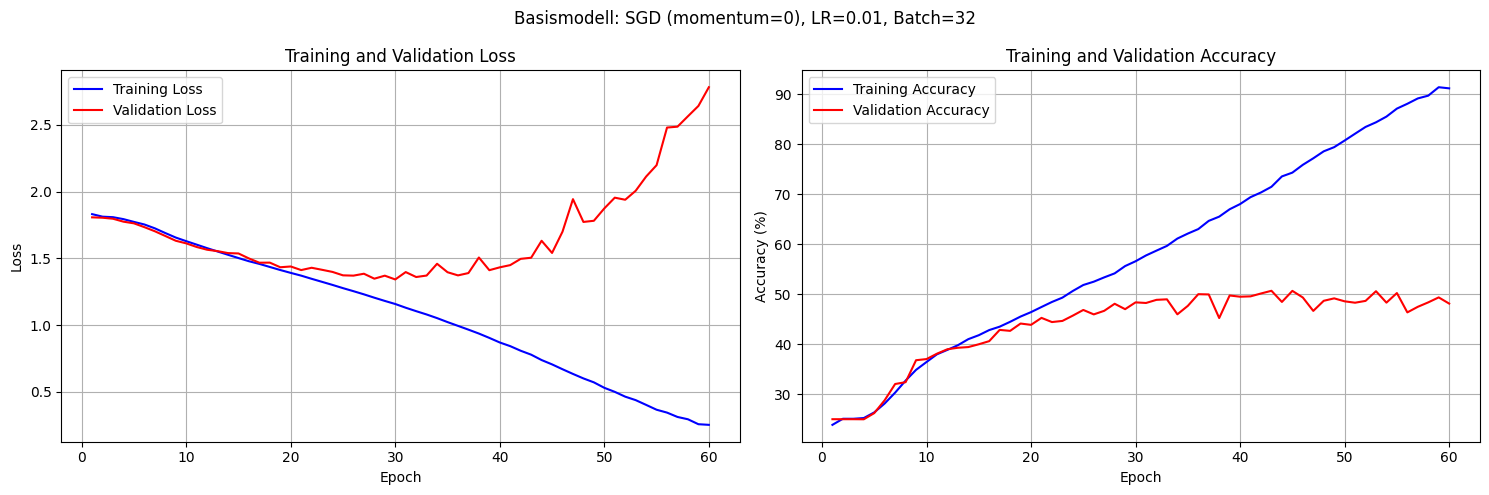

Lernkurven gespeichert als 'plots/baseline_training_curves.png'


In [6]:
# Lernkurven plotten und speichern
# Sicherstellen, dass plots Verzeichnis existiert
os.makedirs('plots', exist_ok=True)

fig = plot_training_curves(train_losses, val_losses, train_accs, val_accs, 
                          title="Basismodell: SGD (momentum=0), LR=0.01, Batch=32")

# Plot als Bild speichern
fig.savefig('plots/baseline_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Lernkurven gespeichert als 'plots/baseline_training_curves.png'")

### Hyperparameter-Tuning

**Ziel:** Vergleich verschiedener Lernraten und Batch-Größen anhand der Lernkurven und Metriken.

**Testkonfigurationen:**
- **Lernraten:** [0.001, 0.01, 0.1]
- **Batch-Größen:** [16, 32, 64]
- **Epochen:** 60 (konsistent mit Baseline-Training)
- **Optimizer:** SGD ohne Momentum

**Hinweis:** Bei kleinen Datasets wird das Training automatisch beschleunigt.

In [7]:
# Hyperparameter-Tuning mit wandb Integration
print("=== Hyperparameter-Tuning ===")

# Testkonfigurationen
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64] 
num_epochs = 60  

# Hyperparameter-Tuning mit wandb durchführen
# Modell-Klasse wird als Parameter übergeben
results = hyperparameter_tuning_with_wandb(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    model_class=BaselineCNN, 
    num_epochs=num_epochs,
    img_size=img_size,
    num_classes=num_classes
)

# Finale Speicherbereinigung nach Hyperparameter-Tuning
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()
print("\nHyperparameter-Tuning abgeschlossen - Speicher freigegeben")

=== Hyperparameter-Tuning ===
=== Hyperparameter-Tuning mit wandb ===
Teste 3 Lernraten × 3 Batch-Größen = 9 Konfigurationen

--- LR_0.001_Batch_16 ---


Training startet: 60 Epochen, LR=0.001, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9229 | Val Loss: 1.8882 | Train Acc: 22.85% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8110 | Val Loss: 1.8050 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  10/60 | Train Loss: 1.8051 | Val Loss: 1.7986 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.7869 | Val Loss: 1.7854 | Train Acc: 25.38% | Val Acc: 25.13% | Patience: 1/8
Epoch  20/60 | Train Loss: 1.7685 | Val Loss: 1.7635 | Train Acc: 26.93% | Val Acc: 26.59% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.7490 | Val Loss: 1.7481 | Train Acc: 28.72% | Val Acc: 28.49% | Patience: 1/8
Epoch  30/60 | Train Loss: 1.7213 | Val Loss: 1.7103 | Train Acc: 30.90% | Val Acc: 31.37% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.6872 | Val Loss: 1.6813 | Train Acc: 33.33% | Val Acc: 33.40% | Pati

Finale Validation Accuracy: 38.89% | F1-Score: 0.3377
Beste Validation Accuracy: 40.35% (Epoche 57) | F1-Score: 0.3680
Finale Validation Loss: 1.5533
Speicher nach Variante freigegeben

--- LR_0.001_Batch_32 ---


Training startet: 60 Epochen, LR=0.001, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9128 | Val Loss: 1.8968 | Train Acc: 24.14% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8127 | Val Loss: 1.8058 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.8090 | Val Loss: 1.8027 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  15/60 | Train Loss: 1.8046 | Val Loss: 1.7977 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.7976 | Val Loss: 1.7905 | Train Acc: 25.14% | Val Acc: 25.08% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.7868 | Val Loss: 1.7808 | Train Acc: 25.41% | Val Acc: 25.74% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.7732 | Val Loss: 1.7656 | Train Acc: 26.59% | Val Acc: 26.45% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.7548 | Val Loss: 1.7528 | Train Acc: 28.45% | Val Acc: 28.61% | Pati

Finale Validation Accuracy: 34.06% | F1-Score: 0.3004
Beste Validation Accuracy: 34.06% (Epoche 60) | F1-Score: 0.3004
Finale Validation Loss: 1.6689
Speicher nach Variante freigegeben

--- LR_0.001_Batch_64 ---


Training startet: 60 Epochen, LR=0.001, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.9239 | Val Loss: 1.9096 | Train Acc: 21.94% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8253 | Val Loss: 1.8180 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.8136 | Val Loss: 1.8077 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.8126 | Val Loss: 1.8067 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.8119 | Val Loss: 1.8060 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 5/8
Epoch  25/60 | Train Loss: 1.8112 | Val Loss: 1.8053 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 2/8
Epoch  30/60 | Train Loss: 1.8103 | Val Loss: 1.8045 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.8093 | Val Loss: 1.8037 | Train Acc: 25.15% | Val Acc: 25.06% | Pati

Finale Validation Accuracy: 25.34% | F1-Score: 0.1117
Beste Validation Accuracy: 25.34% (Epoche 60) | F1-Score: 0.1117
Finale Validation Loss: 1.7900
Speicher nach Variante freigegeben

--- LR_0.01_Batch_16 ---


Training startet: 60 Epochen, LR=0.01, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8204 | Val Loss: 1.8028 | Train Acc: 24.97% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.6171 | Val Loss: 1.5926 | Train Acc: 36.79% | Val Acc: 37.98% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.4275 | Val Loss: 1.4893 | Train Acc: 45.50% | Val Acc: 43.09% | Patience: 1/8
Epoch  15/60 | Train Loss: 1.2513 | Val Loss: 1.3928 | Train Acc: 52.58% | Val Acc: 46.01% | Patience: 1/8
Epoch  20/60 | Train Loss: 1.0510 | Val Loss: 1.4089 | Train Acc: 61.22% | Val Acc: 49.36% | Patience: 2/8
Epoch  25/60 | Train Loss: 0.8299 | Val Loss: 1.4700 | Train Acc: 69.40% | Val Acc: 49.51% | Patience: 7/8

Early Stopping nach 26 Epochen!
Beste Validation Loss: 1.3570 in Epoche 18


Finale Validation Accuracy: 50.52% | F1-Score: 0.4986
Beste Validation Accuracy: 51.17% (Epoche 23) | F1-Score: 0.5057
Finale Validation Loss: 1.5053
Speicher nach Variante freigegeben

--- LR_0.01_Batch_32 ---


Training startet: 60 Epochen, LR=0.01, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8372 | Val Loss: 1.8063 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.7859 | Val Loss: 1.7736 | Train Acc: 25.45% | Val Acc: 25.15% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.7131 | Val Loss: 1.7060 | Train Acc: 31.31% | Val Acc: 30.70% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.5949 | Val Loss: 1.5827 | Train Acc: 38.35% | Val Acc: 38.61% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.4854 | Val Loss: 1.4944 | Train Acc: 43.09% | Val Acc: 42.35% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.3817 | Val Loss: 1.4395 | Train Acc: 47.35% | Val Acc: 44.65% | Patience: 1/8
Epoch  30/60 | Train Loss: 1.2700 | Val Loss: 1.3860 | Train Acc: 51.93% | Val Acc: 47.30% | Patience: 0/8
Epoch  35/60 | Train Loss: 1.1523 | Val Loss: 1.4380 | Train Acc: 56.34% | Val Acc: 45.58% | Patie

Finale Validation Accuracy: 48.15% | F1-Score: 0.4678
Beste Validation Accuracy: 48.54% (Epoche 38) | F1-Score: 0.4730
Finale Validation Loss: 1.4605
Speicher nach Variante freigegeben

--- LR_0.01_Batch_64 ---


Training startet: 60 Epochen, LR=0.01, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8661 | Val Loss: 1.8087 | Train Acc: 22.99% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.8050 | Val Loss: 1.7957 | Train Acc: 25.16% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.7482 | Val Loss: 1.7320 | Train Acc: 28.70% | Val Acc: 29.29% | Patience: 0/8
Epoch  15/60 | Train Loss: 1.6680 | Val Loss: 1.6492 | Train Acc: 34.95% | Val Acc: 34.97% | Patience: 0/8
Epoch  20/60 | Train Loss: 1.6004 | Val Loss: 1.6050 | Train Acc: 38.22% | Val Acc: 37.39% | Patience: 0/8
Epoch  25/60 | Train Loss: 1.5404 | Val Loss: 1.5536 | Train Acc: 40.68% | Val Acc: 39.08% | Patience: 0/8
Epoch  30/60 | Train Loss: 1.4811 | Val Loss: 1.5477 | Train Acc: 43.22% | Val Acc: 40.18% | Patience: 1/8
Epoch  35/60 | Train Loss: 1.4180 | Val Loss: 1.4548 | Train Acc: 45.75% | Val Acc: 43.50% | Patie

Finale Validation Accuracy: 48.31% | F1-Score: 0.4712
Beste Validation Accuracy: 48.31% (Epoche 57) | F1-Score: 0.4712
Finale Validation Loss: 1.4026
Speicher nach Variante freigegeben

--- LR_0.1_Batch_16 ---


Training startet: 60 Epochen, LR=0.1, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.7732 | Val Loss: 1.6447 | Train Acc: 27.14% | Val Acc: 34.80% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.2612 | Val Loss: 1.3221 | Train Acc: 52.00% | Val Acc: 49.20% | Patience: 0/8
Epoch  10/60 | Train Loss: 0.9281 | Val Loss: 1.5409 | Train Acc: 65.66% | Val Acc: 47.93% | Patience: 5/8

Early Stopping nach 13 Epochen!
Beste Validation Loss: 1.3221 in Epoche 5


Finale Validation Accuracy: 48.33% | F1-Score: 0.4846
Beste Validation Accuracy: 50.17% (Epoche 7) | F1-Score: 0.4883
Finale Validation Loss: 1.7062
Speicher nach Variante freigegeben

--- LR_0.1_Batch_32 ---


Training startet: 60 Epochen, LR=0.1, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8056 | Val Loss: 1.7684 | Train Acc: 24.80% | Val Acc: 26.56% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.3566 | Val Loss: 1.3811 | Train Acc: 48.13% | Val Acc: 45.61% | Patience: 0/8
Epoch  10/60 | Train Loss: 0.9769 | Val Loss: 1.4466 | Train Acc: 63.38% | Val Acc: 47.93% | Patience: 3/8
Epoch  15/60 | Train Loss: 0.5892 | Val Loss: 1.9285 | Train Acc: 78.55% | Val Acc: 49.18% | Patience: 8/8

Early Stopping nach 15 Epochen!
Beste Validation Loss: 1.3269 in Epoche 7


Finale Validation Accuracy: 49.18% | F1-Score: 0.4953
Beste Validation Accuracy: 51.15% (Epoche 14) | F1-Score: 0.5096
Finale Validation Loss: 1.9285
Speicher nach Variante freigegeben

--- LR_0.1_Batch_64 ---


Training startet: 60 Epochen, LR=0.1, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8036 | Val Loss: 1.7685 | Train Acc: 25.25% | Val Acc: 26.35% | Patience: 0/8
Epoch   5/60 | Train Loss: 1.4624 | Val Loss: 1.4679 | Train Acc: 43.75% | Val Acc: 43.63% | Patience: 0/8
Epoch  10/60 | Train Loss: 1.1496 | Val Loss: 1.2824 | Train Acc: 56.79% | Val Acc: 50.57% | Patience: 0/8
Epoch  15/60 | Train Loss: 0.8237 | Val Loss: 1.4549 | Train Acc: 69.63% | Val Acc: 49.97% | Patience: 4/8

Early Stopping nach 19 Epochen!
Beste Validation Loss: 1.2634 in Epoche 11


Finale Validation Accuracy: 51.04% | F1-Score: 0.5075
Beste Validation Accuracy: 53.15% (Epoche 13) | F1-Score: 0.5282
Finale Validation Loss: 1.8460
Speicher nach Variante freigegeben

Hyperparameter-Tuning abgeschlossen - Speicher freigegeben


In [8]:
# Visualisierung der Hyperparameter-Ergebnisse
print("=== Hyperparameter-Vergleich ===")

# Zusammenfassung der Ergebnisse mit F1-Score und bester Performance
summary_data = []
for config_key, result in results.items():
    summary_data.append({
        'Learning Rate': result['learning_rate'],
        'Batch Size': result['batch_size'],
        'Final Train Acc (%)': result['final_train_acc'],
        'Final Val Acc (%)': result['final_val_acc'],
        'Best Val Acc (%)': result.get('best_val_acc', result['final_val_acc']),
        'Final Train F1': result.get('final_train_f1', 0),
        'Final Val F1': result.get('final_val_f1', 0),
        'Best Val F1': result.get('best_val_f1', result.get('final_val_f1', 0)),
        'Final Train Loss': result['final_train_loss'],
        'Final Val Loss': result['final_val_loss'],
        'Epochen': result.get('num_epochs', result.get('best_epoch', len(result.get('val_accs', []))))
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Best Val Acc (%)', ascending=False)
print(df_summary[['Learning Rate', 'Batch Size', 'Best Val Acc (%)', 'Best Val F1', 'Final Val Acc (%)', 'Final Val F1', 'Epochen']].to_string(index=False))

# Beste Konfiguration finden
best_config = df_summary.iloc[0]
print(f"\nBeste Konfiguration:")
print(f"Learning Rate: {best_config['Learning Rate']}")
print(f"Batch Size: {best_config['Batch Size']}")
print(f"Beste Validation Accuracy: {best_config['Best Val Acc (%)']:.2f}% (Epoche {best_config['Epochen']})")
print(f"Beste Validation F1-Score: {best_config['Best Val F1']:.4f}")
print(f"Finale Validation Accuracy: {best_config['Final Val Acc (%)']:.2f}%")
print(f"Finale Validation F1-Score: {best_config['Final Val F1']:.4f}")

=== Hyperparameter-Vergleich ===
 Learning Rate  Batch Size  Best Val Acc (%)  Best Val F1  Final Val Acc (%)  Final Val F1  Epochen
         0.100          64         53.152212     0.528175          51.044932      0.507494       19
         0.010          16         51.166841     0.505686          50.522466      0.498643       26
         0.100          32         51.149425     0.509627          49.181470      0.495335       15
         0.100          16         50.174155     0.488279          48.328109      0.484625       13
         0.010          32         48.537095     0.473039          48.153953      0.467779       42
         0.010          64         48.310693     0.471182          48.310693      0.471182       57
         0.001          16         40.351794     0.367973          38.888889      0.337716       60
         0.001          32         34.064786     0.300391          34.064786      0.300391       60
         0.001          64         25.339603     0.111674          

Hyperparameter-Vergleichsplot gespeichert als 'plots/hyperparameter_comparison.png'


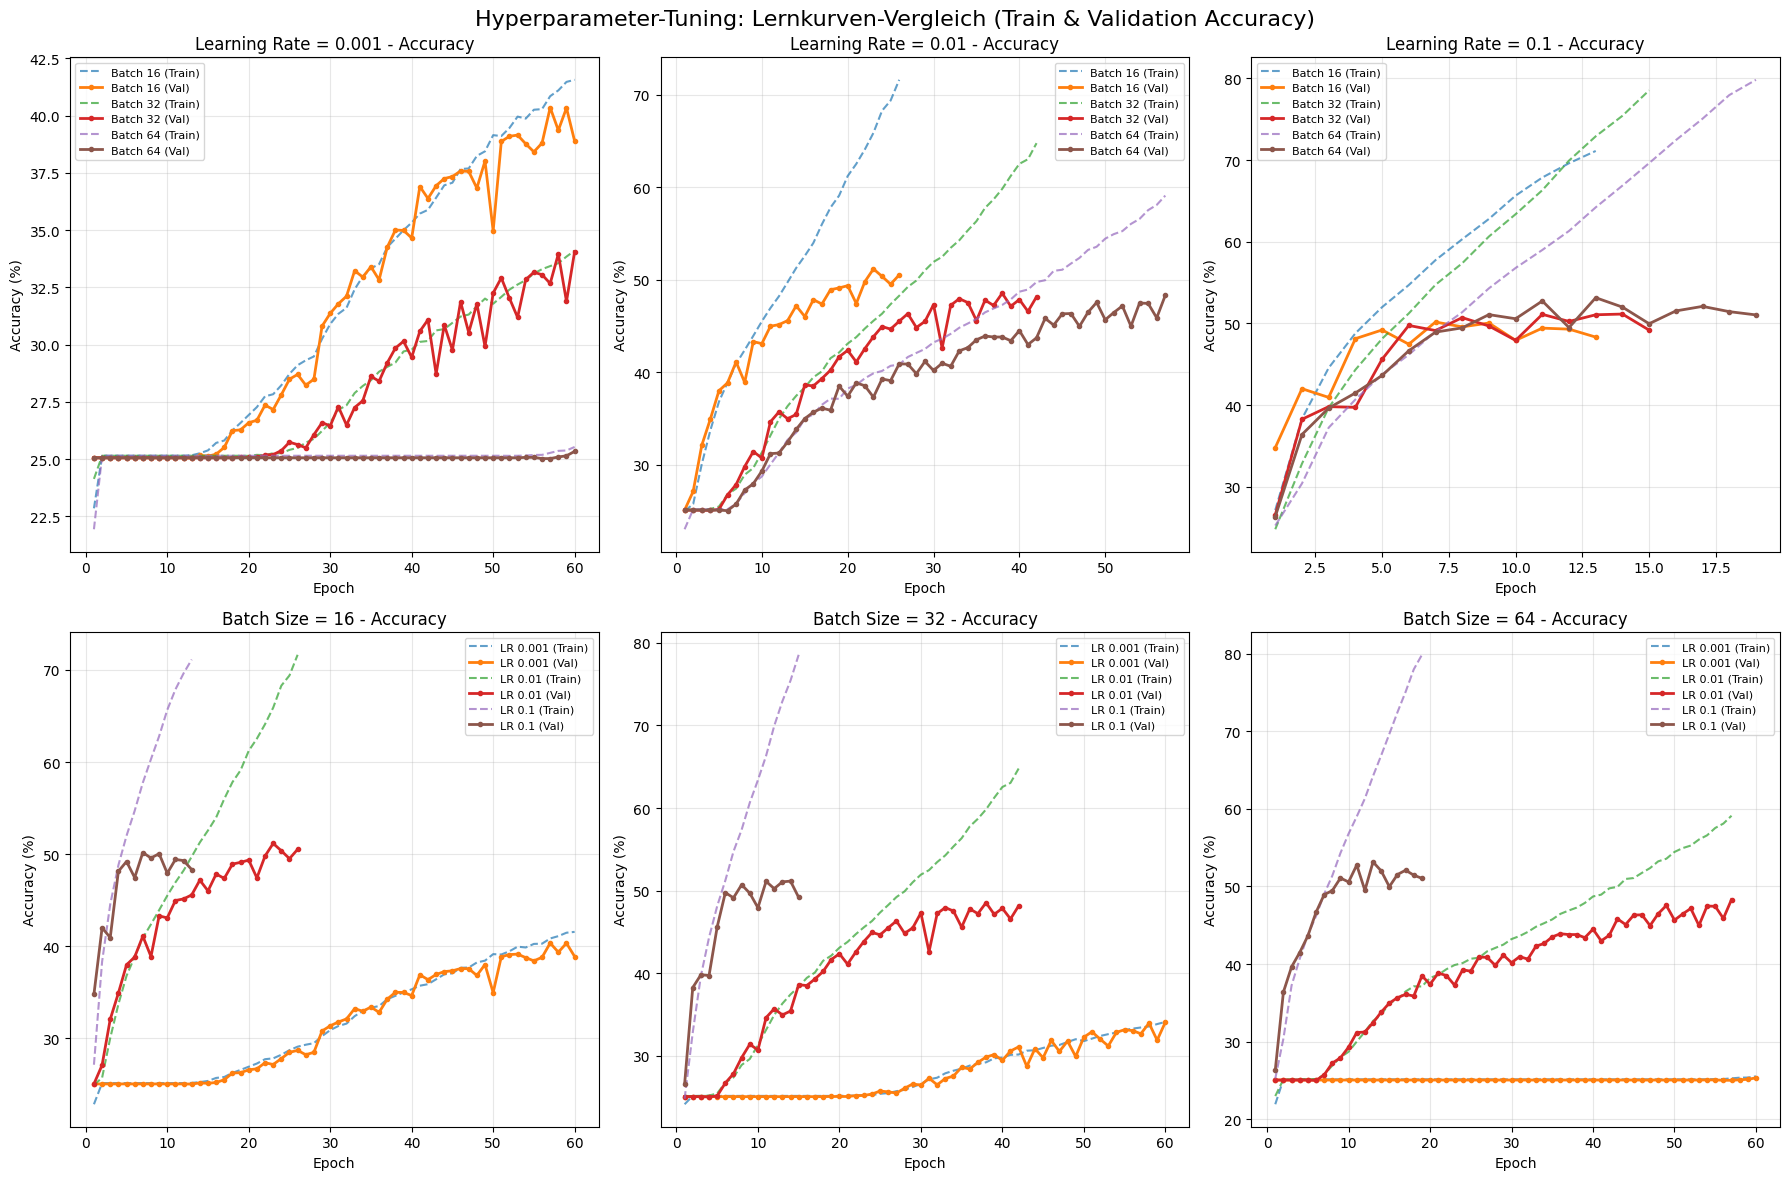

Performance-Übersicht gespeichert als 'plots/hyperparameter_performance_summary.png'


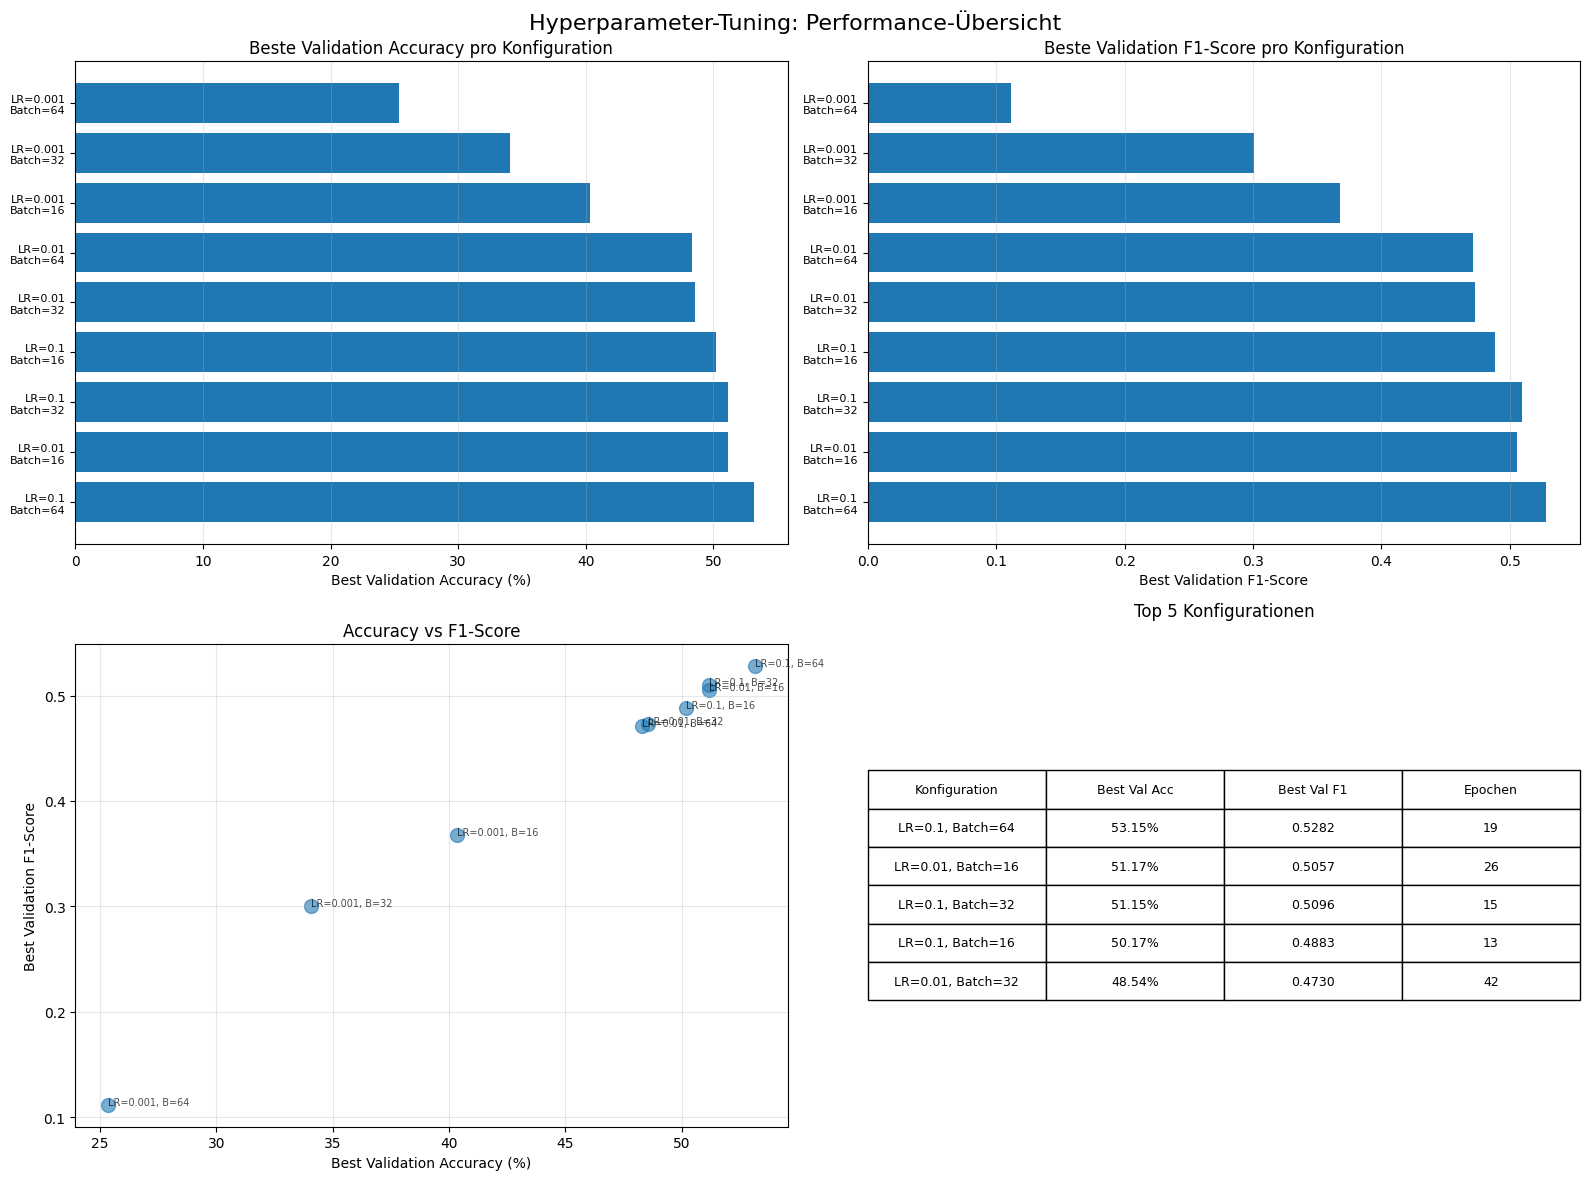

Hyperparameter-Plots gespeichert:
  - plots/hyperparameter_comparison.png
  - plots/hyperparameter_performance_summary.png


In [9]:
# Lernkurven-Vergleich für verschiedene Konfigurationen 
os.makedirs('plots', exist_ok=True)

fig = plot_hyperparameter_comparison(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_comparison.png'
)

# Performance-Übersicht mit Accuracy, F1-Score, LR und Epochen
fig_perf = plot_hyperparameter_performance_summary(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_performance_summary.png'
)

print("Hyperparameter-Plots gespeichert:")
print("  - plots/hyperparameter_comparison.png")
print("  - plots/hyperparameter_performance_summary.png")

### Cross-Validation für statistische Fehlerschätzung

**Ziel:** Schätzung des statistischen Fehlers der Metriken durch Cross-Validation.

**Konfiguration:**
- **5-Fold Cross-Validation** auf dem Trainingsdatensatz
- **Beste Hyperparameter** aus dem Tuning verwenden
- **60 Epochen pro Fold** (konsistent mit Baseline-Training)
- **Early Stopping deaktiviert** für faire statistische Vergleichbarkeit
- **Statistische Auswertung:** Mittelwert ± Standardabweichung

**Hinweis zu Unsicherheiten:** Die Standardabweichung zeigt die Variabilität zwischen den Folds. 
Eine höhere Standardabweichung deutet auf größere Unsicherheit in den Ergebnissen hin, 
was durch unterschiedliche Datenverteilungen in den Folds oder Modell-Instabilität verursacht werden kann.

In [10]:
# Cross-Validation für statistische Fehlerschätzung
print("=== Cross-Validation ===")

# Beste Hyperparameter aus dem Tuning verwenden
best_lr = best_config["Learning Rate"]
best_batch = int(best_config["Batch Size"])

print(f"Verwende beste Konfiguration: LR={best_lr}, Batch={best_batch}")

# Cross-Validation durchführen
# Modell-Klasse wird als Parameter übergeben, Early Stopping ist deaktiviert
cv_results = cross_validation_training(
    train_dataset=full_train_dataset,
    model_class=BaselineCNN,  # Modell-Klasse als Parameter
    num_folds=5,
    num_epochs=60,  
    learning_rate=best_lr,
    batch_size=best_batch,
    img_size=img_size,
    num_classes=num_classes
)

print(f"\n=== Cross-Validation Ergebnisse (Mittelwert ± Standardabweichung) ===")
print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")

# F1-Scores ausgeben falls vorhanden
if 'train_f1s' in cv_results:
    print(f"Training F1-Score: {cv_results['train_f1s']['mean']:.4f} ± {cv_results['train_f1s']['std']:.4f}")
    print(f"Validation F1-Score: {cv_results['val_f1s']['mean']:.4f} ± {cv_results['val_f1s']['std']:.4f}")

# Sicherstellen, dass das results Verzeichnis existiert
os.makedirs('results', exist_ok=True)

with open('results/cross_validation_results.json', 'w') as f:
    json.dump({
        'best_hyperparameters': {
            'learning_rate': best_lr,
            'batch_size': best_batch
        },
        'cv_results': cv_results,
        'num_epochs': 60, 
        'note': 'Early Stopping wurde deaktiviert für konsistente Epochenanzahl'
    }, f, indent=2)

print("\nCross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'")

=== Cross-Validation ===
Verwende beste Konfiguration: LR=0.1, Batch=64
Cross-Validation mit 5 Folds
Jeder Fold trainiert exakt 60 Epochen (Early Stopping deaktiviert für Konsistenz)

Fold 1/5
------------------------------
Training startet: 60 Epochen, LR=0.1, Batch=64
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8189 | Val Loss: 1.8039 | Train Acc: 24.88% | Val Acc: 25.67%
Epoch   5/60 | Train Loss: 1.5318 | Val Loss: 1.5053 | Train Acc: 40.59% | Val Acc: 41.40%
Epoch  10/60 | Train Loss: 1.2279 | Val Loss: 1.3933 | Train Acc: 53.35% | Val Acc: 45.35%
Epoch  15/60 | Train Loss: 0.9353 | Val Loss: 1.3828 | Train Acc: 65.47% | Val Acc: 49.49%
Epoch  20/60 | Train Loss: 0.6044 | Val Loss: 1.6433 | Train Acc: 77.85% | Val Acc: 51.39%
Epoch  25/60 | Train Loss: 0.3457 | Val Loss: 2.3561 | Train Acc: 87.66% | Val Acc: 51.79%
Epoch  30/60 | Train Loss: 0.2131 | Val Loss: 2.9824 | Train Acc: 92.93% | Val Acc: 50.21%
Epoch  35/60 | Train Loss: 0.15

## Hyperparameter-Experimente: Kategorie 1 - Modellkomplexität

**Hinweis:** Die Hypothesen, Erwartungen und Analysen sind im `main.ipynb` dokumentiert. Hier werden nur die Experimente durchgeführt.

**WICHTIG - Experimentdesign:**
Jedes Experiment variiert **nur EINEN Parameter** und hält alle anderen Parameter auf der Baseline-Konfiguration:
- **Baseline-Konfiguration:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen
- **Hypothese 1:** Variiert nur die Anzahl Conv-Layer (2, 3, 4, 5)
- **Hypothese 2:** Variiert nur die Filter-Anzahl pro Layer ([8,16,32], [16,32,64], [32,64,128], [64,128,256])
- **Hypothese 3:** Variiert nur die FC-Layer Breite (32, 64, 128, 256, 512 Neuronen)

Diese isolierte Variation ermöglicht es, den Effekt jedes einzelnen Parameters zu verstehen.

In [4]:
# Baseline-Ergebnisse laden
baseline_results_file = 'results/baseline_results.json'
with open(baseline_results_file, 'r') as f:
    baseline_results = json.load(f)

# Listen zurück in numpy arrays konvertieren
for key in ['train_losses', 'val_losses', 'train_accs', 'val_accs', 'train_f1s', 'val_f1s']:
    if key in baseline_results and isinstance(baseline_results[key], list):
        baseline_results[key] = np.array(baseline_results[key])

print(f"Baseline-Ergebnisse geladen:")
print(f"  - Parameter: {baseline_results['num_params']:,}")
print(f"  - Beste Val Acc: {baseline_results['best_val_acc']:.2f}% (Epoche {baseline_results['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results['final_val_acc']:.2f}%")
print(f"  - Experiment: {baseline_results['experiment_name']}")

Baseline-Ergebnisse geladen:
  - Parameter: 171,271
  - Beste Val Acc: 50.73% (Epoche 43)
  - Finale Val Acc: 48.17%
  - Experiment: baseline_model


### Hypothese 1: Modelltiefe (Anzahl Conv-Layer)

**Variiert:** Nur die Anzahl Conv-Layer (2, 3, 4, 5)  
**Baseline-Parameter:** Filter [16, 32, 64], FC-Layer 64 Neuronen

In [18]:
# Hypothese 1 Ergebnisse initialisieren
hypothesis_1_file = 'results/hypothesis_1_depth.json'
hypothesis_1_results = {}

# Experiment 1.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 1.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp1 = copy.deepcopy(baseline_results)
baseline_results_hyp1['experiment_name'] = 'hyp1_baseline_3layers'
hypothesis_1_results['3_layers'] = baseline_results_hyp1

# Automatisch speichern
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Experiment 1.2: 2 Layer
print("\n" + "-"*60)
print("Experiment 1.2: 2 Conv-Layer")
print("Filter: [16, 32]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_2 = run_hyperparameter_experiment(
    experiment_name="hyp1_2layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 2,  
        'filters_per_layer': [16, 32]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 

    use_wandb=True
)
hypothesis_1_results['2_layers'] = result_2

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 1.3: 4 Layer
print("\n" + "-"*60)
print("Experiment 1.3: 4 Conv-Layer")
print("Filter: [16, 32, 64, 128]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

result_4 = run_hyperparameter_experiment(
    experiment_name="hyp1_4layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 4, 
        'filters_per_layer': [16, 32, 64, 128] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32, 

    use_wandb=True
)
hypothesis_1_results['4_layers'] = result_4

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 1.4: 6 Layer
print("\n" + "-"*60)
print("Experiment 1.4: 6 Conv-Layer")
print("Filter: [16, 32, 64, 128, 256, 512]")
print("FC-Layer: 64 Neuronen (Baseline)")
print("Pooling: Nach Layer 1, 2, 3 (wie Baseline), dann kein Pooling mehr")
print("-"*60)

result_6 = run_hyperparameter_experiment(
    experiment_name="hyp1_6layers",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 6, 
        'filters_per_layer': [16, 32, 64, 128, 256, 512],
        'pool_after_layers': [0, 1, 2]  # Pooling nur nach den ersten 3 Layern
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32,  

    use_wandb=True
)
hypothesis_1_results['6_layers'] = result_6

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_1_results, hypothesis_1_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()


------------------------------------------------------------
Experiment 1.1: Baseline (3 Conv-Layer)
Filter: [16, 32, 64] (Baseline)
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------
Ergebnisse gespeichert: results/hypothesis_1_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_1_depth.json

------------------------------------------------------------
Experiment 1.2: 2 Conv-Layer
Filter: [16, 32]
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp1_2layers
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 2, 'filters_per_layer': [16, 32]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 300,231 total, 300,231 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8213 | Val Loss: 1.7987 | Train Acc: 24.59% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.6731 | Val Loss: 1.6614 | Train Acc: 34.19% | Val Acc: 33.82%
Epoch  10/60 | Train Loss: 1.5549 | Val Loss: 1.5468 | Train Acc: 39.99% | Val Acc: 40.77%
Epoch  15/60 | Train Loss: 1.4428 | Val Loss: 1.4611 | Train Acc: 45.08% | Val Acc: 43.78%
Epoch  20/60 | Train Loss: 1.3291 | Val Loss: 1.4106 | Train Acc: 49.85% | Val Acc: 45.77%
Epoch  25/60 | Train Loss: 1.2086 | Val Loss: 1.4142 | Train Acc: 55.06% | Val Acc: 46.80%
Epoch  30/60 | Train Loss: 1.0762 | Val Loss: 1.4588 | Train Acc: 60.70% | Val Acc: 46.38%
Epoch  35/60 | Train Loss: 0.9237 | Val Loss: 1.4564 | Train Acc: 66.34% | Val Acc: 47.84%
Epoch  40/60 | Train Loss: 0.7526 | Val Loss: 1.6139 | Train Acc: 73.07% | Val Acc: 47.61%
Epoch  45/60 | Train Loss: 0.5778 | Val Loss: 1.8606 | Train Acc: 79.87%


ERGEBNISSE: hyp1_2layers
Beste Validation Accuracy: 48.96% (Epoche 38)
Finale Validation Accuracy: 47.25%
Finale Validation F1-Score: 0.4703
Overfitting-Gap (Acc): 47.92%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_1_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_1_depth.json

------------------------------------------------------------
Experiment 1.3: 4 Conv-Layer
Filter: [16, 32, 64, 128]
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp1_4layers
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 4, 'filters_per_layer': [16, 32, 64, 128]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,399 total, 171,399 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8465 | Val Loss: 1.8074 | Train Acc: 24.33% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.8096 | Val Loss: 1.8021 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  10/60 | Train Loss: 1.7644 | Val Loss: 1.7643 | Train Acc: 27.24% | Val Acc: 26.14%
Epoch  15/60 | Train Loss: 1.6333 | Val Loss: 1.6217 | Train Acc: 35.82% | Val Acc: 35.58%
Epoch  20/60 | Train Loss: 1.5039 | Val Loss: 1.4967 | Train Acc: 42.06% | Val Acc: 41.59%
Epoch  25/60 | Train Loss: 1.3895 | Val Loss: 1.4209 | Train Acc: 46.93% | Val Acc: 45.40%
Epoch  30/60 | Train Loss: 1.2756 | Val Loss: 1.3751 | Train Acc: 51.84% | Val Acc: 47.77%
Epoch  35/60 | Train Loss: 1.1459 | Val Loss: 1.4170 | Train Acc: 57.35% | Val Acc: 48.36%
Epoch  40/60 | Train Loss: 1.0034 | Val Loss: 1.3929 | Train Acc: 62.44% | Val Acc: 49.83%
Epoch  45/60 | Train Loss: 0.8421 | Val Loss: 1.5289 | Train Acc: 68.84%


ERGEBNISSE: hyp1_4layers
Beste Validation Accuracy: 50.85% (Epoche 44)
Finale Validation Accuracy: 48.24%
Finale Validation F1-Score: 0.4811
Overfitting-Gap (Acc): 39.00%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_1_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_1_depth.json

------------------------------------------------------------
Experiment 1.4: 6 Conv-Layer
Filter: [16, 32, 64, 128, 256, 512]
FC-Layer: 64 Neuronen (Baseline)
Pooling: Nach Layer 1, 2, 3 (wie Baseline), dann kein Pooling mehr
------------------------------------------------------------

EXPERIMENT: hyp1_6layers
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 6, 'filters_per_layer': [16, 32, 64, 128, 256, 512], 'pool_after_layers': [0, 1, 2]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 2,752,647 total, 2,752,647 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8577 | Val Loss: 1.8114 | Train Acc: 24.12% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.8114 | Val Loss: 1.8056 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  10/60 | Train Loss: 1.8111 | Val Loss: 1.8049 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  15/60 | Train Loss: 1.8065 | Val Loss: 1.7992 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  20/60 | Train Loss: 1.7816 | Val Loss: 1.7795 | Train Acc: 25.45% | Val Acc: 25.30%
Epoch  25/60 | Train Loss: 1.7470 | Val Loss: 1.7342 | Train Acc: 28.31% | Val Acc: 29.08%
Epoch  30/60 | Train Loss: 1.6103 | Val Loss: 1.5836 | Train Acc: 37.09% | Val Acc: 37.23%
Epoch  35/60 | Train Loss: 1.4998 | Val Loss: 1.5005 | Train Acc: 41.91% | Val Acc: 41.52%
Epoch  40/60 | Train Loss: 1.3959 | Val Loss: 1.4233 | Train Acc: 46.52% | Val Acc: 44.76%
Epoch  45/60 | Train Loss: 1.2894 | Val Loss: 1.3914 | Train Acc: 50.97%


ERGEBNISSE: hyp1_6layers
Beste Validation Accuracy: 50.45% (Epoche 58)
Finale Validation Accuracy: 48.92%
Finale Validation F1-Score: 0.4762
Overfitting-Gap (Acc): 28.18%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_1_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_1_depth.json


33


ANALYSE HYPOTHESE 1: MODELLTIEFE

Zusammenfassung der Ergebnisse:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Finale Val F1 Overfitting-Gap (%)  Beste Epoche
     3_layers   171,271             50.73              48.17        0.4846               43.02            43
     2_layers   300,231             48.96              47.25        0.4703               47.92            38
     4_layers   171,399             50.85              48.24        0.4811               39.00            44
     6_layers 2,752,647             50.45              48.92        0.4762               28.18            58


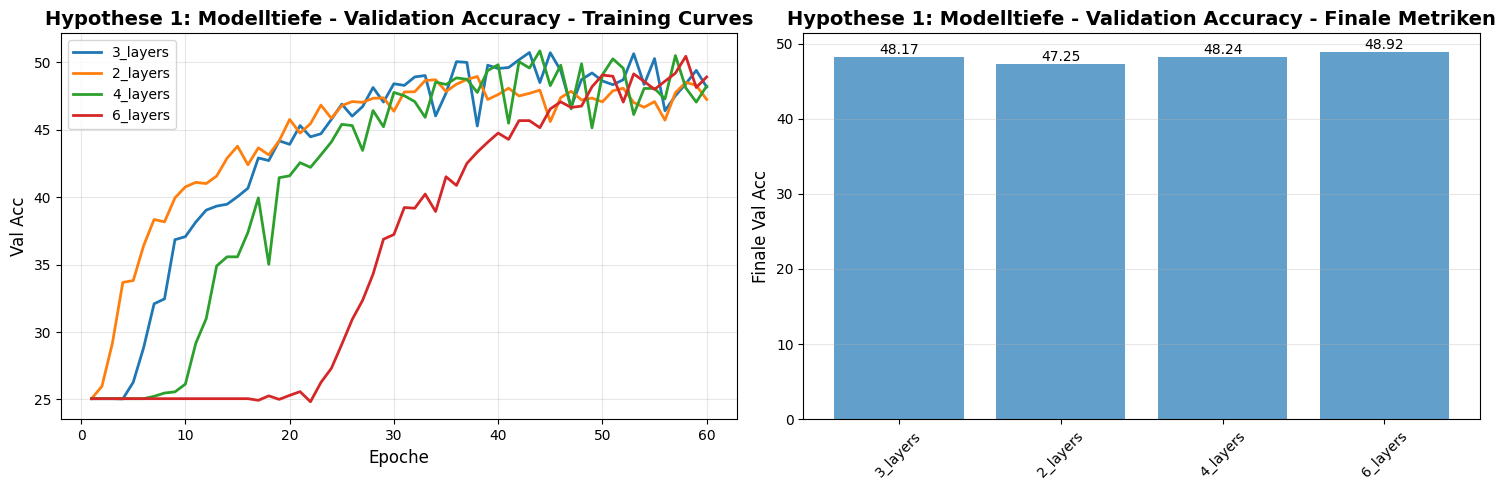

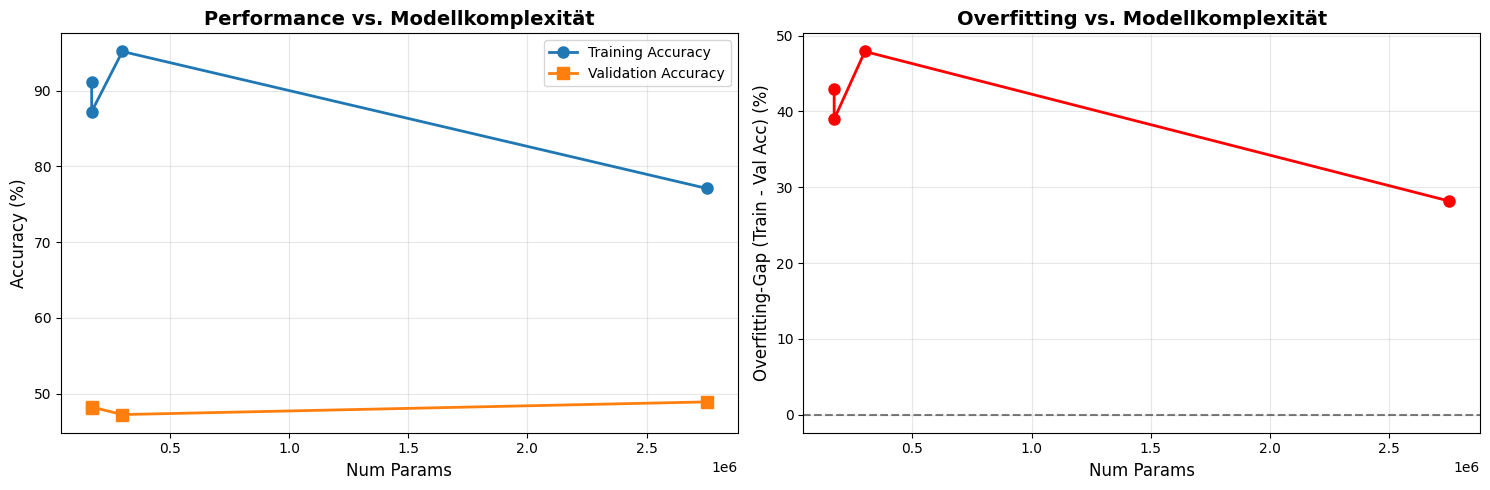

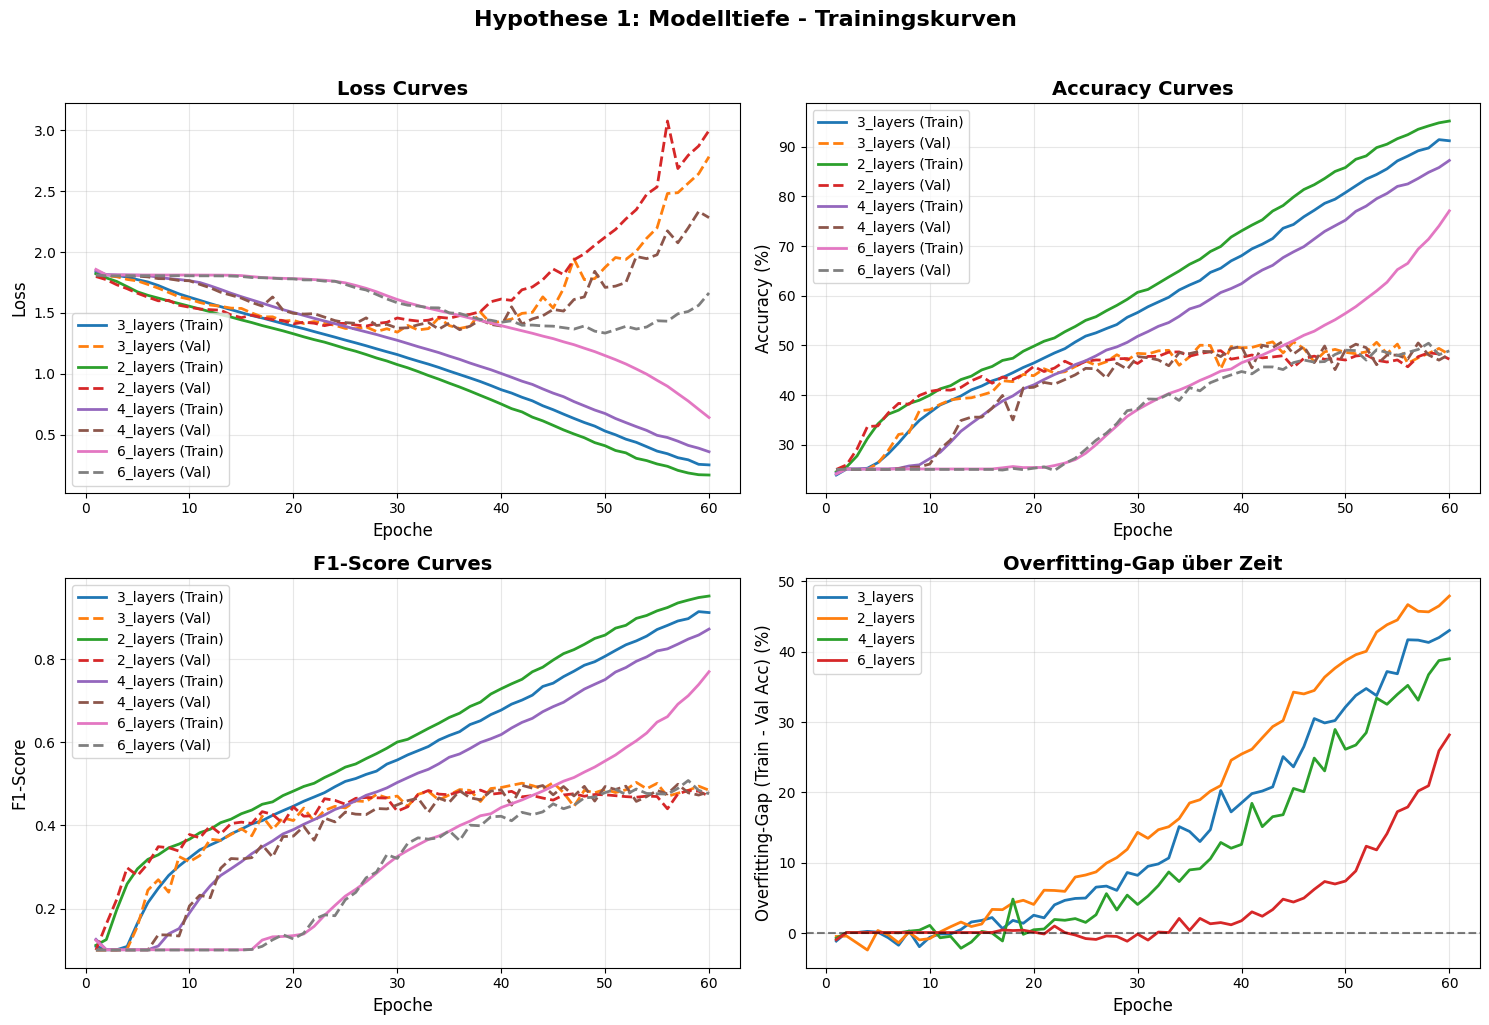

Ergebnisse gespeichert: results/hypothesis_1_depth.json

Ergebnisse gespeichert: results/hypothesis_1_depth.json


In [19]:
# Analyse und Visualisierung Hypothese 1
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 1: MODELLTIEFE")
print("="*80)

# Zusammenfassungstabelle
summary_data = []
for name, result in hypothesis_1_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Finale Val F1': f"{result['final_val_f1']:.4f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}",
        'Beste Epoche': result['best_epoch']
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
os.makedirs('plots/experiments', exist_ok=True)

fig = plot_experiment_comparison(hypothesis_1_results, metric='val_acc', 
                                 title='Hypothese 1: Modelltiefe - Validation Accuracy')
plt.savefig('plots/experiments/hyp1_depth_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_1_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp1_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_1_results, 
                                     title='Hypothese 1: Modelltiefe - Trainingskurven')
plt.savefig('plots/experiments/hyp1_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_1_results, 'results/hypothesis_1_depth.json')
print("\nErgebnisse gespeichert: results/hypothesis_1_depth.json")

### Hypothese 2: Modellbreite (Filter-Anzahl)

**Variiert:** Nur die Filter-Anzahl pro Layer ([8, 16, 32], [16, 32, 64], [32, 64, 128], [64, 128, 256])  
**Konstant:** 3 Conv-Layer (Baseline), FC-Layer 64 Neuronen (Baseline)

In [20]:
# Hypothese 2 Ergebnisse initialisieren
hypothesis_2_file = 'results/hypothesis_2_depth.json'
hypothesis_2_results = {}

# Experiment 2.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 2.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp2 = copy.deepcopy(baseline_results)
baseline_results_hyp2['experiment_name'] = 'hyp2_baseline_3layers'
hypothesis_2_results['16_32_64'] = baseline_results_hyp2

# Automatisch speichern
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Experiment 2.2: [8, 16, 32] Filter
print("\n" + "-"*60)
print("Experiment 2.2: [8, 16, 32] Filter")
print("-"*60)

result_narrow = run_hyperparameter_experiment(
    experiment_name="hyp2_narrow_8_16_32",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [8, 16, 32] 
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,  
    batch_size=32,  

    use_wandb=True
)
hypothesis_2_results['8_16_32'] = result_narrow

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 2.3: [32, 64, 128] Filter
print("\n" + "-"*60)
print("Experiment 2.3: [32, 64, 128] Filter")
print("-"*60)

result_wide1 = run_hyperparameter_experiment(
    experiment_name="hyp2_wide_32_64_128",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [32, 64, 128]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_2_results['32_64_128'] = result_wide1

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 2.4: [64, 128, 256] Filter
print("\n" + "-"*60)
print("Experiment 2.4: [64, 128, 256] Filter")
print("-"*60)

result_wide2 = run_hyperparameter_experiment(
    experiment_name="hyp2_very_wide_64_128_256",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [64, 128, 256]  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_2_results['64_128_256'] = result_wide2

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_2_results, hypothesis_2_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()



------------------------------------------------------------
Experiment 2.1: Baseline (3 Conv-Layer)
Filter: [16, 32, 64] (Baseline)
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------
Ergebnisse gespeichert: results/hypothesis_2_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_2_depth.json

------------------------------------------------------------
Experiment 2.2: [8, 16, 32] Filter
------------------------------------------------------------

EXPERIMENT: hyp2_narrow_8_16_32
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [8, 16, 32]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 80,135 total, 80,135 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8428 | Val Loss: 1.8068 | Train Acc: 24.05% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7759 | Val Loss: 1.7649 | Train Acc: 26.37% | Val Acc: 25.76%
Epoch  10/60 | Train Loss: 1.6883 | Val Loss: 1.6656 | Train Acc: 33.08% | Val Acc: 33.14%
Epoch  15/60 | Train Loss: 1.5851 | Val Loss: 1.5733 | Train Acc: 38.83% | Val Acc: 39.29%
Epoch  20/60 | Train Loss: 1.4860 | Val Loss: 1.5174 | Train Acc: 42.83% | Val Acc: 40.54%
Epoch  25/60 | Train Loss: 1.3934 | Val Loss: 1.4509 | Train Acc: 46.70% | Val Acc: 43.59%
Epoch  30/60 | Train Loss: 1.3103 | Val Loss: 1.4211 | Train Acc: 50.27% | Val Acc: 45.37%
Epoch  35/60 | Train Loss: 1.2179 | Val Loss: 1.4158 | Train Acc: 53.94% | Val Acc: 45.94%
Epoch  40/60 | Train Loss: 1.1242 | Val Loss: 1.4243 | Train Acc: 57.72% | Val Acc: 46.69%
Epoch  45/60 | Train Loss: 1.0267 | Val Loss: 1.4960 | Train Acc: 61.96%


ERGEBNISSE: hyp2_narrow_8_16_32
Beste Validation Accuracy: 47.37% (Epoche 54)
Finale Validation Accuracy: 45.77%
Finale Validation F1-Score: 0.4555
Overfitting-Gap (Acc): 28.17%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_2_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_2_depth.json

------------------------------------------------------------
Experiment 2.3: [32, 64, 128] Filter
------------------------------------------------------------

EXPERIMENT: hyp2_wide_32_64_128
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [32, 64, 128]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 388,103 total, 388,103 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8280 | Val Loss: 1.8063 | Train Acc: 25.14% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7392 | Val Loss: 1.7238 | Train Acc: 29.50% | Val Acc: 29.35%
Epoch  10/60 | Train Loss: 1.5950 | Val Loss: 1.6043 | Train Acc: 38.08% | Val Acc: 37.04%
Epoch  15/60 | Train Loss: 1.4712 | Val Loss: 1.4910 | Train Acc: 43.44% | Val Acc: 43.00%
Epoch  20/60 | Train Loss: 1.3478 | Val Loss: 1.4047 | Train Acc: 48.66% | Val Acc: 45.92%
Epoch  25/60 | Train Loss: 1.2186 | Val Loss: 1.3828 | Train Acc: 53.93% | Val Acc: 47.72%
Epoch  30/60 | Train Loss: 1.0732 | Val Loss: 1.3776 | Train Acc: 60.11% | Val Acc: 47.68%
Epoch  35/60 | Train Loss: 0.9009 | Val Loss: 1.4638 | Train Acc: 67.24% | Val Acc: 48.01%
Epoch  40/60 | Train Loss: 0.7052 | Val Loss: 1.4940 | Train Acc: 74.50% | Val Acc: 50.70%
Epoch  45/60 | Train Loss: 0.4963 | Val Loss: 1.8272 | Train Acc: 82.47%


ERGEBNISSE: hyp2_wide_32_64_128
Beste Validation Accuracy: 52.47% (Epoche 48)
Finale Validation Accuracy: 50.59%
Finale Validation F1-Score: 0.5043
Overfitting-Gap (Acc): 47.03%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_2_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_2_depth.json

------------------------------------------------------------
Experiment 2.4: [64, 128, 256] Filter
------------------------------------------------------------

EXPERIMENT: hyp2_very_wide_64_128_256
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [64, 128, 256]}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 960,007 total, 960,007 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8247 | Val Loss: 1.8070 | Train Acc: 24.74% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7214 | Val Loss: 1.7182 | Train Acc: 30.68% | Val Acc: 30.25%
Epoch  10/60 | Train Loss: 1.5552 | Val Loss: 1.5288 | Train Acc: 40.30% | Val Acc: 41.24%
Epoch  15/60 | Train Loss: 1.4181 | Val Loss: 1.4325 | Train Acc: 45.46% | Val Acc: 44.50%
Epoch  20/60 | Train Loss: 1.2863 | Val Loss: 1.3449 | Train Acc: 51.04% | Val Acc: 48.48%
Epoch  25/60 | Train Loss: 1.1423 | Val Loss: 1.3970 | Train Acc: 57.60% | Val Acc: 46.57%
Epoch  30/60 | Train Loss: 0.9688 | Val Loss: 1.3286 | Train Acc: 64.34% | Val Acc: 50.57%
Epoch  35/60 | Train Loss: 0.7561 | Val Loss: 1.4584 | Train Acc: 73.02% | Val Acc: 52.00%
Epoch  40/60 | Train Loss: 0.5151 | Val Loss: 1.6068 | Train Acc: 81.74% | Val Acc: 51.34%
Epoch  45/60 | Train Loss: 0.2956 | Val Loss: 1.9390 | Train Acc: 89.96%


ERGEBNISSE: hyp2_very_wide_64_128_256
Beste Validation Accuracy: 52.94% (Epoche 60)
Finale Validation Accuracy: 52.94%
Finale Validation F1-Score: 0.5287
Overfitting-Gap (Acc): 46.06%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_2_depth.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_2_depth.json


33


ANALYSE HYPOTHESE 2: MODELLBREITE

Zusammenfassung der Ergebnisse:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
     16_32_64   171,271             50.73              48.17               43.02
      8_16_32    80,135             47.37              45.77               28.17
    32_64_128   388,103             52.47              50.59               47.03
   64_128_256   960,007             52.94              52.94               46.06


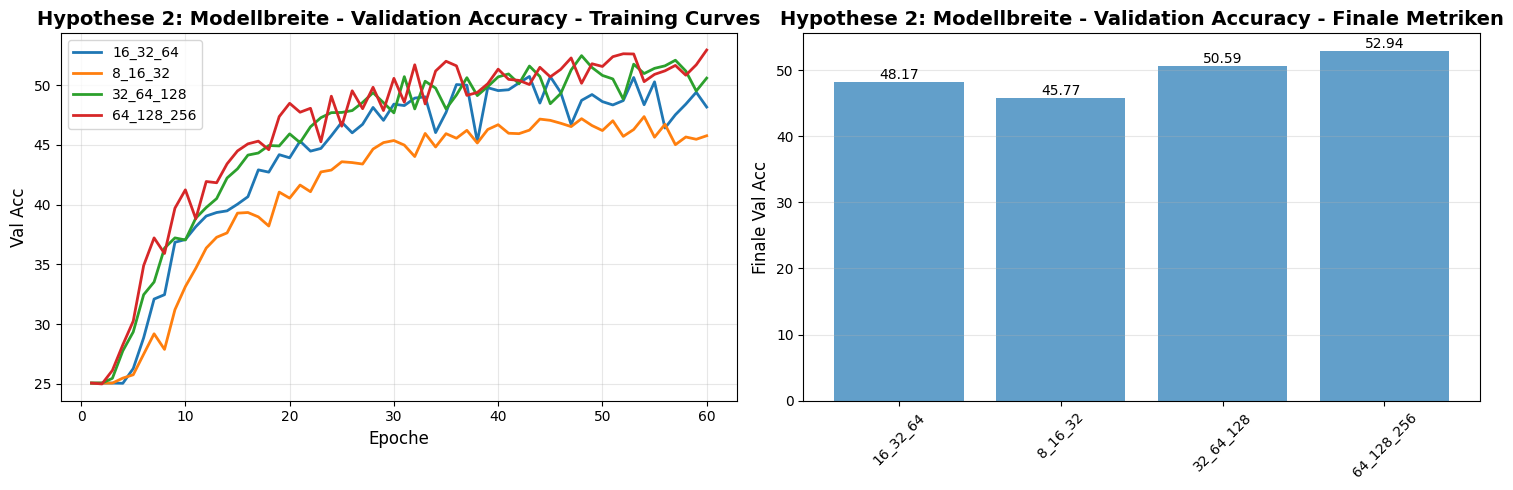

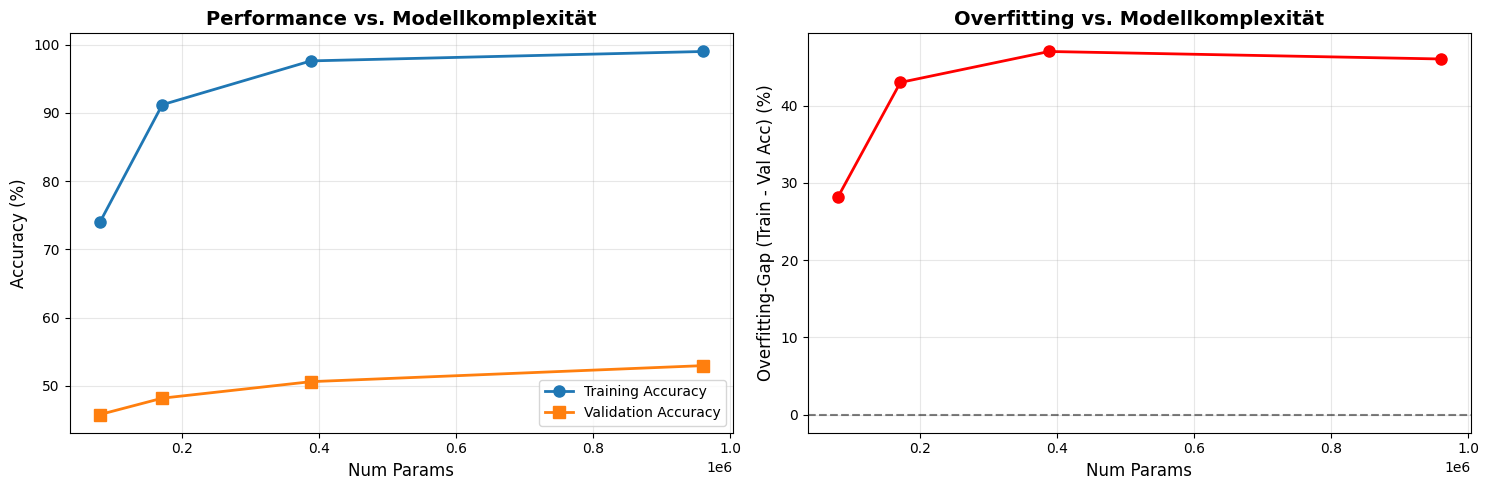

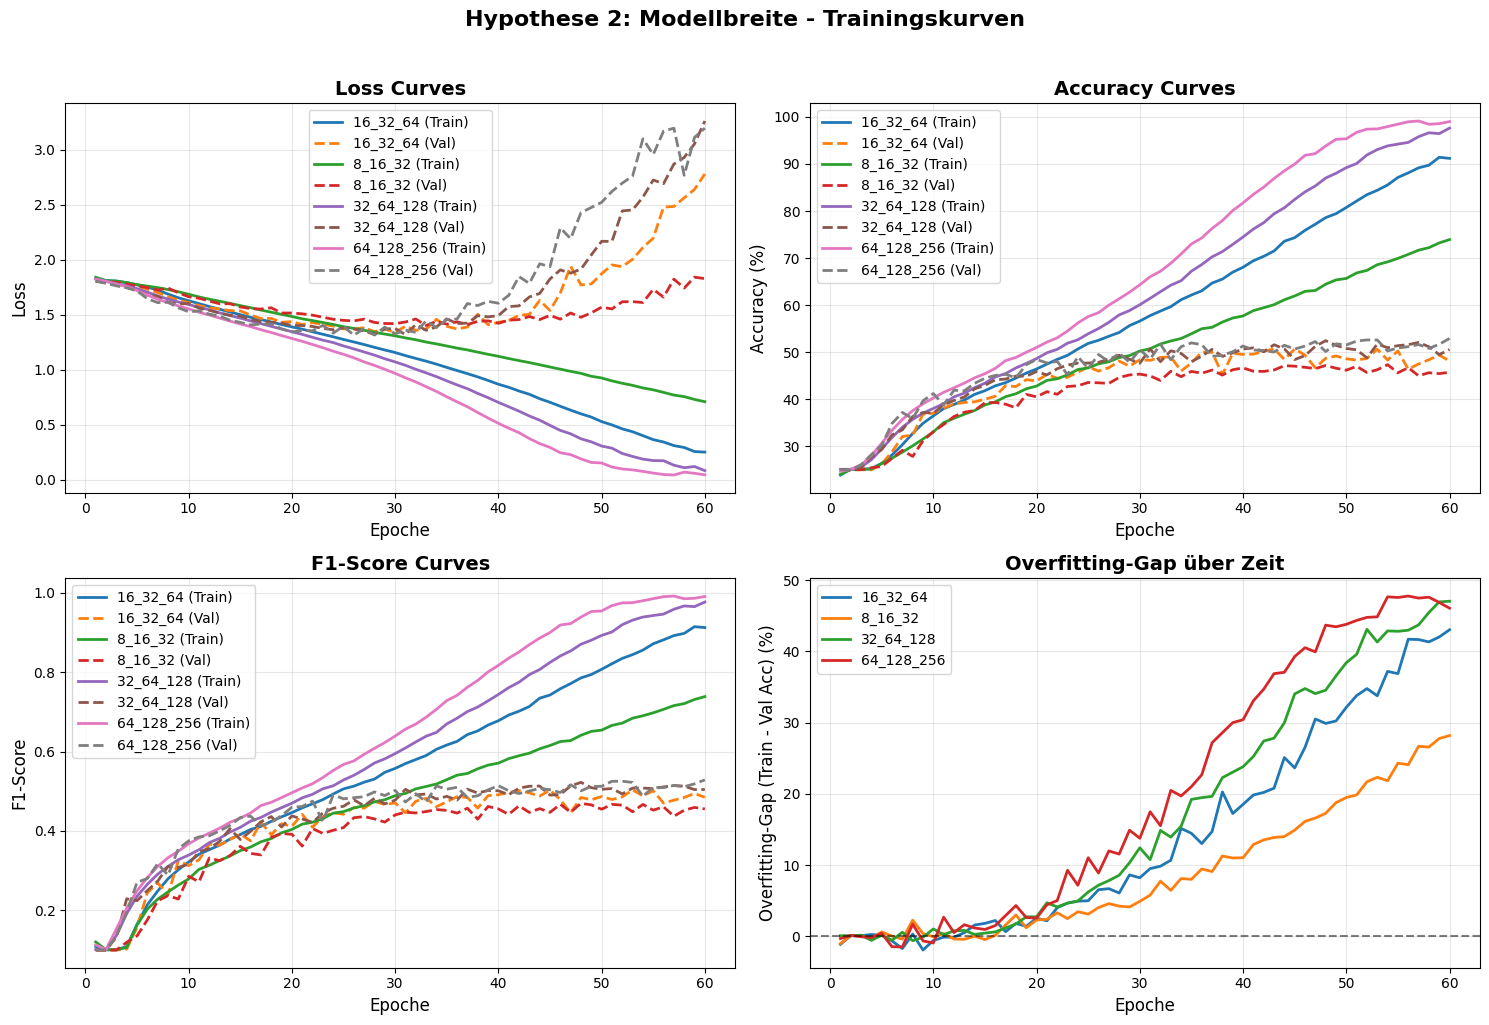

Ergebnisse gespeichert: results/hypothesis_2_width.json

Ergebnisse gespeichert: results/hypothesis_2_width.json


In [21]:
# Analyse und Visualisierung Hypothese 2
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 2: MODELLBREITE")
print("="*80)

summary_data = []
for name, result in hypothesis_2_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
fig = plot_experiment_comparison(hypothesis_2_results, metric='val_acc', 
                                 title='Hypothese 2: Modellbreite - Validation Accuracy')
plt.savefig('plots/experiments/hyp2_width_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_2_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp2_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_2_results, 
                                     title='Hypothese 2: Modellbreite - Trainingskurven')
plt.savefig('plots/experiments/hyp2_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_2_results, 'results/hypothesis_2_width.json')
print("\nErgebnisse gespeichert: results/hypothesis_2_width.json")

### Hypothese 3: FC-Layer Breite (Anzahl Neuronen)

**Variiert:** Nur die FC-Layer Breite (32, 64, 128, 256, 512 Neuronen)  
**Konstant:** 3 Conv-Layer (Baseline), Filter [16, 32, 64] (Baseline)

In [22]:
# Hypothese 3 Ergebnisse initialisieren
hypothesis_3_file = 'results/hypothesis_3_fc_width.json'
hypothesis_3_results = {}

# Experiment 3.1: Baseline (3 Layer)
print("\n" + "-"*60)
print("Experiment 3.1: Baseline (3 Conv-Layer)")
print("Filter: [16, 32, 64] (Baseline)")
print("FC-Layer: 64 Neuronen (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
# Experiment-Name anpassen für bessere Nachverfolgbarkeit
baseline_results_hyp3 = copy.deepcopy(baseline_results)
baseline_results_hyp3['experiment_name'] = 'hyp3_baseline_3layers'
hypothesis_3_results['64_units'] = baseline_results_hyp3

# Automatisch speichern
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Experiment 3.2: 32 Neuronen
print("\n" + "-"*60)
print("Experiment 3.2: 32 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_32 = run_hyperparameter_experiment(
    experiment_name="hyp3_32_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 32  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_3_results['32_units'] = result_32

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 3.3: 128 Neuronen
print("\n" + "-"*60)
print("Experiment 3.3: 128 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_128 = run_hyperparameter_experiment(
    experiment_name="hyp3_128_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,  
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 128  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32,  

    use_wandb=True
)
hypothesis_3_results['128_units'] = result_128

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 3.4: 256 Neuronen
print("\n" + "-"*60)
print("Experiment 3.4: 256 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_256 = run_hyperparameter_experiment(
    experiment_name="hyp3_256_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3, 
        'filters_per_layer': [16, 32, 64],
        'fc_units': 256  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_3_results['256_units'] = result_256

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()

# Experiment 3.5: 512 Neuronen
print("\n" + "-"*60)
print("Experiment 3.5: 512 Neuronen")
print("Conv-Layer: 3 (Baseline)")
print("Filter: [16, 32, 64] (Baseline)")
print("-"*60)

result_512 = run_hyperparameter_experiment(
    experiment_name="hyp3_512_units",
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64], 
        'fc_units': 512  
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01, 
    batch_size=32, 

    use_wandb=True
)
hypothesis_3_results['512_units'] = result_512

# Automatisch speichern nach Experiment
save_hypothesis_results(hypothesis_3_results, hypothesis_3_file)

# Speicherbereinigung nach Experiment
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
gc.collect()



------------------------------------------------------------
Experiment 3.1: Baseline (3 Conv-Layer)
Filter: [16, 32, 64] (Baseline)
FC-Layer: 64 Neuronen (Baseline)
------------------------------------------------------------
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json

------------------------------------------------------------
Experiment 3.2: 32 Neuronen
Conv-Layer: 3 (Baseline)
Filter: [16, 32, 64] (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp3_32_units
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'fc_units': 32}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 97,287 total, 97,287 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8377 | Val Loss: 1.8087 | Train Acc: 24.20% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7824 | Val Loss: 1.7694 | Train Acc: 25.78% | Val Acc: 25.30%
Epoch  10/60 | Train Loss: 1.6707 | Val Loss: 1.6675 | Train Acc: 34.09% | Val Acc: 34.88%
Epoch  15/60 | Train Loss: 1.5634 | Val Loss: 1.5570 | Train Acc: 39.87% | Val Acc: 39.71%
Epoch  20/60 | Train Loss: 1.4541 | Val Loss: 1.4805 | Train Acc: 44.11% | Val Acc: 42.11%
Epoch  25/60 | Train Loss: 1.3560 | Val Loss: 1.4198 | Train Acc: 48.15% | Val Acc: 45.14%
Epoch  30/60 | Train Loss: 1.2583 | Val Loss: 1.4145 | Train Acc: 52.56% | Val Acc: 45.33%
Epoch  35/60 | Train Loss: 1.1546 | Val Loss: 1.3454 | Train Acc: 56.58% | Val Acc: 49.13%
Epoch  40/60 | Train Loss: 1.0533 | Val Loss: 1.5071 | Train Acc: 60.47% | Val Acc: 44.58%
Epoch  45/60 | Train Loss: 0.9556 | Val Loss: 1.4411 | Train Acc: 64.52%


ERGEBNISSE: hyp3_32_units
Beste Validation Accuracy: 50.35% (Epoche 48)
Finale Validation Accuracy: 47.44%
Finale Validation F1-Score: 0.4690
Overfitting-Gap (Acc): 29.74%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json

------------------------------------------------------------
Experiment 3.3: 128 Neuronen
Conv-Layer: 3 (Baseline)
Filter: [16, 32, 64] (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp3_128_units
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'fc_units': 128}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 319,239 total, 319,239 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8440 | Val Loss: 1.8084 | Train Acc: 24.38% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.8037 | Val Loss: 1.7908 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  10/60 | Train Loss: 1.6930 | Val Loss: 1.6747 | Train Acc: 32.84% | Val Acc: 33.00%
Epoch  15/60 | Train Loss: 1.5546 | Val Loss: 1.5419 | Train Acc: 40.24% | Val Acc: 39.50%
Epoch  20/60 | Train Loss: 1.4415 | Val Loss: 1.4557 | Train Acc: 44.93% | Val Acc: 43.83%
Epoch  25/60 | Train Loss: 1.3297 | Val Loss: 1.4141 | Train Acc: 49.30% | Val Acc: 45.16%
Epoch  30/60 | Train Loss: 1.1965 | Val Loss: 1.4426 | Train Acc: 54.85% | Val Acc: 44.43%
Epoch  35/60 | Train Loss: 1.0498 | Val Loss: 1.4962 | Train Acc: 60.90% | Val Acc: 43.87%
Epoch  40/60 | Train Loss: 0.8636 | Val Loss: 1.4094 | Train Acc: 68.48% | Val Acc: 50.03%
Epoch  45/60 | Train Loss: 0.6444 | Val Loss: 1.6113 | Train Acc: 77.03%


ERGEBNISSE: hyp3_128_units
Beste Validation Accuracy: 50.30% (Epoche 39)
Finale Validation Accuracy: 49.04%
Finale Validation F1-Score: 0.4867
Overfitting-Gap (Acc): 47.07%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json

------------------------------------------------------------
Experiment 3.4: 256 Neuronen
Conv-Layer: 3 (Baseline)
Filter: [16, 32, 64] (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp3_256_units
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'fc_units': 256}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 615,175 total, 615,175 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8301 | Val Loss: 1.8075 | Train Acc: 25.04% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7592 | Val Loss: 1.7411 | Train Acc: 27.84% | Val Acc: 28.04%
Epoch  10/60 | Train Loss: 1.6058 | Val Loss: 1.6000 | Train Acc: 38.17% | Val Acc: 37.70%
Epoch  15/60 | Train Loss: 1.4817 | Val Loss: 1.4951 | Train Acc: 43.12% | Val Acc: 42.01%
Epoch  20/60 | Train Loss: 1.3505 | Val Loss: 1.4283 | Train Acc: 48.68% | Val Acc: 44.22%
Epoch  25/60 | Train Loss: 1.1980 | Val Loss: 1.3697 | Train Acc: 55.14% | Val Acc: 47.51%
Epoch  30/60 | Train Loss: 1.0084 | Val Loss: 1.4203 | Train Acc: 63.13% | Val Acc: 48.15%
Epoch  35/60 | Train Loss: 0.7470 | Val Loss: 1.5978 | Train Acc: 72.95% | Val Acc: 48.59%
Epoch  40/60 | Train Loss: 0.4597 | Val Loss: 2.0201 | Train Acc: 83.88% | Val Acc: 46.62%
Epoch  45/60 | Train Loss: 0.2344 | Val Loss: 2.7674 | Train Acc: 92.23%


ERGEBNISSE: hyp3_256_units
Beste Validation Accuracy: 49.70% (Epoche 56)
Finale Validation Accuracy: 49.22%
Finale Validation F1-Score: 0.4955
Overfitting-Gap (Acc): 50.01%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json

------------------------------------------------------------
Experiment 3.5: 512 Neuronen
Conv-Layer: 3 (Baseline)
Filter: [16, 32, 64] (Baseline)
------------------------------------------------------------

EXPERIMENT: hyp3_512_units
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'fc_units': 512}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 1,207,047 total, 1,207,047 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8282 | Val Loss: 1.8072 | Train Acc: 25.00% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7766 | Val Loss: 1.7669 | Train Acc: 26.53% | Val Acc: 27.38%
Epoch  10/60 | Train Loss: 1.6343 | Val Loss: 1.6277 | Train Acc: 36.39% | Val Acc: 36.59%
Epoch  15/60 | Train Loss: 1.5143 | Val Loss: 1.5333 | Train Acc: 41.64% | Val Acc: 40.67%
Epoch  20/60 | Train Loss: 1.3826 | Val Loss: 1.4879 | Train Acc: 47.20% | Val Acc: 42.41%
Epoch  25/60 | Train Loss: 1.2201 | Val Loss: 1.4082 | Train Acc: 54.03% | Val Acc: 45.99%
Epoch  30/60 | Train Loss: 0.9994 | Val Loss: 1.4153 | Train Acc: 63.21% | Val Acc: 47.65%
Epoch  35/60 | Train Loss: 0.6963 | Val Loss: 1.5850 | Train Acc: 75.02% | Val Acc: 49.37%
Epoch  40/60 | Train Loss: 0.3603 | Val Loss: 2.1042 | Train Acc: 87.46% | Val Acc: 47.88%
Epoch  45/60 | Train Loss: 0.1578 | Val Loss: 2.7526 | Train Acc: 95.18%


ERGEBNISSE: hyp3_512_units
Beste Validation Accuracy: 50.84% (Epoche 49)
Finale Validation Accuracy: 49.77%
Finale Validation F1-Score: 0.4963
Overfitting-Gap (Acc): 49.72%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_3_fc_width.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_3_fc_width.json


33


ANALYSE HYPOTHESE 3: FC-LAYER BREITE

Zusammenfassung der Ergebnisse:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
     64_units   171,271             50.73              48.17               43.02
     32_units    97,287             50.35              47.44               29.74
    128_units   319,239             50.30              49.04               47.07
    256_units   615,175             49.70              49.22               50.01
    512_units 1,207,047             50.84              49.77               49.72


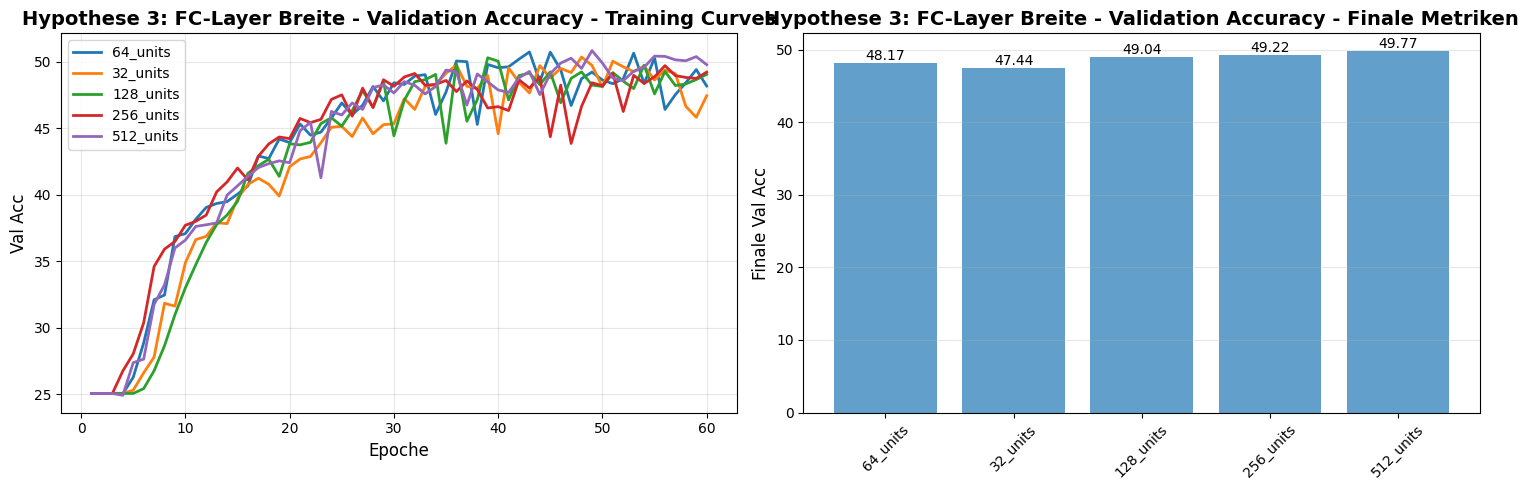

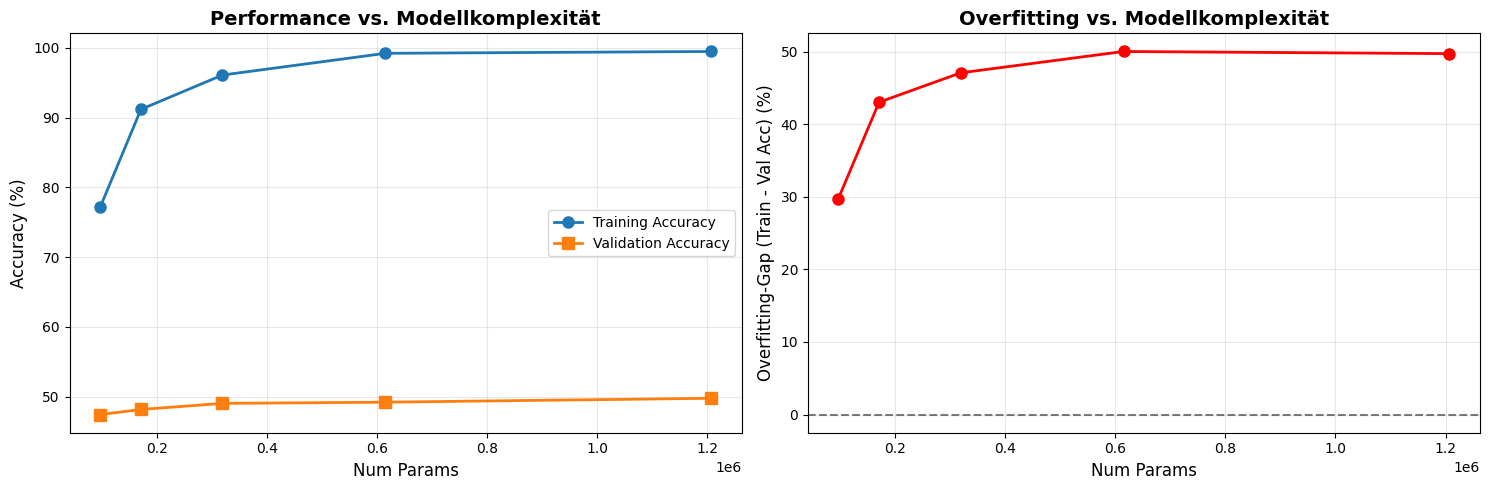

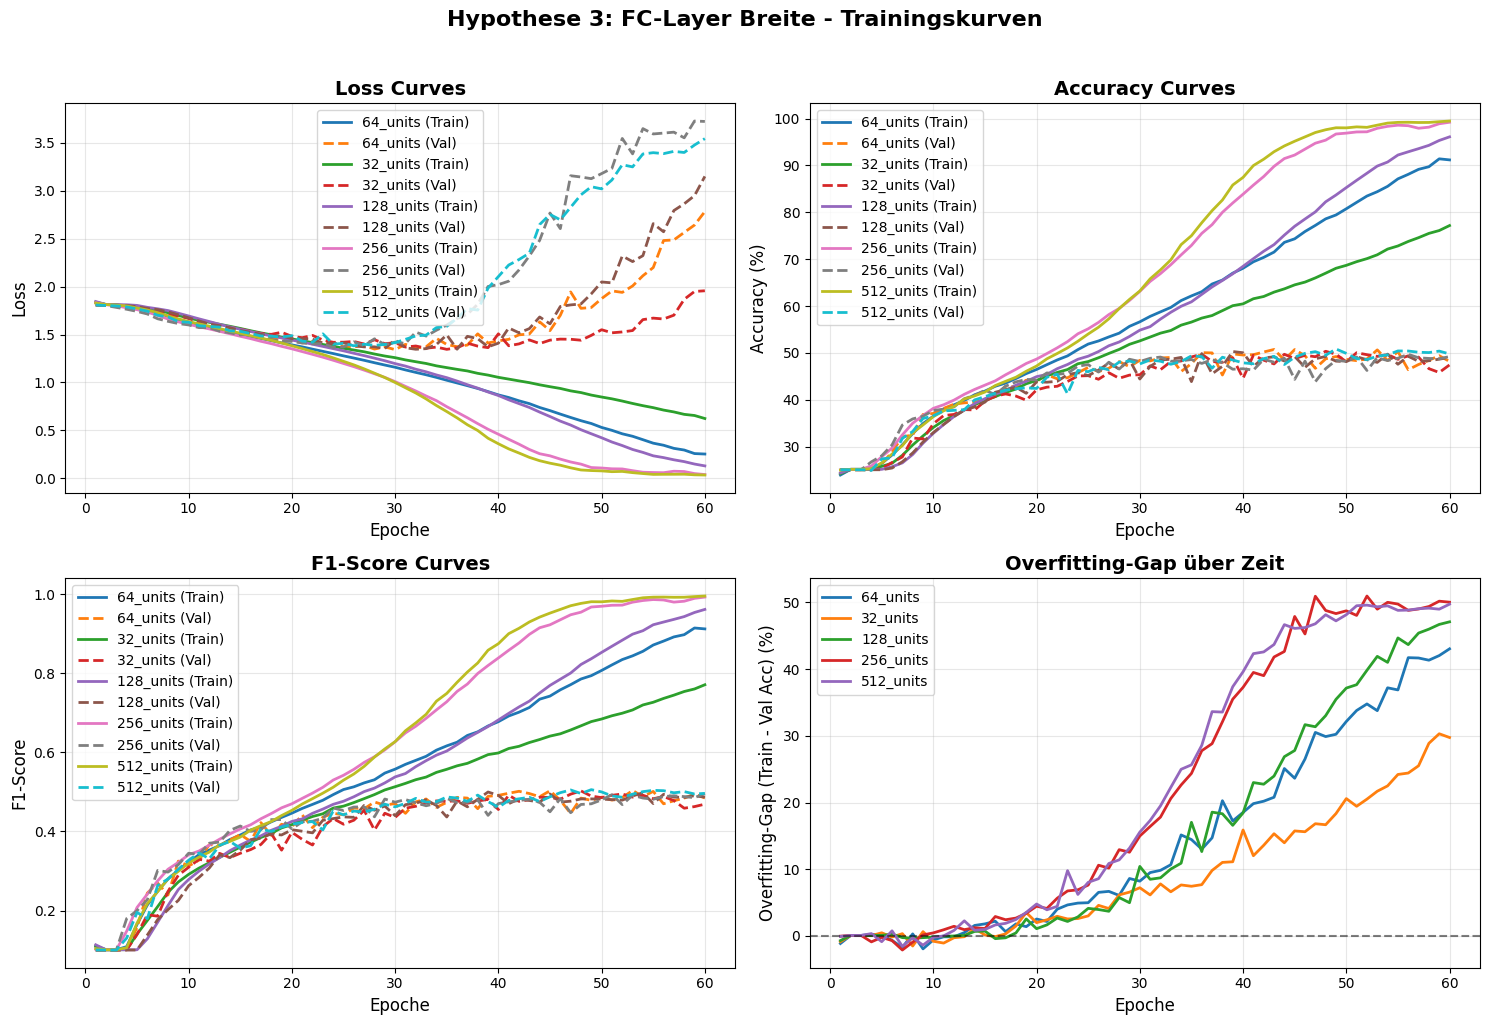

Ergebnisse gespeichert: results/hypothesis_3_fc_width.json

Ergebnisse gespeichert: results/hypothesis_3_fc_width.json


In [23]:
# Analyse und Visualisierung Hypothese 3
print("\n" + "="*80)
print("ANALYSE HYPOTHESE 3: FC-LAYER BREITE")
print("="*80)

summary_data = []
for name, result in hypothesis_3_results.items():
    summary_data.append({
        'Konfiguration': name,
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung der Ergebnisse:")
print(df_summary.to_string(index=False))

# Visualisierung
fig = plot_experiment_comparison(hypothesis_3_results, metric='val_acc', 
                                 title='Hypothese 3: FC-Layer Breite - Validation Accuracy')
plt.savefig('plots/experiments/hyp3_fc_width_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_model_complexity_analysis(hypothesis_3_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp3_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_training_curves_comparison(hypothesis_3_results, 
                                     title='Hypothese 3: FC-Layer Breite - Trainingskurven')
plt.savefig('plots/experiments/hyp3_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Ergebnisse speichern
save_experiment_results(hypothesis_3_results, 'results/hypothesis_3_fc_width.json')
print("\nErgebnisse gespeichert: results/hypothesis_3_fc_width.json")

### Zusammenfassung Kategorie 1

ZUSAMMENFASSUNG: KATEGORIE 1 - MODELLKOMPLEXITÄT

Beste Konfigurationen pro Hypothese:
Hypothese             Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
Hyp1_Best              hyp1_4layers   171,399             50.85              48.24               39.00
Hyp2_Best hyp2_very_wide_64_128_256   960,007             52.94              52.94               46.06
Hyp3_Best            hyp3_512_units 1,207,047             50.84              49.77               49.72

GESAMTBESTE KONFIGURATION: Hyp2_Best
Experiment: hyp2_very_wide_64_128_256
Beste Validation Accuracy: 52.94%
Finale Validation Accuracy: 52.94%
Overfitting-Gap: 46.06%
Modell-Parameter: 960,007


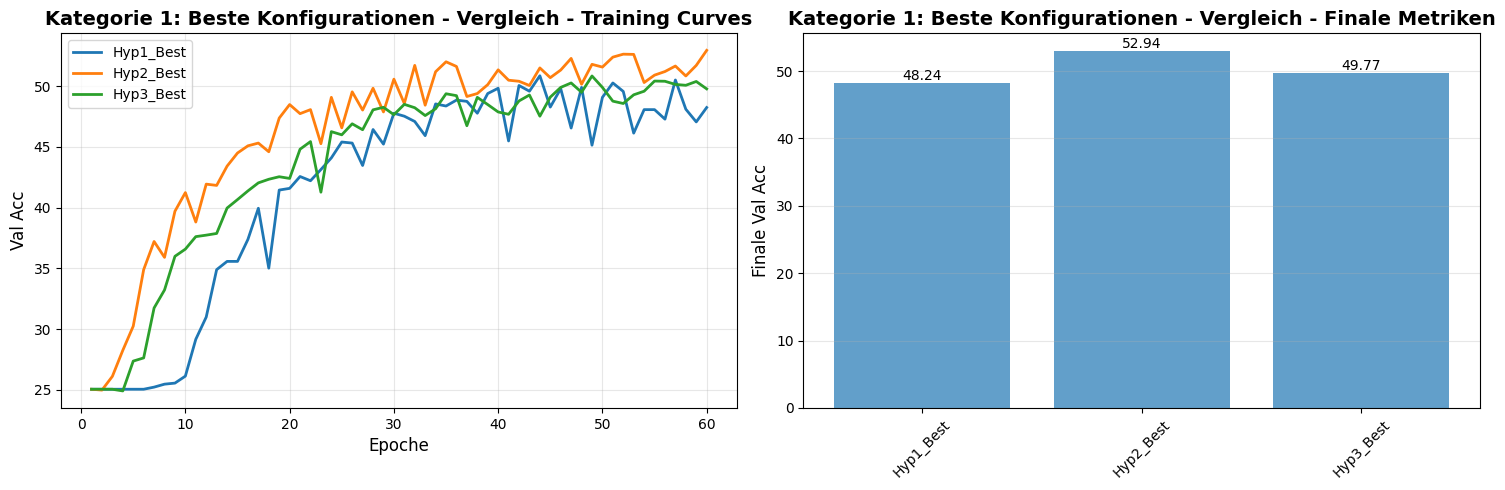

Ergebnisse gespeichert: results/category1_all_results.json

Alle Ergebnisse gespeichert: results/category1_all_results.json


In [24]:
# Zusammenfassung aller Experimente
print("="*80)
print("ZUSAMMENFASSUNG: KATEGORIE 1 - MODELLKOMPLEXITÄT")
print("="*80)

# Beste Konfigurationen aus jeder Hypothese
best_hyp1 = max(hypothesis_1_results.keys(), 
                key=lambda k: hypothesis_1_results[k]['best_val_acc'])
best_hyp2 = max(hypothesis_2_results.keys(), 
                key=lambda k: hypothesis_2_results[k]['best_val_acc'])
best_hyp3 = max(hypothesis_3_results.keys(), 
                key=lambda k: hypothesis_3_results[k]['best_val_acc'])

summary_all = {
    'Hyp1_Best': hypothesis_1_results[best_hyp1],
    'Hyp2_Best': hypothesis_2_results[best_hyp2],
    'Hyp3_Best': hypothesis_3_results[best_hyp3]
}

# Vergleichstabelle
comparison_data = []
for name, result in summary_all.items():
    comparison_data.append({
        'Hypothese': name,
        'Konfiguration': result['experiment_name'],
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBeste Konfigurationen pro Hypothese:")
print(df_comparison.to_string(index=False))

# Gesamtbeste Konfiguration
overall_best = max(summary_all.keys(), 
                  key=lambda k: summary_all[k]['best_val_acc'])
overall_best_result = summary_all[overall_best]

print(f"\n{'='*80}")
print(f"GESAMTBESTE KONFIGURATION: {overall_best}")
print(f"{'='*80}")
print(f"Experiment: {overall_best_result['experiment_name']}")
print(f"Beste Validation Accuracy: {overall_best_result['best_val_acc']:.2f}%")
print(f"Finale Validation Accuracy: {overall_best_result['final_val_acc']:.2f}%")
print(f"Overfitting-Gap: {overall_best_result['overfitting_gap_acc']:.2f}%")
print(f"Modell-Parameter: {overall_best_result['num_params']:,}")

# Visualisierung aller besten Konfigurationen
fig = plot_experiment_comparison(summary_all, metric='val_acc', 
                                 title='Kategorie 1: Beste Konfigurationen - Vergleich')
plt.savefig('plots/experiments/category1_best_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Alle Ergebnisse speichern
all_results = {
    'hypothesis_1': hypothesis_1_results,
    'hypothesis_2': hypothesis_2_results,
    'hypothesis_3': hypothesis_3_results,
    'summary': {
        'best_hyp1': best_hyp1,
        'best_hyp2': best_hyp2,
        'best_hyp3': best_hyp3,
        'overall_best': overall_best
    }
}

save_experiment_results(all_results, 'results/category1_all_results.json')
print("\nAlle Ergebnisse gespeichert: results/category1_all_results.json")

## Hyperparameter-Experimente: Kategorie 2 - Conv-Layer Settings

**Übersicht:**
- **Hypothese 4 (Kernel-Größe / rezeptives Feld):** Nur die Kernel-Größe variieren (3×3 Baseline, 5×5, 7×7)
- **Hypothese 5:** Variiert nur die Pooling-Strategie (MaxPool2d, AvgPool2d, AdaptiveAvgPool2d)

**Baseline-Parameter für alle Experimente:**
- 3 Conv-Layer
- Filter [16, 32, 64]
- FC-Layer 64 Neuronen
- LR=0.01, Batch=32, 60 Epochen

### Hypothese 4: Kernel-Größe (Rezeptives Feld)
**Variiert (OFAT):** Kernel‑Größe (3×3 Baseline, 5×5, 7×7)  
**Konstant:** 3 Conv‑Layer, Filter [16, 32, 64], FC‑Layer 64 Neuronen, MaxPool2d

In [25]:
# Hypothese 4 Ergebnisse initialisieren
hypothesis_4_file = 'results/hypothesis_4_kernel_size.json'
hypothesis_4_results = {}

# Experiment 4.1: Baseline (3x3 Kernel)
print("\n" + "-"*60)
print("Experiment 4.1: Baseline (3x3 Kernel)")
print("Kernel Size: 3x3 (Baseline)")
print("Pooling: MaxPool2d(2x2)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
baseline_results_hyp4 = copy.deepcopy(baseline_results)
baseline_results_hyp4['experiment_name'] = 'hyp4_baseline_3x3_kernel'
hypothesis_4_results['kernel_3x3'] = baseline_results_hyp4

# Automatisch speichern
save_hypothesis_results(hypothesis_4_results, hypothesis_4_file)

# Experiment 4.2: 5x5 Kernel
print("\n" + "-"*60)
print("Experiment 4.2: 5x5 Kernel")
print("Kernel Size: 5x5")
print("Pooling: MaxPool2d(2x2)")
print("-"*60)

result_5x5 = run_hyperparameter_experiment(
    experiment_name='hyp4_5x5_kernel',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 5,
        'fc_units': 64,
        'pooling_type': 'max'
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_4_results['kernel_5x5'] = result_5x5
save_hypothesis_results(hypothesis_4_results, hypothesis_4_file)

# Experiment 4.3: 7x7 Kernel
print("\n" + "-"*60)
print("Experiment 4.3: 7x7 Kernel")
print("Kernel Size: 7x7")
print("Pooling: MaxPool2d(2x2)")
print("-"*60)

result_7x7 = run_hyperparameter_experiment(
    experiment_name='hyp4_7x7_kernel',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 7,
        'fc_units': 64,
        'pooling_type': 'max'
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_4_results['kernel_7x7'] = result_7x7
save_hypothesis_results(hypothesis_4_results, hypothesis_4_file)



------------------------------------------------------------
Experiment 4.1: Baseline (3x3 Kernel)
Kernel Size: 3x3 (Baseline)
Pooling: MaxPool2d(2x2)
------------------------------------------------------------
Ergebnisse gespeichert: results/hypothesis_4_kernel_size.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_4_kernel_size.json

------------------------------------------------------------
Experiment 4.2: 5x5 Kernel
Kernel Size: 5x5
Pooling: MaxPool2d(2x2)
------------------------------------------------------------

EXPERIMENT: hyp4_5x5_kernel
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 5, 'fc_units': 64, 'pooling_type': 'max'}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 212,487 total, 212,487 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8335 | Val Loss: 1.8087 | Train Acc: 25.14% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7161 | Val Loss: 1.6906 | Train Acc: 31.55% | Val Acc: 32.78%
Epoch  10/60 | Train Loss: 1.5377 | Val Loss: 1.5196 | Train Acc: 40.66% | Val Acc: 40.79%
Epoch  15/60 | Train Loss: 1.4021 | Val Loss: 1.4292 | Train Acc: 46.34% | Val Acc: 45.30%
Epoch  20/60 | Train Loss: 1.2595 | Val Loss: 1.4031 | Train Acc: 52.40% | Val Acc: 46.10%
Epoch  25/60 | Train Loss: 1.1013 | Val Loss: 1.3879 | Train Acc: 58.90% | Val Acc: 48.00%
Epoch  30/60 | Train Loss: 0.9185 | Val Loss: 1.4305 | Train Acc: 66.40% | Val Acc: 48.87%
Epoch  35/60 | Train Loss: 0.7109 | Val Loss: 1.5553 | Train Acc: 74.38% | Val Acc: 49.32%
Epoch  40/60 | Train Loss: 0.4856 | Val Loss: 1.9260 | Train Acc: 82.53% | Val Acc: 49.86%
Epoch  45/60 | Train Loss: 0.2994 | Val Loss: 2.3720 | Train Acc: 89.63%


ERGEBNISSE: hyp4_5x5_kernel
Beste Validation Accuracy: 50.38% (Epoche 58)
Finale Validation Accuracy: 50.07%
Finale Validation F1-Score: 0.4993
Overfitting-Gap (Acc): 47.76%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_4_kernel_size.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_4_kernel_size.json

------------------------------------------------------------
Experiment 4.3: 7x7 Kernel
Kernel Size: 7x7
Pooling: MaxPool2d(2x2)
------------------------------------------------------------

EXPERIMENT: hyp4_7x7_kernel
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 7, 'fc_units': 64, 'pooling_type': 'max'}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 274,311 total, 274,311 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8375 | Val Loss: 1.8065 | Train Acc: 24.05% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7632 | Val Loss: 1.7228 | Train Acc: 28.40% | Val Acc: 30.41%
Epoch  10/60 | Train Loss: 1.5486 | Val Loss: 1.5281 | Train Acc: 40.51% | Val Acc: 40.42%
Epoch  15/60 | Train Loss: 1.3919 | Val Loss: 1.4359 | Train Acc: 46.71% | Val Acc: 44.32%
Epoch  20/60 | Train Loss: 1.2227 | Val Loss: 1.4210 | Train Acc: 54.06% | Val Acc: 45.87%
Epoch  25/60 | Train Loss: 1.0106 | Val Loss: 1.4419 | Train Acc: 62.82% | Val Acc: 48.03%
Epoch  30/60 | Train Loss: 0.7493 | Val Loss: 1.6605 | Train Acc: 72.73% | Val Acc: 45.54%
Epoch  35/60 | Train Loss: 0.4817 | Val Loss: 2.1007 | Train Acc: 83.03% | Val Acc: 47.06%
Epoch  40/60 | Train Loss: 0.2796 | Val Loss: 2.8507 | Train Acc: 90.15% | Val Acc: 43.90%
Epoch  45/60 | Train Loss: 0.1600 | Val Loss: 3.2934 | Train Acc: 94.70%


ERGEBNISSE: hyp4_7x7_kernel
Beste Validation Accuracy: 49.13% (Epoche 50)
Finale Validation Accuracy: 48.83%
Finale Validation F1-Score: 0.4830
Overfitting-Gap (Acc): 49.66%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_4_kernel_size.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_4_kernel_size.json


ANALYSE HYPOTHESE 4: KERNEL SIZE

Zusammenfassung Hypothese 4:
Kernel Size Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
        3×3   171,271             50.73              48.17               43.02
        5×5   212,487             50.38              50.07               47.76
        7×7   274,311             49.13              48.83               49.66


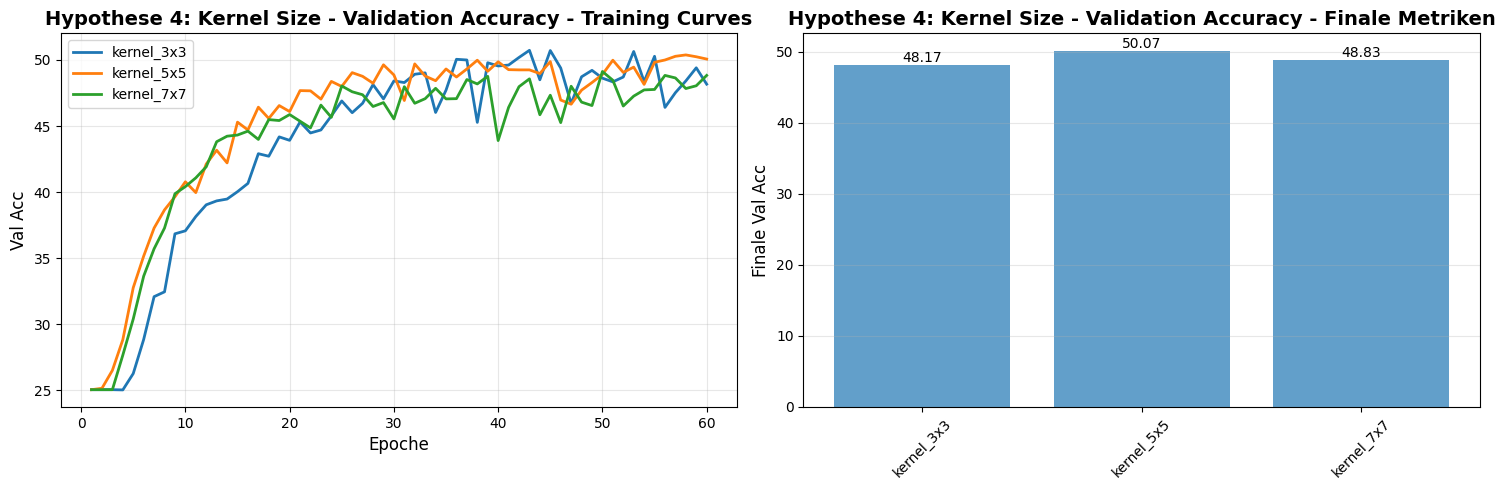

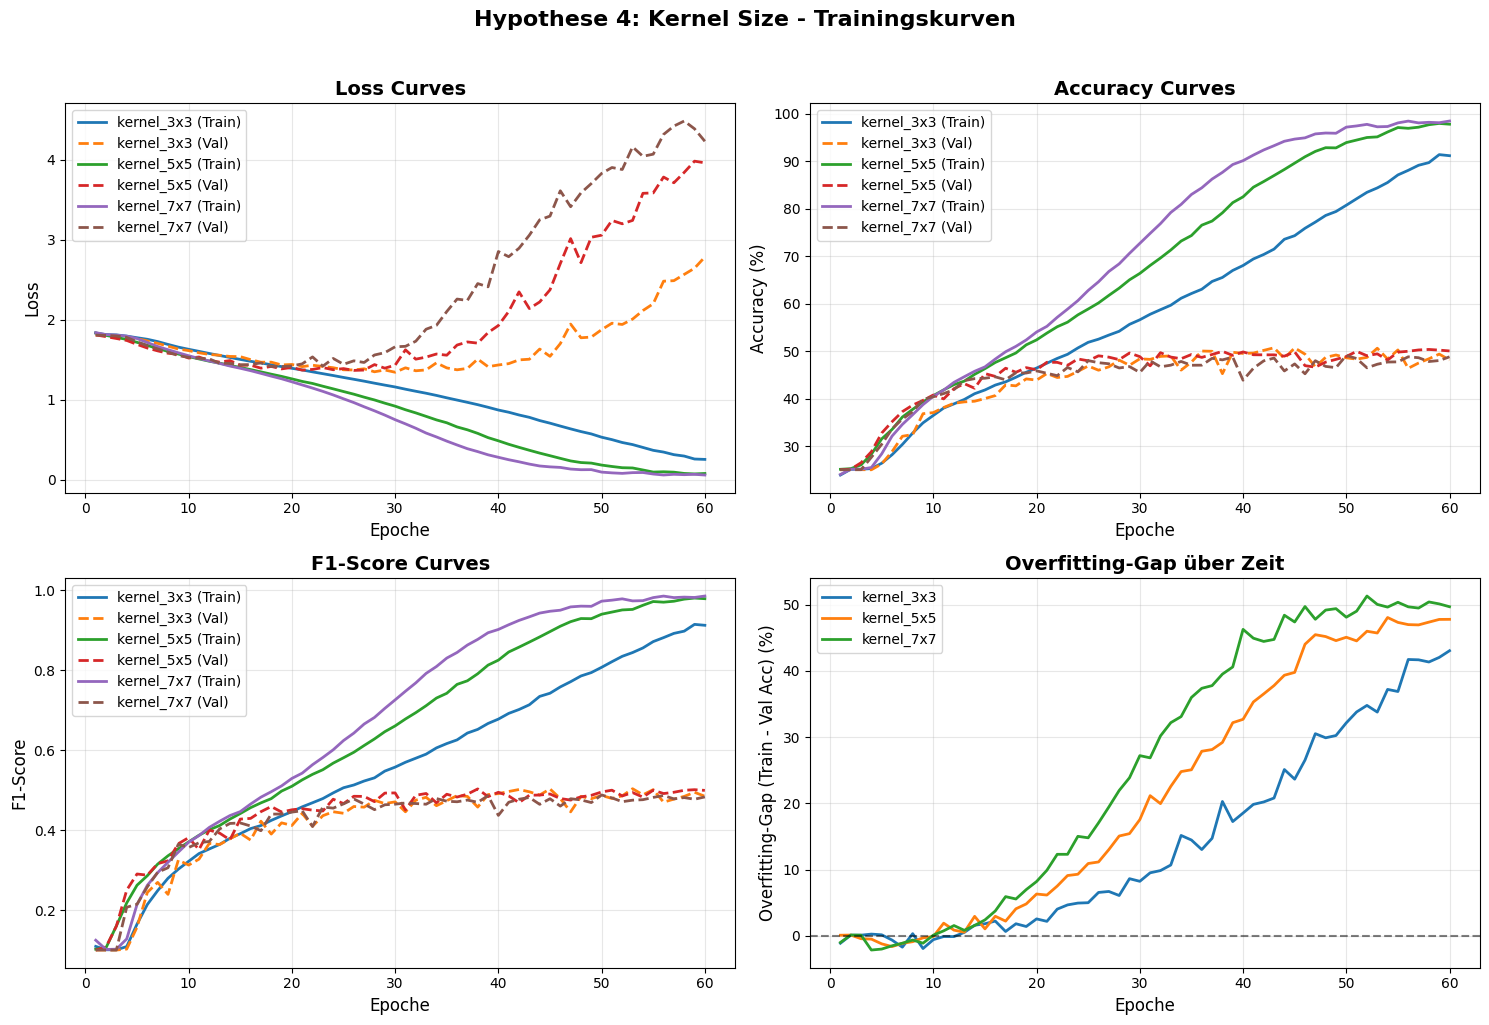

In [26]:
# Analyse und Visualisierung Hypothese 4
print("="*80)
print("ANALYSE HYPOTHESE 4: KERNEL SIZE")
print("="*80)

# Vergleichstabelle
summary_data = []
for name, result in hypothesis_4_results.items():
    summary_data.append({
        'Kernel Size': name.replace('kernel_', '').replace('x', '×'),
        'Parameter': f"{result.get('num_params', 0):,}",
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung Hypothese 4:")
print(df_summary.to_string(index=False))

# Plots
plot_experiment_comparison(hypothesis_4_results, metric='val_acc',
                         title='Hypothese 4: Kernel Size - Validation Accuracy')
plt.savefig('plots/experiments/hyp4_kernel_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_model_complexity_analysis(hypothesis_4_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp4_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_4_results,
                                title='Hypothese 4: Kernel Size - Trainingskurven')
plt.savefig('plots/experiments/hyp4_kernel_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Hypothese 5: Pooling-Strategie

**Hypothese:** Die Pooling‑Wahl verändert, wie stark räumliche Informationen verdichtet werden. Wir erwarten, dass **MaxPool2d** (Baseline) die stärksten diskriminativen Aktivierungen betont und daher **mindestens gleich gut** abschneidet wie AvgPool2d; **AvgPool2d** könnte dafür einen kleineren Overfitting‑Gap zeigen. In unserem Setup bedeutet **AdaptiveAvgPool2d**: *kein* Pooling zwischen den Conv‑Layern, sondern erst am Ende eine Reduktion auf 6×6 – das kann mehr Detailinformation erhalten, ist aber rechenintensiver und nicht zwingend besser.

**Variiert (OFAT):** Nur die Pooling‑Strategie (MaxPool2d Baseline, AvgPool2d, AdaptiveAvgPool2d)  
**Konstant:** 3 Conv‑Layer, Filter [16, 32, 64], FC‑Layer 64 Neuronen, Kernel 3×3, LR=0.01, Batch=32, 60 Epochen, SGD (momentum=0)


------------------------------------------------------------
Experiment 5.1: Baseline (MaxPool2d)
Pooling: MaxPool2d(2x2) (Baseline)
Kernel Size: 3x3
------------------------------------------------------------
Baseline-Ergebnisse:
  - Beste Val Acc: 50.73% (Epoche 43)
  - Finale Val Acc: 48.17%
Ergebnisse gespeichert: results/hypothesis_5_pooling.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_5_pooling.json

------------------------------------------------------------
Experiment 5.2: AvgPool2d
Pooling: AvgPool2d(2x2)
Kernel Size: 3x3
------------------------------------------------------------

EXPERIMENT: hyp5_avgpool
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'avg'}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8363 | Val Loss: 1.8089 | Train Acc: 24.17% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7573 | Val Loss: 1.7431 | Train Acc: 27.66% | Val Acc: 28.65%
Epoch  10/60 | Train Loss: 1.6467 | Val Loss: 1.6415 | Train Acc: 35.69% | Val Acc: 35.44%
Epoch  15/60 | Train Loss: 1.5813 | Val Loss: 1.5751 | Train Acc: 38.59% | Val Acc: 38.37%
Epoch  20/60 | Train Loss: 1.5207 | Val Loss: 1.5774 | Train Acc: 41.52% | Val Acc: 38.71%
Epoch  25/60 | Train Loss: 1.4668 | Val Loss: 1.5178 | Train Acc: 43.99% | Val Acc: 40.98%
Epoch  30/60 | Train Loss: 1.4090 | Val Loss: 1.4966 | Train Acc: 46.18% | Val Acc: 42.82%
Epoch  35/60 | Train Loss: 1.3515 | Val Loss: 1.5038 | Train Acc: 48.73% | Val Acc: 41.78%
Epoch  40/60 | Train Loss: 1.2850 | Val Loss: 1.5075 | Train Acc: 51.23% | Val Acc: 43.52%
Epoch  45/60 | Train Loss: 1.2204 | Val Loss: 1.5346 | Train Acc: 54.40%


ERGEBNISSE: hyp5_avgpool
Beste Validation Accuracy: 44.50% (Epoche 58)
Finale Validation Accuracy: 43.97%
Finale Validation F1-Score: 0.4405
Overfitting-Gap (Acc): 19.62%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_5_pooling.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_5_pooling.json

------------------------------------------------------------
Experiment 5.3: AdaptiveAvgPool2d
Pooling: AdaptiveAvgPool2d(6x6)
Kernel Size: 3x3
------------------------------------------------------------

EXPERIMENT: hyp5_adaptive_pool
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'adaptive'}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8393 | Val Loss: 1.8127 | Train Acc: 24.98% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7424 | Val Loss: 1.7216 | Train Acc: 29.68% | Val Acc: 30.77%
Epoch  10/60 | Train Loss: 1.6801 | Val Loss: 1.6670 | Train Acc: 33.81% | Val Acc: 33.73%
Epoch  15/60 | Train Loss: 1.6413 | Val Loss: 1.6266 | Train Acc: 35.70% | Val Acc: 36.50%
Epoch  20/60 | Train Loss: 1.5927 | Val Loss: 1.5888 | Train Acc: 38.08% | Val Acc: 38.26%
Epoch  25/60 | Train Loss: 1.5442 | Val Loss: 1.5717 | Train Acc: 40.36% | Val Acc: 38.49%
Epoch  30/60 | Train Loss: 1.4956 | Val Loss: 1.5276 | Train Acc: 42.36% | Val Acc: 40.84%
Epoch  35/60 | Train Loss: 1.4392 | Val Loss: 1.5008 | Train Acc: 44.74% | Val Acc: 42.25%
Epoch  40/60 | Train Loss: 1.3756 | Val Loss: 1.4626 | Train Acc: 47.37% | Val Acc: 43.19%
Epoch  45/60 | Train Loss: 1.3165 | Val Loss: 1.4563 | Train Acc: 49.82%


ERGEBNISSE: hyp5_adaptive_pool
Beste Validation Accuracy: 47.25% (Epoche 54)
Finale Validation Accuracy: 45.89%
Finale Validation F1-Score: 0.4591
Overfitting-Gap (Acc): 11.48%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_5_pooling.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_5_pooling.json
ANALYSE HYPOTHESE 5: POOLING-STRATEGIE

Zusammenfassung Hypothese 5:
 Pooling Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
 Maxpool   171,271             50.73              48.17               43.02
 Avgpool   171,271             44.50              43.97               19.62
Adaptive   171,271             47.25              45.89               11.48


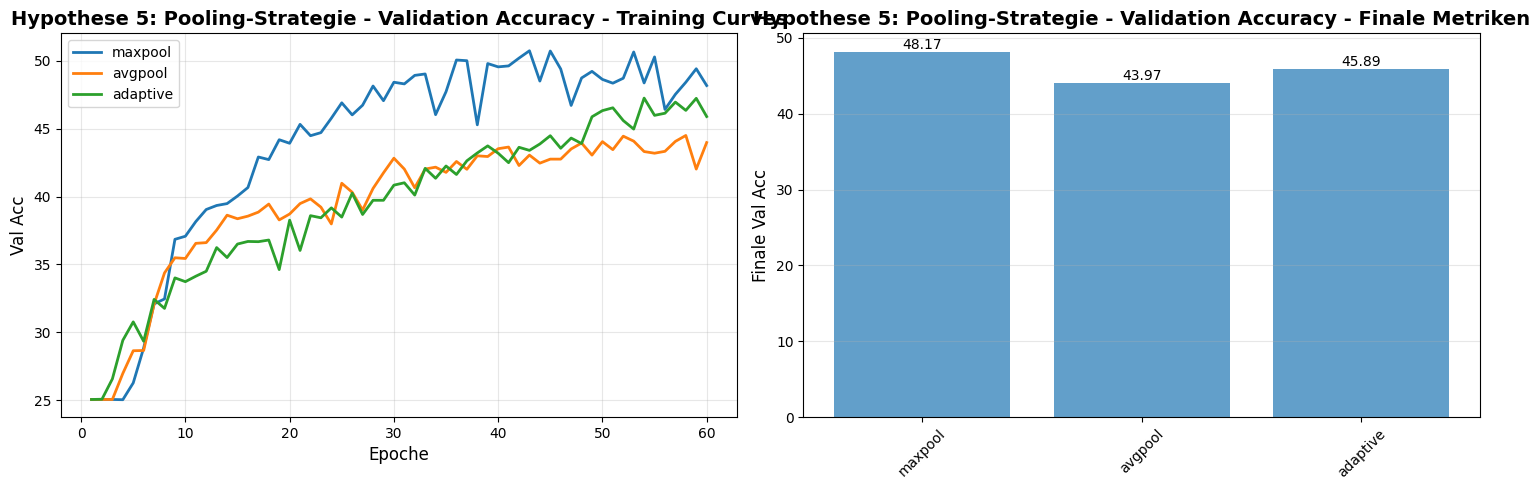

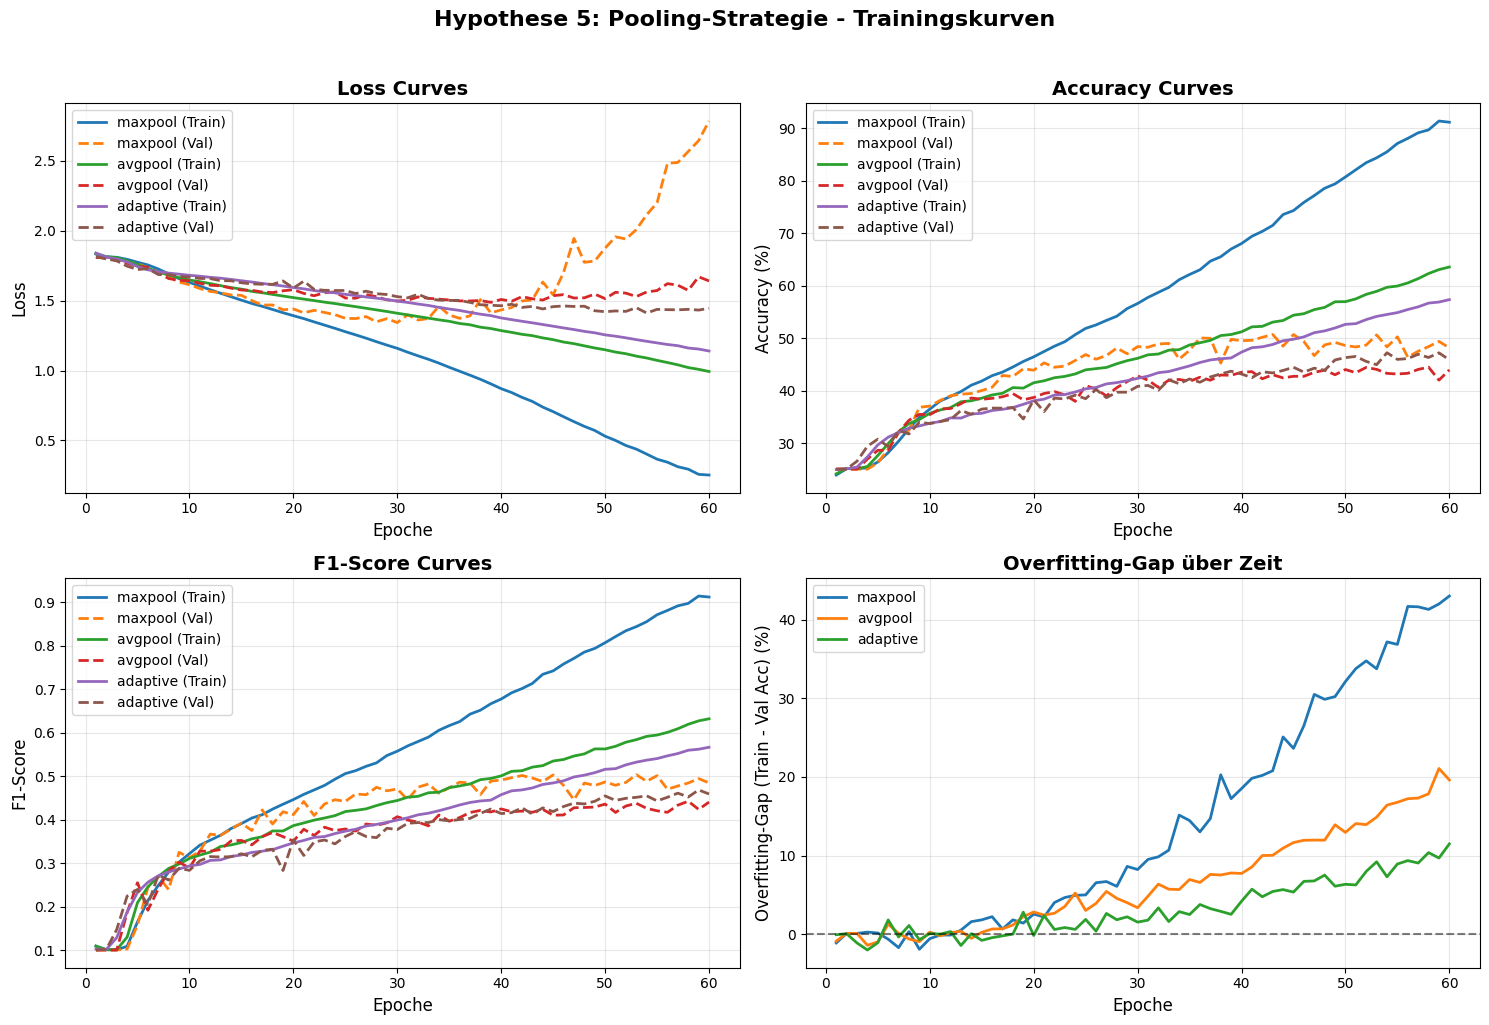

In [27]:
# Hypothese 5 Ergebnisse initialisieren
hypothesis_5_file = 'results/hypothesis_5_pooling.json'
hypothesis_5_results = {}

# Experiment 5.1: Baseline (MaxPool2d)
print("\n" + "-"*60)
print("Experiment 5.1: Baseline (MaxPool2d)")
print("Pooling: MaxPool2d(2x2) (Baseline)")
print("Kernel Size: 3x3")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
baseline_results_hyp5 = copy.deepcopy(baseline_results)
baseline_results_hyp5['experiment_name'] = 'hyp5_baseline_maxpool'
hypothesis_5_results['maxpool'] = baseline_results_hyp5

print(f"Baseline-Ergebnisse:")
print(f"  - Beste Val Acc: {baseline_results_hyp5['best_val_acc']:.2f}% (Epoche {baseline_results_hyp5['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results_hyp5['final_val_acc']:.2f}%")

# Automatisch speichern
save_hypothesis_results(hypothesis_5_results, hypothesis_5_file)

# Experiment 5.2: AvgPool2d
print("\n" + "-"*60)
print("Experiment 5.2: AvgPool2d")
print("Pooling: AvgPool2d(2x2)")
print("Kernel Size: 3x3")
print("-"*60)

result_avgpool = run_hyperparameter_experiment(
    experiment_name='hyp5_avgpool',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 3,
        'fc_units': 64,
        'pooling_type': 'avg'
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_5_results['avgpool'] = result_avgpool
save_hypothesis_results(hypothesis_5_results, hypothesis_5_file)

# Experiment 5.3: AdaptiveAvgPool2d
print("\n" + "-"*60)
print("Experiment 5.3: AdaptiveAvgPool2d")
print("Pooling: AdaptiveAvgPool2d(6x6)")
print("Kernel Size: 3x3")
print("-"*60)

result_adaptive = run_hyperparameter_experiment(
    experiment_name='hyp5_adaptive_pool',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 3,
        'fc_units': 64,
        'pooling_type': 'adaptive'
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_5_results['adaptive'] = result_adaptive
save_hypothesis_results(hypothesis_5_results, hypothesis_5_file)

# Analyse und Visualisierung Hypothese 5
print("="*80)
print("ANALYSE HYPOTHESE 5: POOLING-STRATEGIE")
print("="*80)

# Vergleichstabelle
summary_data = []
for name, result in hypothesis_5_results.items():
    summary_data.append({
        'Pooling': name.replace('pool', 'Pool').title(),
        'Parameter': f"{result.get('num_params', 0):,}",
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung Hypothese 5:")
print(df_summary.to_string(index=False))

# Plots
plot_experiment_comparison(hypothesis_5_results, metric='val_acc',
                         title='Hypothese 5: Pooling-Strategie - Validation Accuracy')
plt.savefig('plots/experiments/hyp5_pooling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_5_results,
                                title='Hypothese 5: Pooling-Strategie - Trainingskurven')
plt.savefig('plots/experiments/hyp5_pooling_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Zusammenfassung Kategorie 2

ZUSAMMENFASSUNG: KATEGORIE 2 - CONV-LAYER SETTINGS

Beste Konfigurationen pro Hypothese:
Hypothese            Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
Hyp4_Best hyp4_baseline_3x3_kernel   171,271             50.73              48.17               43.02
Hyp5_Best    hyp5_baseline_maxpool   171,271             50.73              48.17               43.02

GESAMTBESTE KONFIGURATION: Hyp4_Best
Experiment: hyp4_baseline_3x3_kernel
Beste Validation Accuracy: 50.73%
Finale Validation Accuracy: 48.17%
Overfitting-Gap: 43.02%
Modell-Parameter: 171,271


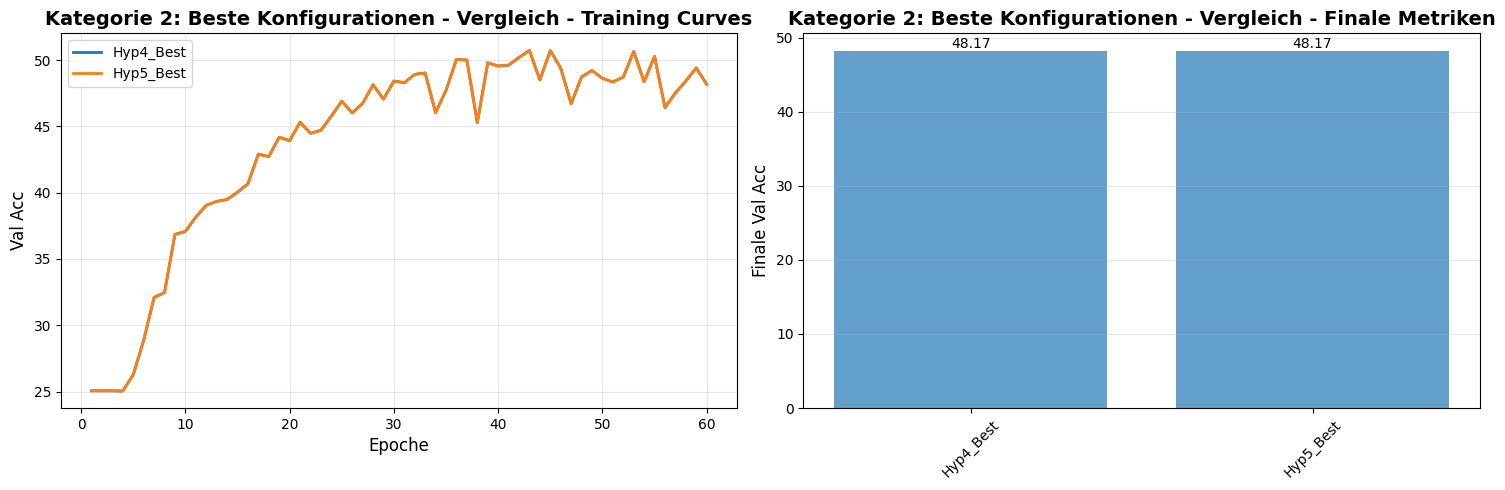

Ergebnisse gespeichert: results/category2_all_results.json

Alle Ergebnisse gespeichert: results/category2_all_results.json


In [28]:
# Zusammenfassung aller Experimente Kategorie 2
print("="*80)
print("ZUSAMMENFASSUNG: KATEGORIE 2 - CONV-LAYER SETTINGS")
print("="*80)

# Beste Konfigurationen aus jeder Hypothese
best_hyp4 = max(hypothesis_4_results.keys(), 
                key=lambda k: hypothesis_4_results[k]['best_val_acc'])
best_hyp5 = max(hypothesis_5_results.keys(), 
                key=lambda k: hypothesis_5_results[k]['best_val_acc'])

summary_all = {
    'Hyp4_Best': hypothesis_4_results[best_hyp4],
    'Hyp5_Best': hypothesis_5_results[best_hyp5]
}

# Vergleichstabelle
comparison_data = []
for name, result in summary_all.items():
    comparison_data.append({
        'Hypothese': name,
        'Konfiguration': result['experiment_name'],
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBeste Konfigurationen pro Hypothese:")
print(df_comparison.to_string(index=False))

# Gesamtbeste Konfiguration
overall_best = max(summary_all.keys(), 
                  key=lambda k: summary_all[k]['best_val_acc'])
overall_best_result = summary_all[overall_best]

print(f"\n{'='*80}")
print(f"GESAMTBESTE KONFIGURATION: {overall_best}")
print(f"{'='*80}")
print(f"Experiment: {overall_best_result['experiment_name']}")
print(f"Beste Validation Accuracy: {overall_best_result['best_val_acc']:.2f}%")
print(f"Finale Validation Accuracy: {overall_best_result['final_val_acc']:.2f}%")
print(f"Overfitting-Gap: {overall_best_result['overfitting_gap_acc']:.2f}%")
print(f"Modell-Parameter: {overall_best_result['num_params']:,}")

# Visualisierung aller besten Konfigurationen
fig = plot_experiment_comparison(summary_all, metric='val_acc', 
                                 title='Kategorie 2: Beste Konfigurationen - Vergleich')
plt.savefig('plots/experiments/category2_best_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Alle Ergebnisse speichern
all_results = {
    'hypothesis_4': hypothesis_4_results,
    'hypothesis_5': hypothesis_5_results,
    'summary': {
        'best_hyp4': best_hyp4,
        'best_hyp5': best_hyp5,
        'overall_best': overall_best
    }
}

save_experiment_results(all_results, 'results/category2_all_results.json')
print("\nAlle Ergebnisse gespeichert: results/category2_all_results.json")

## Hyperparameter-Experimente: Kategorie 3 - Regularisierung

**Übersicht:**
- **Hypothese 6:** Variiert nur Dropout-Rate (0.0, 0.2, 0.3, 0.5)
- **Hypothese 7:** Variiert Data Augmentation (keine, Rotation, Flip, Translation, Kombination)

**Baseline-Parameter für alle Experimente:**
- 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen
- Kernel 3x3, MaxPool2d
- LR=0.01, Batch=32, 60 Epochen, SGD

### Hypothese 6: Dropout

**Variiert:** Nur die Dropout-Rate (0.0 Baseline, 0.2, 0.3, 0.5)  
**Konstant:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen, Kernel 3x3, MaxPool2d

In [29]:
# Hypothese 6 Ergebnisse initialisieren
hypothesis_6_file = 'results/hypothesis_6_dropout.json'
hypothesis_6_results = {}

# Experiment 6.1: Baseline (kein Dropout)
print("\n" + "-"*60)
print("Experiment 6.1: Baseline (kein Dropout)")
print("Dropout: 0.0 (Baseline)")
print("-"*60)

# Baseline-Ergebnisse wiederverwenden
baseline_results_hyp6 = copy.deepcopy(baseline_results)
baseline_results_hyp6['experiment_name'] = 'hyp6_baseline_no_dropout'
hypothesis_6_results['dropout_0.0'] = baseline_results_hyp6

print(f"Baseline-Ergebnisse:")
print(f"  - Beste Val Acc: {baseline_results_hyp6['best_val_acc']:.2f}% (Epoche {baseline_results_hyp6['best_epoch']})")
print(f"  - Finale Val Acc: {baseline_results_hyp6['final_val_acc']:.2f}%")

save_hypothesis_results(hypothesis_6_results, hypothesis_6_file)

# Experiment 6.2-6.4: Dropout 0.2, 0.3, 0.5
dropout_rates = [0.2, 0.3, 0.5]

for dropout_rate in dropout_rates:
    print("\n" + "-"*60)
    print(f"Experiment 6.{dropout_rates.index(dropout_rate)+2}: Dropout {dropout_rate}")
    print(f"Dropout: {dropout_rate}")
    print("-"*60)
    
    result = run_hyperparameter_experiment(
        experiment_name=f'hyp6_dropout_{dropout_rate}',
        model_class=FlexibleCNN,
        model_kwargs={
            'img_size': img_size,
            'num_classes': num_classes,
            'num_conv_layers': 3,
            'filters_per_layer': [16, 32, 64],
            'kernel_size': 3,
            'fc_units': 64,
            'pooling_type': 'max',
            'dropout_rate': dropout_rate,
            'use_batchnorm': False
        },
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=60,
        learning_rate=0.01,
        batch_size=32,
    
        use_wandb=True
    )
    
    hypothesis_6_results[f'dropout_{dropout_rate}'] = result
    save_hypothesis_results(hypothesis_6_results, hypothesis_6_file)



------------------------------------------------------------
Experiment 6.1: Baseline (kein Dropout)
Dropout: 0.0 (Baseline)
------------------------------------------------------------
Baseline-Ergebnisse:
  - Beste Val Acc: 50.73% (Epoche 43)
  - Finale Val Acc: 48.17%
Ergebnisse gespeichert: results/hypothesis_6_dropout.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_6_dropout.json

------------------------------------------------------------
Experiment 6.2: Dropout 0.2
Dropout: 0.2
------------------------------------------------------------

EXPERIMENT: hyp6_dropout_0.2
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.2, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8443 | Val Loss: 1.8101 | Train Acc: 23.91% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.8051 | Val Loss: 1.7889 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  10/60 | Train Loss: 1.7258 | Val Loss: 1.6875 | Train Acc: 30.48% | Val Acc: 32.65%
Epoch  15/60 | Train Loss: 1.6249 | Val Loss: 1.5955 | Train Acc: 36.33% | Val Acc: 37.58%
Epoch  20/60 | Train Loss: 1.5491 | Val Loss: 1.5121 | Train Acc: 40.48% | Val Acc: 41.07%
Epoch  25/60 | Train Loss: 1.4867 | Val Loss: 1.4576 | Train Acc: 42.80% | Val Acc: 43.45%
Epoch  30/60 | Train Loss: 1.4329 | Val Loss: 1.4179 | Train Acc: 44.93% | Val Acc: 44.93%
Epoch  35/60 | Train Loss: 1.3839 | Val Loss: 1.3843 | Train Acc: 46.79% | Val Acc: 46.73%
Epoch  40/60 | Train Loss: 1.3319 | Val Loss: 1.3493 | Train Acc: 49.21% | Val Acc: 47.81%
Epoch  45/60 | Train Loss: 1.2819 | Val Loss: 1.3196 | Train Acc: 51.24%


ERGEBNISSE: hyp6_dropout_0.2
Beste Validation Accuracy: 51.10% (Epoche 60)
Finale Validation Accuracy: 51.10%
Finale Validation F1-Score: 0.5047
Overfitting-Gap (Acc): 5.65%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_6_dropout.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_6_dropout.json

------------------------------------------------------------
Experiment 6.3: Dropout 0.3
Dropout: 0.3
------------------------------------------------------------

EXPERIMENT: hyp6_dropout_0.3
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.3, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8418 | Val Loss: 1.8094 | Train Acc: 23.68% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.8024 | Val Loss: 1.7823 | Train Acc: 25.18% | Val Acc: 25.06%
Epoch  10/60 | Train Loss: 1.7304 | Val Loss: 1.6945 | Train Acc: 30.17% | Val Acc: 32.78%
Epoch  15/60 | Train Loss: 1.6420 | Val Loss: 1.6015 | Train Acc: 35.83% | Val Acc: 37.79%
Epoch  20/60 | Train Loss: 1.5789 | Val Loss: 1.5299 | Train Acc: 38.53% | Val Acc: 40.63%
Epoch  25/60 | Train Loss: 1.5320 | Val Loss: 1.4870 | Train Acc: 40.85% | Val Acc: 42.91%
Epoch  30/60 | Train Loss: 1.4861 | Val Loss: 1.4486 | Train Acc: 42.78% | Val Acc: 43.80%
Epoch  35/60 | Train Loss: 1.4488 | Val Loss: 1.4177 | Train Acc: 44.26% | Val Acc: 45.25%
Epoch  40/60 | Train Loss: 1.4127 | Val Loss: 1.3823 | Train Acc: 45.77% | Val Acc: 47.04%
Epoch  45/60 | Train Loss: 1.3832 | Val Loss: 1.3667 | Train Acc: 46.81%


ERGEBNISSE: hyp6_dropout_0.3
Beste Validation Accuracy: 50.26% (Epoche 60)
Finale Validation Accuracy: 50.26%
Finale Validation F1-Score: 0.4857
Overfitting-Gap (Acc): 0.57%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_6_dropout.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_6_dropout.json

------------------------------------------------------------
Experiment 6.4: Dropout 0.5
Dropout: 0.5
------------------------------------------------------------

EXPERIMENT: hyp6_dropout_0.5
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.5, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8507 | Val Loss: 1.8231 | Train Acc: 23.97% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.8127 | Val Loss: 1.8080 | Train Acc: 25.14% | Val Acc: 25.06%
Epoch  10/60 | Train Loss: 1.8017 | Val Loss: 1.7926 | Train Acc: 25.14% | Val Acc: 25.06%
Epoch  15/60 | Train Loss: 1.7828 | Val Loss: 1.7664 | Train Acc: 25.95% | Val Acc: 25.30%
Epoch  20/60 | Train Loss: 1.7253 | Val Loss: 1.6824 | Train Acc: 30.70% | Val Acc: 32.31%
Epoch  25/60 | Train Loss: 1.6738 | Val Loss: 1.6193 | Train Acc: 34.01% | Val Acc: 36.96%
Epoch  30/60 | Train Loss: 1.6320 | Val Loss: 1.5770 | Train Acc: 36.14% | Val Acc: 39.38%
Epoch  35/60 | Train Loss: 1.5983 | Val Loss: 1.5382 | Train Acc: 37.29% | Val Acc: 40.87%
Epoch  40/60 | Train Loss: 1.5732 | Val Loss: 1.5091 | Train Acc: 38.37% | Val Acc: 41.47%
Epoch  45/60 | Train Loss: 1.5558 | Val Loss: 1.4773 | Train Acc: 39.60%


ERGEBNISSE: hyp6_dropout_0.5
Beste Validation Accuracy: 44.91% (Epoche 57)
Finale Validation Accuracy: 44.51%
Finale Validation F1-Score: 0.3988
Overfitting-Gap (Acc): -2.27%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_6_dropout.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_6_dropout.json


ANALYSE HYPOTHESE 6: DROPOUT

Zusammenfassung Hypothese 6:
Dropout Rate Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
         0.0   171,271             50.73              48.17               43.02
         0.2   171,271             51.10              51.10                5.65
         0.3   171,271             50.26              50.26                0.57
         0.5   171,271             44.91              44.51               -2.27


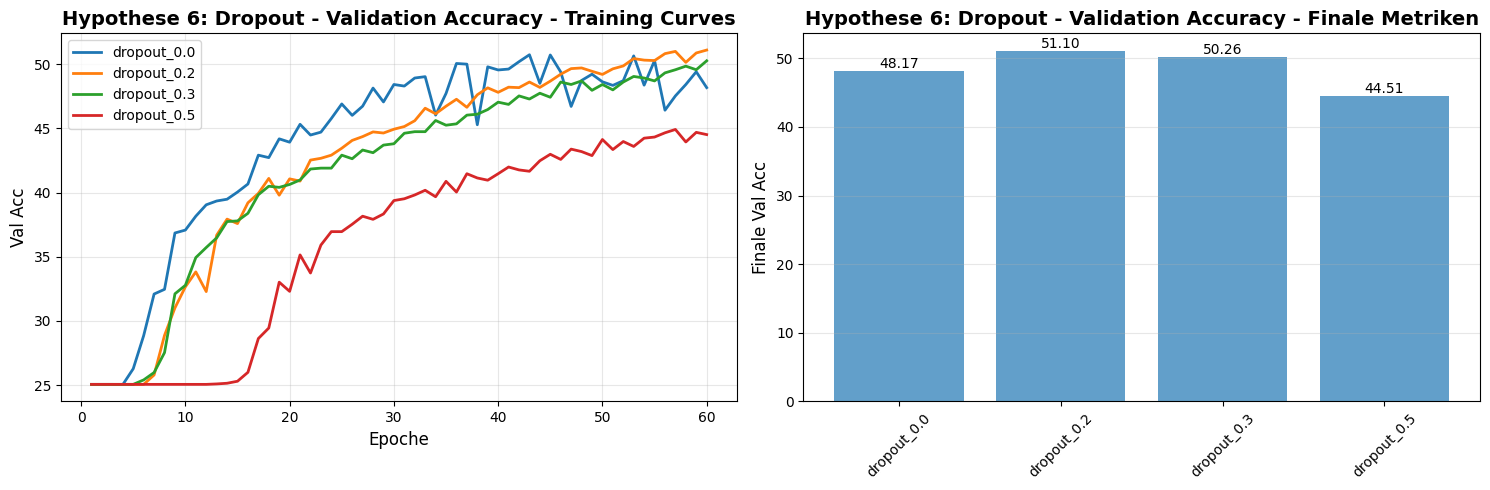

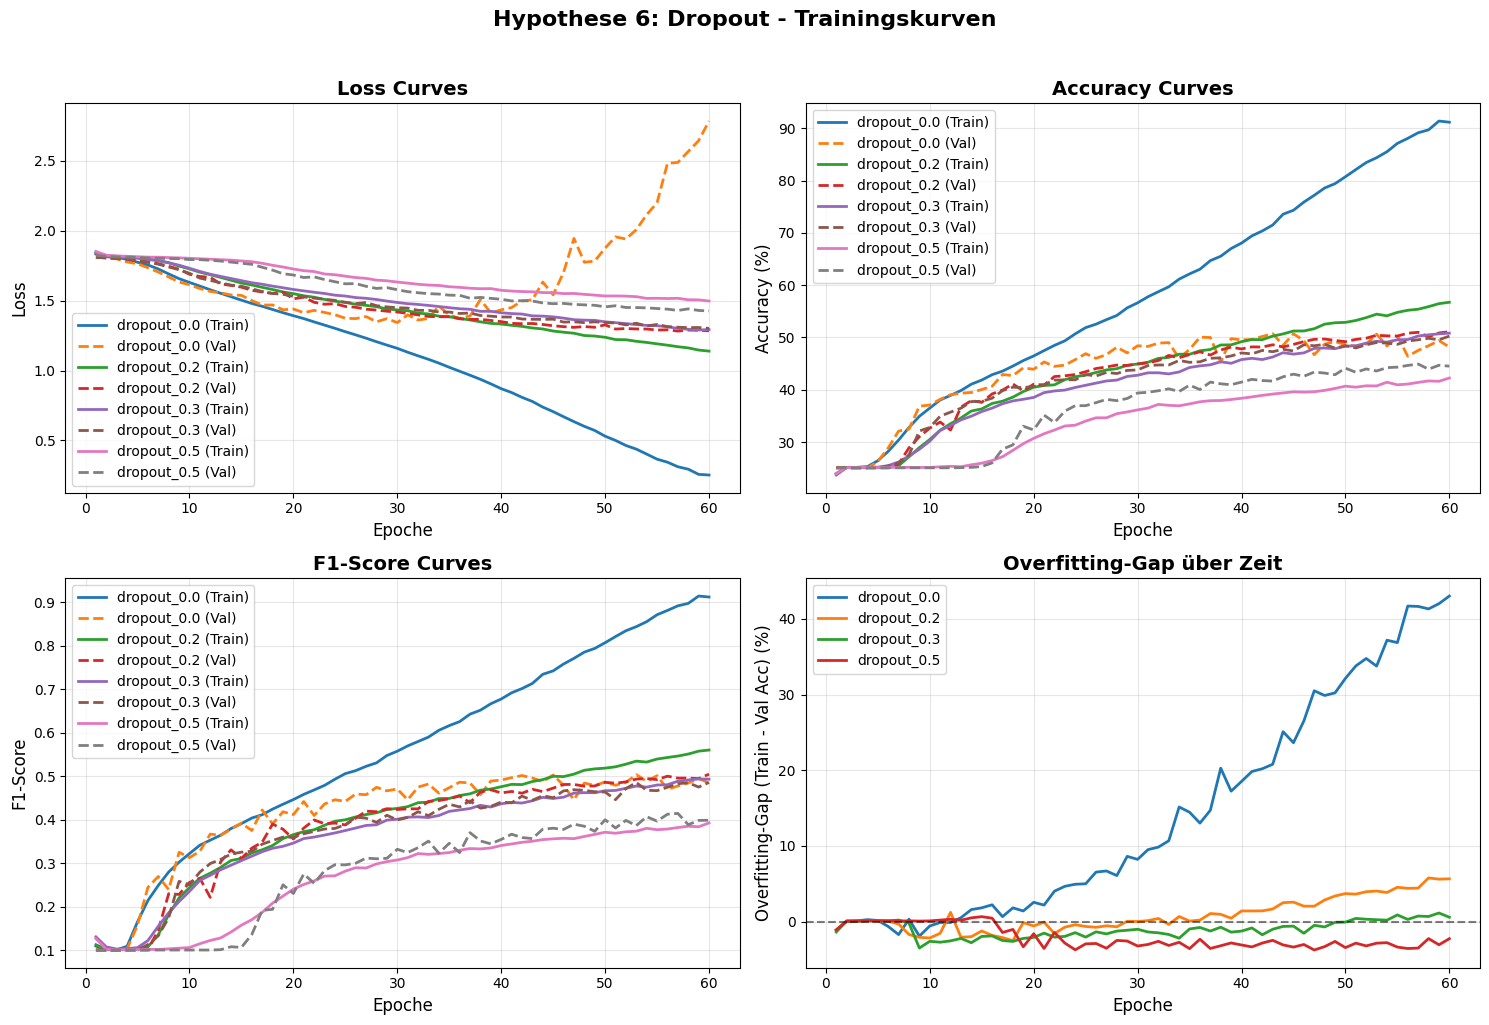

In [30]:
# Analyse und Visualisierung Hypothese 6
print("="*80)
print("ANALYSE HYPOTHESE 6: DROPOUT")
print("="*80)

summary_data = []
for name, result in hypothesis_6_results.items():
    summary_data.append({
        'Dropout Rate': name.replace('dropout_', ''),
        'Parameter': f"{result.get('num_params', 0):,}",
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung Hypothese 6:")
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_6_results, metric='val_acc',
                         title='Hypothese 6: Dropout - Validation Accuracy')
plt.savefig('plots/experiments/hyp6_dropout_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_6_results,
                                title='Hypothese 6: Dropout - Trainingskurven')
plt.savefig('plots/experiments/hyp6_dropout_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Hypothese 7: Data Augmentation

**Variiert:** Nur Data Augmentation (keine Baseline, Rotation, Flip, Translation, Kombination)  
**Konstant:** 3 Conv-Layer, Filter [16, 32, 64], FC-Layer 64 Neuronen, Kernel 3x3, MaxPool2d, kein Dropout

In [31]:
# Hypothese 7: Data Augmentation
# Verschiedene Augmentation-Strategien definieren
augmentation_configs = {
    'none': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]),
    'rotation': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ]),
    'flip': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ]),
    'translation': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ]),
    'combination': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ])
}

# Validation transform (immer ohne Augmentation)
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

hypothesis_7_file = 'results/hypothesis_7_augmentation.json'
hypothesis_7_results = {}

# Experiment 7.1: Baseline (keine Augmentation)
print("\n" + "-"*60)
print("Experiment 7.1: Baseline (keine Augmentation)")
print("Augmentation: keine")
print("-"*60)

baseline_results_hyp7 = copy.deepcopy(baseline_results)
baseline_results_hyp7['experiment_name'] = 'hyp7_baseline_no_aug'
hypothesis_7_results['no_aug'] = baseline_results_hyp7

save_hypothesis_results(hypothesis_7_results, hypothesis_7_file)

# Experiment 7.2-7.5: Verschiedene Augmentation-Strategien
for aug_name, aug_transform in augmentation_configs.items():
    if aug_name == 'none':
        continue  # Bereits als Baseline gemacht
    
    print("\n" + "-"*60)
    print(f"Experiment 7.{list(augmentation_configs.keys()).index(aug_name)+1}: {aug_name.title()} Augmentation")
    print(f"Augmentation: {aug_name}")
    print("-"*60)
    
# Neue Datasets mit Augmentation erstellen
    aug_train_dataset = datasets.ImageFolder(root=train_dir, transform=aug_transform)
    aug_val_dataset = datasets.ImageFolder(root=train_dir, transform=val_transform)
    
# Split neu erstellen
    aug_train_size = int(0.8 * len(aug_train_dataset))
    aug_val_size = len(aug_train_dataset) - aug_train_size
    aug_train_subset, aug_val_subset = random_split(
        aug_train_dataset, 
        [aug_train_size, aug_val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
# Val-Dataset für Evaluation (ohne Augmentation)
    aug_val_eval_dataset = datasets.ImageFolder(root=train_dir, transform=val_transform)
    _, aug_val_eval_subset = random_split(
        aug_val_eval_dataset,
        [aug_train_size, aug_val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
# DataLoader erstellen
    optimal_workers = min(12, get_optimal_num_workers())
    use_pin_memory = should_use_pin_memory()
    
    aug_train_loader = DataLoader(
        aug_train_subset,
        batch_size=32,
        shuffle=True,
        num_workers=optimal_workers,
        pin_memory=use_pin_memory
    )
    
    aug_val_loader = DataLoader(
        aug_val_eval_subset,
        batch_size=32,
        shuffle=False,
        num_workers=optimal_workers,
        pin_memory=use_pin_memory
    )
    
# Experiment durchführen
    result = run_hyperparameter_experiment(
        experiment_name=f'hyp7_aug_{aug_name}',
        model_class=FlexibleCNN,
        model_kwargs={
            'img_size': img_size,
            'num_classes': num_classes,
            'num_conv_layers': 3,
            'filters_per_layer': [16, 32, 64],
            'kernel_size': 3,
            'fc_units': 64,
            'pooling_type': 'max',
            'dropout_rate': 0.0,
            'use_batchnorm': False
        },
        train_loader=aug_train_loader,
        val_loader=aug_val_loader,
        num_epochs=60,
        learning_rate=0.01,
        batch_size=32,
    
        use_wandb=True
    )
    
    hypothesis_7_results[aug_name] = result
    save_hypothesis_results(hypothesis_7_results, hypothesis_7_file)



------------------------------------------------------------
Experiment 7.1: Baseline (keine Augmentation)
Augmentation: keine
------------------------------------------------------------
Ergebnisse gespeichert: results/hypothesis_7_augmentation.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_7_augmentation.json

------------------------------------------------------------
Experiment 7.2: Rotation Augmentation
Augmentation: rotation
------------------------------------------------------------

EXPERIMENT: hyp7_aug_rotation
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8254 | Val Loss: 1.8064 | Train Acc: 24.79% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7577 | Val Loss: 1.7432 | Train Acc: 27.67% | Val Acc: 28.34%
Epoch  10/60 | Train Loss: 1.6420 | Val Loss: 1.6166 | Train Acc: 35.94% | Val Acc: 36.50%
Epoch  15/60 | Train Loss: 1.5402 | Val Loss: 1.5132 | Train Acc: 40.77% | Val Acc: 41.80%
Epoch  20/60 | Train Loss: 1.4553 | Val Loss: 1.4567 | Train Acc: 44.06% | Val Acc: 43.92%
Epoch  25/60 | Train Loss: 1.3714 | Val Loss: 1.4031 | Train Acc: 47.65% | Val Acc: 45.33%
Epoch  30/60 | Train Loss: 1.2924 | Val Loss: 1.3667 | Train Acc: 50.77% | Val Acc: 46.69%
Epoch  35/60 | Train Loss: 1.2127 | Val Loss: 1.3518 | Train Acc: 53.82% | Val Acc: 48.17%
Epoch  40/60 | Train Loss: 1.1342 | Val Loss: 1.3123 | Train Acc: 57.26% | Val Acc: 50.94%
Epoch  45/60 | Train Loss: 1.0569 | Val Loss: 1.3251 | Train Acc: 60.35%


ERGEBNISSE: hyp7_aug_rotation
Beste Validation Accuracy: 52.44% (Epoche 60)
Finale Validation Accuracy: 52.44%
Finale Validation F1-Score: 0.5170
Overfitting-Gap (Acc): 17.18%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_7_augmentation.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_7_augmentation.json

------------------------------------------------------------
Experiment 7.3: Flip Augmentation
Augmentation: flip
------------------------------------------------------------

EXPERIMENT: hyp7_aug_flip
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8314 | Val Loss: 1.8074 | Train Acc: 24.73% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7846 | Val Loss: 1.7847 | Train Acc: 25.51% | Val Acc: 26.05%
Epoch  10/60 | Train Loss: 1.6626 | Val Loss: 1.6532 | Train Acc: 34.68% | Val Acc: 35.39%
Epoch  15/60 | Train Loss: 1.5464 | Val Loss: 1.5232 | Train Acc: 40.64% | Val Acc: 41.34%
Epoch  20/60 | Train Loss: 1.4515 | Val Loss: 1.4499 | Train Acc: 44.33% | Val Acc: 44.58%
Epoch  25/60 | Train Loss: 1.3629 | Val Loss: 1.3889 | Train Acc: 47.69% | Val Acc: 46.36%
Epoch  30/60 | Train Loss: 1.2797 | Val Loss: 1.3570 | Train Acc: 51.55% | Val Acc: 47.72%
Epoch  35/60 | Train Loss: 1.2032 | Val Loss: 1.2912 | Train Acc: 54.40% | Val Acc: 50.03%
Epoch  40/60 | Train Loss: 1.1296 | Val Loss: 1.2790 | Train Acc: 57.55% | Val Acc: 52.07%
Epoch  45/60 | Train Loss: 1.0571 | Val Loss: 1.2579 | Train Acc: 60.83%


ERGEBNISSE: hyp7_aug_flip
Beste Validation Accuracy: 53.67% (Epoche 58)
Finale Validation Accuracy: 52.19%
Finale Validation F1-Score: 0.5245
Overfitting-Gap (Acc): 17.93%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_7_augmentation.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_7_augmentation.json

------------------------------------------------------------
Experiment 7.4: Translation Augmentation
Augmentation: translation
------------------------------------------------------------

EXPERIMENT: hyp7_aug_translation
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8325 | Val Loss: 1.8078 | Train Acc: 24.79% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7699 | Val Loss: 1.7554 | Train Acc: 26.50% | Val Acc: 26.35%
Epoch  10/60 | Train Loss: 1.7198 | Val Loss: 1.6807 | Train Acc: 30.43% | Val Acc: 32.72%
Epoch  15/60 | Train Loss: 1.6686 | Val Loss: 1.6177 | Train Acc: 34.12% | Val Acc: 37.27%
Epoch  20/60 | Train Loss: 1.5994 | Val Loss: 1.5355 | Train Acc: 37.48% | Val Acc: 40.49%
Epoch  25/60 | Train Loss: 1.5282 | Val Loss: 1.5065 | Train Acc: 40.44% | Val Acc: 40.91%
Epoch  30/60 | Train Loss: 1.4614 | Val Loss: 1.4193 | Train Acc: 43.81% | Val Acc: 45.37%
Epoch  35/60 | Train Loss: 1.3985 | Val Loss: 1.3637 | Train Acc: 46.60% | Val Acc: 47.67%
Epoch  40/60 | Train Loss: 1.3387 | Val Loss: 1.3305 | Train Acc: 48.74% | Val Acc: 49.65%
Epoch  45/60 | Train Loss: 1.2874 | Val Loss: 1.3613 | Train Acc: 51.34%


ERGEBNISSE: hyp7_aug_translation
Beste Validation Accuracy: 54.01% (Epoche 56)
Finale Validation Accuracy: 53.78%
Finale Validation F1-Score: 0.5292
Overfitting-Gap (Acc): 2.71%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_7_augmentation.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_7_augmentation.json

------------------------------------------------------------
Experiment 7.5: Combination Augmentation
Augmentation: combination
------------------------------------------------------------

EXPERIMENT: hyp7_aug_combination
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8300 | Val Loss: 1.8065 | Train Acc: 25.00% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.7784 | Val Loss: 1.7727 | Train Acc: 26.10% | Val Acc: 25.95%
Epoch  10/60 | Train Loss: 1.7307 | Val Loss: 1.6999 | Train Acc: 30.21% | Val Acc: 32.60%
Epoch  15/60 | Train Loss: 1.6840 | Val Loss: 1.6484 | Train Acc: 33.33% | Val Acc: 35.02%
Epoch  20/60 | Train Loss: 1.6209 | Val Loss: 1.5504 | Train Acc: 36.44% | Val Acc: 40.77%
Epoch  25/60 | Train Loss: 1.5469 | Val Loss: 1.4783 | Train Acc: 40.30% | Val Acc: 43.09%
Epoch  30/60 | Train Loss: 1.4847 | Val Loss: 1.4282 | Train Acc: 42.41% | Val Acc: 44.93%
Epoch  35/60 | Train Loss: 1.4298 | Val Loss: 1.3923 | Train Acc: 45.19% | Val Acc: 46.53%
Epoch  40/60 | Train Loss: 1.3855 | Val Loss: 1.3186 | Train Acc: 47.13% | Val Acc: 48.96%
Epoch  45/60 | Train Loss: 1.3435 | Val Loss: 1.3031 | Train Acc: 49.02%


ERGEBNISSE: hyp7_aug_combination
Beste Validation Accuracy: 53.99% (Epoche 58)
Finale Validation Accuracy: 53.90%
Finale Validation F1-Score: 0.5249
Overfitting-Gap (Acc): -0.49%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_7_augmentation.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_7_augmentation.json


ANALYSE HYPOTHESE 7: DATA AUGMENTATION

Zusammenfassung Hypothese 7:
Augmentation Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
      No Aug   171,271             50.73              48.17               43.02
    Rotation   171,271             52.44              52.44               17.18
        Flip   171,271             53.67              52.19               17.93
 Translation   171,271             54.01              53.78                2.71
 Combination   171,271             53.99              53.90               -0.49


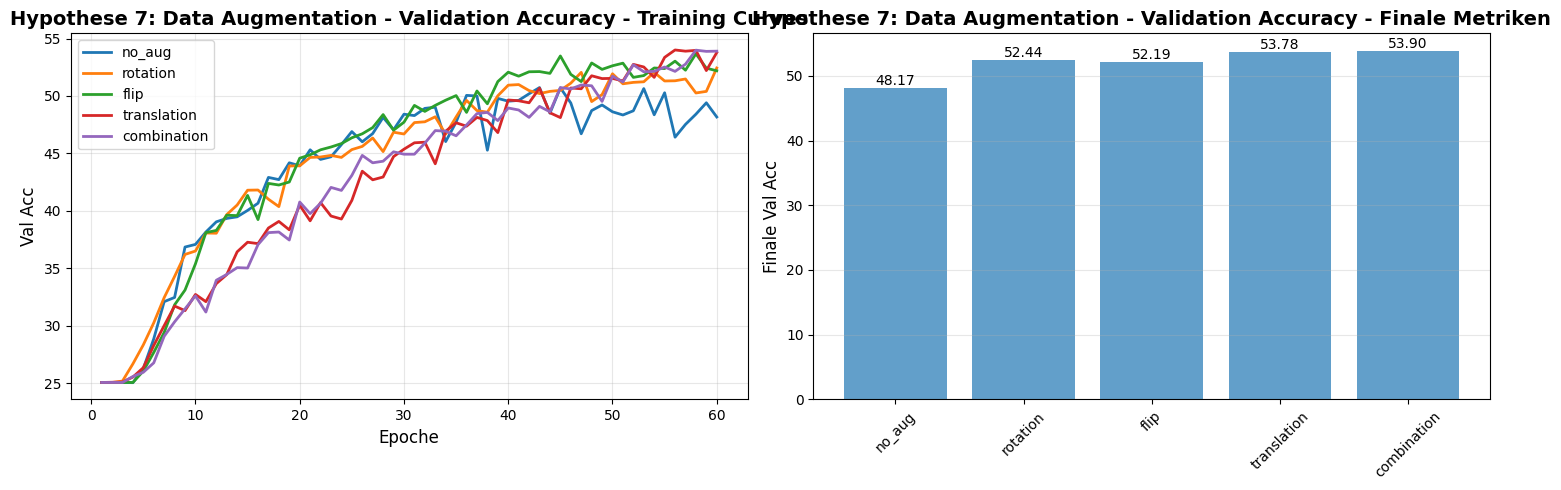

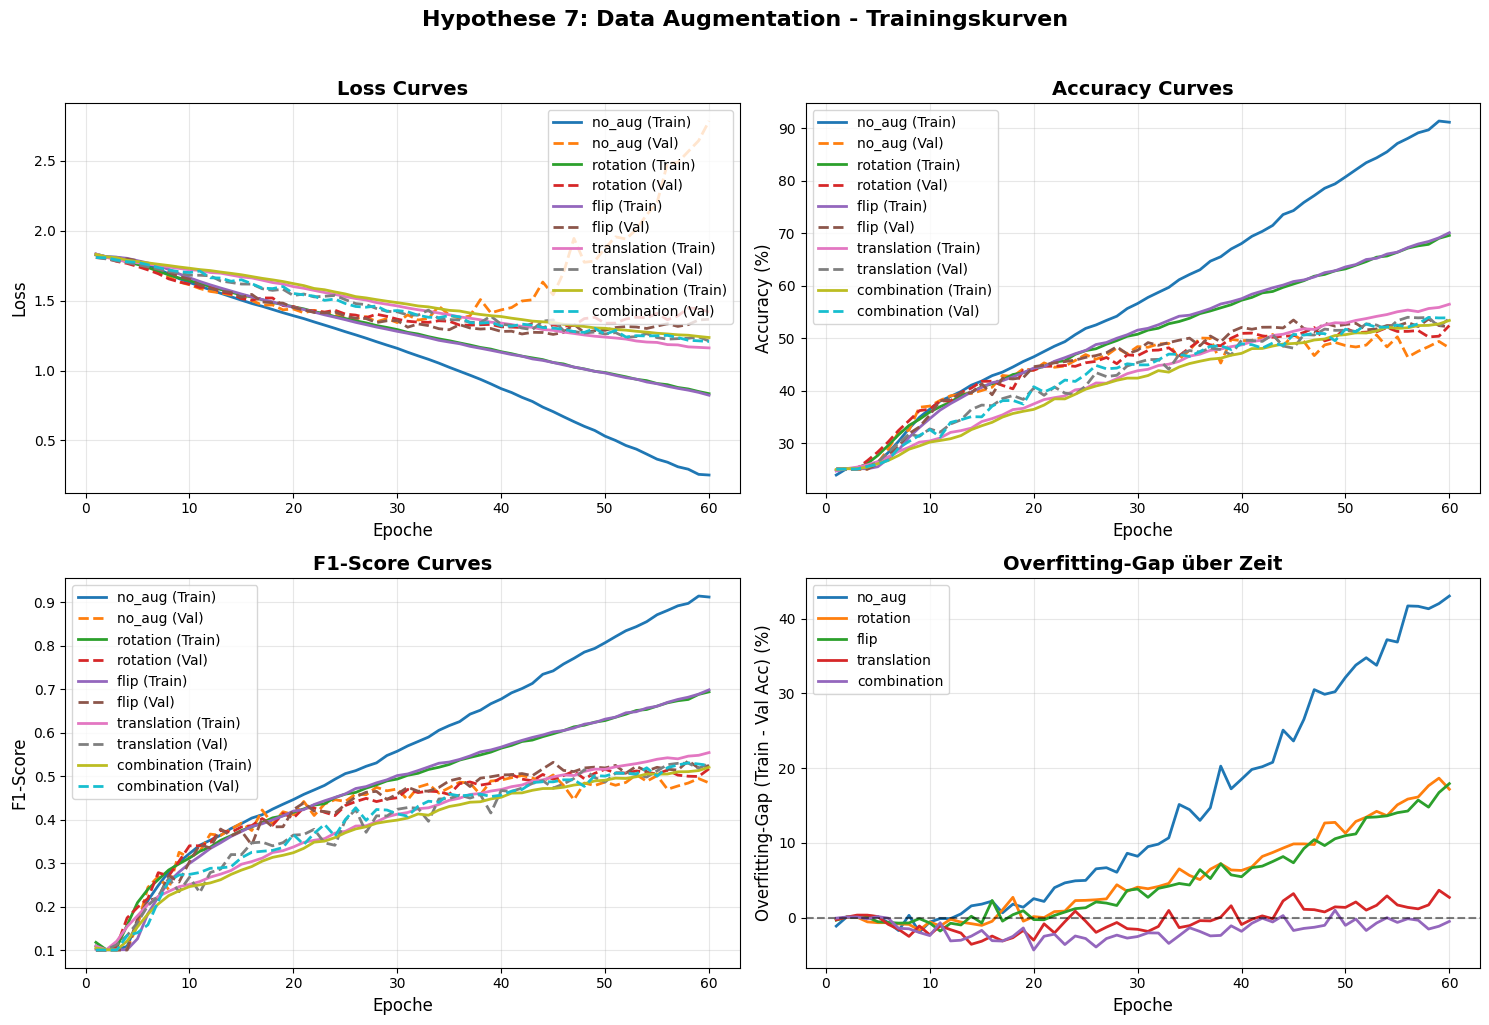

In [32]:
# Analyse und Visualisierung Hypothese 7
print("="*80)
print("ANALYSE HYPOTHESE 7: DATA AUGMENTATION")
print("="*80)

summary_data = []
for name, result in hypothesis_7_results.items():
    summary_data.append({
        'Augmentation': name.replace('_', ' ').title(),
        'Parameter': f"{result.get('num_params', 0):,}",
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung Hypothese 7:")
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_7_results, metric='val_acc',
                         title='Hypothese 7: Data Augmentation - Validation Accuracy')
plt.savefig('plots/experiments/hyp7_augmentation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_model_complexity_analysis(hypothesis_7_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp7_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_7_results,
                                title='Hypothese 7: Data Augmentation - Trainingskurven')
plt.savefig('plots/experiments/hyp7_augmentation_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### Zusammenfassung Kategorie 3

ZUSAMMENFASSUNG: KATEGORIE 3 - REGULARISIERUNG

Beste Konfigurationen pro Hypothese:
Hypothese        Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
Hyp6_Best     hyp6_dropout_0.2   171,271             51.10              51.10                5.65
Hyp7_Best hyp7_aug_translation   171,271             54.01              53.78                2.71

GESAMTBESTE KONFIGURATION: Hyp7_Best
Experiment: hyp7_aug_translation
Beste Validation Accuracy: 54.01%


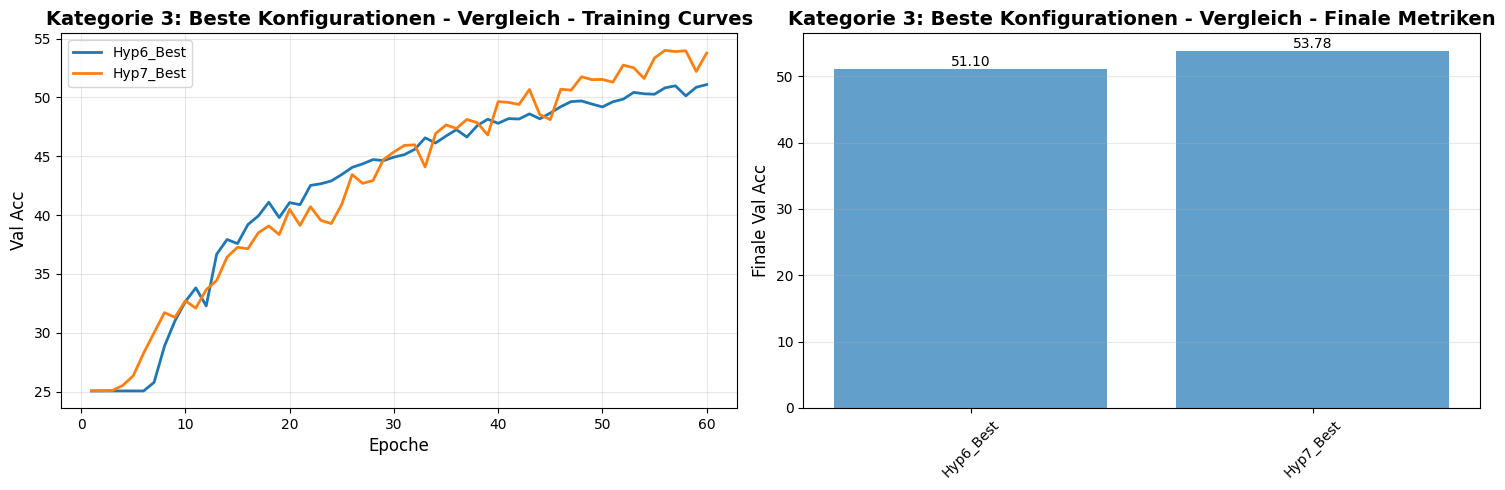

Ergebnisse gespeichert: results/category3_all_results.json

Alle Ergebnisse gespeichert: results/category3_all_results.json


In [33]:
# Zusammenfassung Kategorie 3
print("="*80)
print("ZUSAMMENFASSUNG: KATEGORIE 3 - REGULARISIERUNG")
print("="*80)

best_hyp6 = max(hypothesis_6_results.keys(), 
                key=lambda k: hypothesis_6_results[k]['best_val_acc'])
best_hyp7 = max(hypothesis_7_results.keys(), 
                key=lambda k: hypothesis_7_results[k]['best_val_acc'])

summary_all = {
    'Hyp6_Best': hypothesis_6_results[best_hyp6],
    'Hyp7_Best': hypothesis_7_results[best_hyp7]
}

comparison_data = []
for name, result in summary_all.items():
    comparison_data.append({
        'Hypothese': name,
        'Konfiguration': result['experiment_name'],
        'Parameter': f"{result['num_params']:,}",
        'Beste Val Acc (%)': f"{result['best_val_acc']:.2f}",
        'Finale Val Acc (%)': f"{result['final_val_acc']:.2f}",
        'Overfitting-Gap (%)': f"{result['overfitting_gap_acc']:.2f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBeste Konfigurationen pro Hypothese:")
print(df_comparison.to_string(index=False))

overall_best = max(summary_all.keys(), 
                  key=lambda k: summary_all[k]['best_val_acc'])
overall_best_result = summary_all[overall_best]

print(f"\n{'='*80}")
print(f"GESAMTBESTE KONFIGURATION: {overall_best}")
print(f"{'='*80}")
print(f"Experiment: {overall_best_result['experiment_name']}")
print(f"Beste Validation Accuracy: {overall_best_result['best_val_acc']:.2f}%")

fig = plot_experiment_comparison(summary_all, metric='val_acc', 
                                 title='Kategorie 3: Beste Konfigurationen - Vergleich')
plt.savefig('plots/experiments/category3_best_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

all_results = {
    'hypothesis_6': hypothesis_6_results,
    'hypothesis_7': hypothesis_7_results,
    'summary': {
        'best_hyp6': best_hyp6,
        'best_hyp7': best_hyp7,
        'overall_best': overall_best
    }
}

save_experiment_results(all_results, 'results/category3_all_results.json')
print("\nAlle Ergebnisse gespeichert: results/category3_all_results.json")

## Hyperparameter-Experimente: Kategorie 4 - BatchNorm

**Hypothese 8:** BatchNorm nach jedem Conv-Layer vs. Baseline (kein BatchNorm)

In [34]:
# Hypothese 8: BatchNorm
hypothesis_8_file = 'results/hypothesis_8_batchnorm.json'
hypothesis_8_results = {}

# Baseline (kein BatchNorm)
baseline_results_hyp8 = copy.deepcopy(baseline_results)
baseline_results_hyp8['experiment_name'] = 'hyp8_baseline_no_bn'
hypothesis_8_results['no_bn'] = baseline_results_hyp8

# Mit BatchNorm
print("\n" + "-"*60)
print("Experiment 8.2: Mit BatchNorm")
print("-"*60)

result_bn = run_hyperparameter_experiment(
    experiment_name='hyp8_with_batchnorm',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 3,
        'fc_units': 64,
        'pooling_type': 'max',
        'dropout_rate': 0.0,
        'use_batchnorm': True
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True
)

hypothesis_8_results['with_bn'] = result_bn
save_hypothesis_results(hypothesis_8_results, hypothesis_8_file)



------------------------------------------------------------
Experiment 8.2: Mit BatchNorm
------------------------------------------------------------

EXPERIMENT: hyp8_with_batchnorm
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': True}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,495 total, 171,495 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.6396 | Val Loss: 1.5251 | Train Acc: 35.10% | Val Acc: 40.37%
Epoch   5/60 | Train Loss: 1.2147 | Val Loss: 1.3529 | Train Acc: 53.92% | Val Acc: 47.28%
Epoch  10/60 | Train Loss: 0.9768 | Val Loss: 1.3020 | Train Acc: 63.80% | Val Acc: 51.43%
Epoch  15/60 | Train Loss: 0.7612 | Val Loss: 1.3669 | Train Acc: 72.19% | Val Acc: 54.37%
Epoch  20/60 | Train Loss: 0.5581 | Val Loss: 1.7421 | Train Acc: 80.00% | Val Acc: 48.21%
Epoch  25/60 | Train Loss: 0.3693 | Val Loss: 1.6870 | Train Acc: 87.34% | Val Acc: 52.73%
Epoch  30/60 | Train Loss: 0.2304 | Val Loss: 1.9218 | Train Acc: 92.44% | Val Acc: 49.81%
Epoch  35/60 | Train Loss: 0.1210 | Val Loss: 2.2393 | Train Acc: 96.63% | Val Acc: 52.04%
Epoch  40/60 | Train Loss: 0.0487 | Val Loss: 2.6363 | Train Acc: 99.24% | Val Acc: 52.98%
Epoch  45/60 | Train Loss: 0.0325 | Val Loss: 2.7357 | Train Acc: 99.54%


ERGEBNISSE: hyp8_with_batchnorm
Beste Validation Accuracy: 54.37% (Epoche 15)
Finale Validation Accuracy: 52.23%
Finale Validation F1-Score: 0.5213
Overfitting-Gap (Acc): 47.46%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_8_batchnorm.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_8_batchnorm.json


ANALYSE HYPOTHESE 8: BATCHNORM
Konfiguration Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
        No Bn             50.73              48.17               43.02
      With Bn             54.37              52.23               47.46


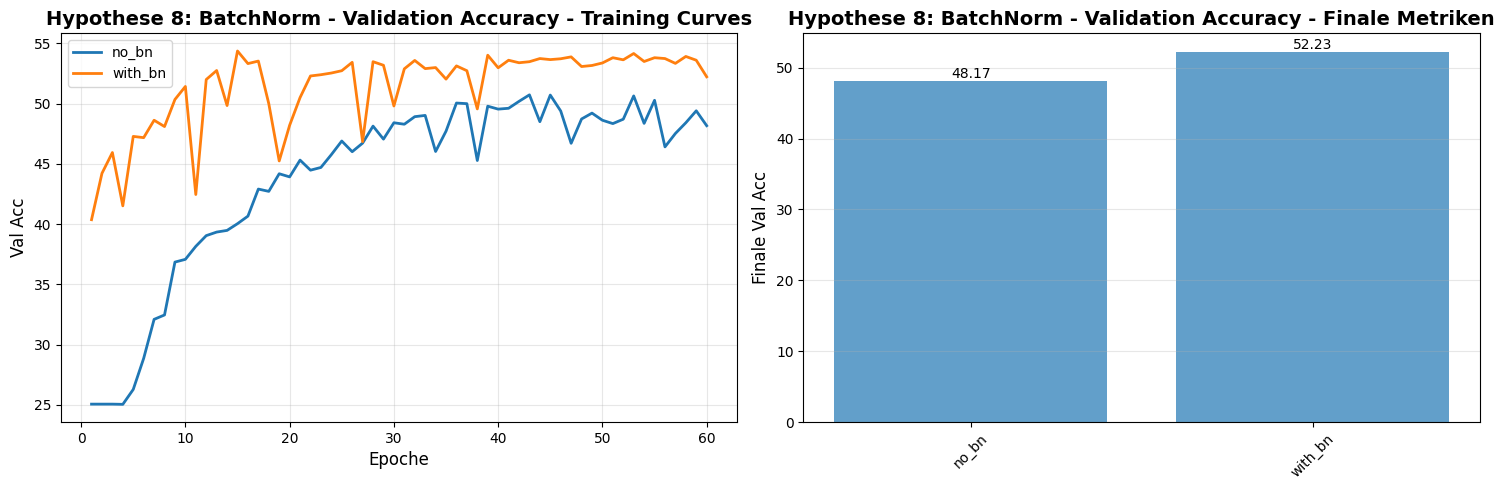

Ergebnisse gespeichert: results/category4_all_results.json


In [35]:
# Analyse
print("="*80)
print("ANALYSE HYPOTHESE 8: BATCHNORM")
print("="*80)
summary_data = []
for name, result in hypothesis_8_results.items():
    summary_data.append({
        'Konfiguration': name.replace('_', ' ').title(),
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_8_results, metric='val_acc',
                         title='Hypothese 8: BatchNorm - Validation Accuracy')
plt.savefig('plots/experiments/hyp8_batchnorm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_model_complexity_analysis(hypothesis_8_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp8_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_8_results,
                                title='Hypothese 8: BatchNorm - Trainingskurven')
plt.savefig('plots/experiments/hyp8_batchnorm_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Speichern
all_results = {
    'hypothesis_8': hypothesis_8_results,
    'summary': {
        'best': max(hypothesis_8_results.keys(), 
                   key=lambda k: hypothesis_8_results[k]['best_val_acc'])
    }
}
save_experiment_results(all_results, 'results/category4_all_results.json')

## Hyperparameter-Experimente: Kategorie 5 - Initialisierung

**Hypothese 9:** Verschiedene Gewichts-Initialisierungen (Default, He, Xavier, Small)

In [36]:
# Hypothese 9: Initialisierung
hypothesis_9_file = 'results/hypothesis_9_initialization.json'
hypothesis_9_results = {}

# Baseline (Default)
baseline_results_hyp9 = copy.deepcopy(baseline_results)
baseline_results_hyp9['experiment_name'] = 'hyp9_baseline_default_init'
hypothesis_9_results['default'] = baseline_results_hyp9

# Verschiedene Initialisierungen
init_types = ['he', 'xavier', 'small']

for init_type in init_types:
    print("\n" + "-"*60)
    print(f"Experiment 9.{init_types.index(init_type)+2}: {init_type.title()} Initialization")
    print("-"*60)
    
    result = run_hyperparameter_experiment(
        experiment_name=f'hyp9_{init_type}_init',
        model_class=FlexibleCNN,
        model_kwargs={
            'img_size': img_size,
            'num_classes': num_classes,
            'num_conv_layers': 3,
            'filters_per_layer': [16, 32, 64],
            'kernel_size': 3,
            'fc_units': 64,
            'pooling_type': 'max',
            'dropout_rate': 0.0,
            'use_batchnorm': False,
            'init_type': init_type
        },
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=60,
        learning_rate=0.01,
        batch_size=32,
    
        use_wandb=True
    )
    
    hypothesis_9_results[init_type] = result
    save_hypothesis_results(hypothesis_9_results, hypothesis_9_file)



------------------------------------------------------------
Experiment 9.2: He Initialization
------------------------------------------------------------

EXPERIMENT: hyp9_he_init
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False, 'init_type': 'he'}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8009 | Val Loss: 1.7294 | Train Acc: 26.52% | Val Acc: 29.26%
Epoch   5/60 | Train Loss: 1.5988 | Val Loss: 1.5967 | Train Acc: 38.42% | Val Acc: 38.61%
Epoch  10/60 | Train Loss: 1.4830 | Val Loss: 1.5000 | Train Acc: 43.17% | Val Acc: 42.67%
Epoch  15/60 | Train Loss: 1.3903 | Val Loss: 1.4889 | Train Acc: 47.28% | Val Acc: 42.62%
Epoch  20/60 | Train Loss: 1.3123 | Val Loss: 1.4350 | Train Acc: 50.76% | Val Acc: 44.88%
Epoch  25/60 | Train Loss: 1.2388 | Val Loss: 1.4502 | Train Acc: 53.26% | Val Acc: 44.58%
Epoch  30/60 | Train Loss: 1.1699 | Val Loss: 1.4168 | Train Acc: 56.20% | Val Acc: 47.65%
Epoch  35/60 | Train Loss: 1.1050 | Val Loss: 1.4388 | Train Acc: 59.05% | Val Acc: 46.95%
Epoch  40/60 | Train Loss: 1.0397 | Val Loss: 1.4330 | Train Acc: 61.54% | Val Acc: 48.76%
Epoch  45/60 | Train Loss: 0.9740 | Val Loss: 1.4802 | Train Acc: 63.95%


ERGEBNISSE: hyp9_he_init
Beste Validation Accuracy: 48.76% (Epoche 40)
Finale Validation Accuracy: 47.79%
Finale Validation F1-Score: 0.4723
Overfitting-Gap (Acc): 23.55%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_9_initialization.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_9_initialization.json

------------------------------------------------------------
Experiment 9.3: Xavier Initialization
------------------------------------------------------------

EXPERIMENT: hyp9_xavier_init
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False, 'init_type': 'xavier'}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8227 | Val Loss: 1.8030 | Train Acc: 24.94% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.6954 | Val Loss: 1.6658 | Train Acc: 32.95% | Val Acc: 35.30%
Epoch  10/60 | Train Loss: 1.5365 | Val Loss: 1.5510 | Train Acc: 41.05% | Val Acc: 39.78%
Epoch  15/60 | Train Loss: 1.4021 | Val Loss: 1.4339 | Train Acc: 46.10% | Val Acc: 44.11%
Epoch  20/60 | Train Loss: 1.2779 | Val Loss: 1.3901 | Train Acc: 51.61% | Val Acc: 47.44%
Epoch  25/60 | Train Loss: 1.1471 | Val Loss: 1.3838 | Train Acc: 57.48% | Val Acc: 48.43%
Epoch  30/60 | Train Loss: 1.0111 | Val Loss: 1.4512 | Train Acc: 62.60% | Val Acc: 47.27%
Epoch  35/60 | Train Loss: 0.8523 | Val Loss: 1.5531 | Train Acc: 68.85% | Val Acc: 48.50%
Epoch  40/60 | Train Loss: 0.6867 | Val Loss: 1.6593 | Train Acc: 75.33% | Val Acc: 49.06%
Epoch  45/60 | Train Loss: 0.5170 | Val Loss: 1.9775 | Train Acc: 81.65%


ERGEBNISSE: hyp9_xavier_init
Beste Validation Accuracy: 49.49% (Epoche 31)
Finale Validation Accuracy: 46.69%
Finale Validation F1-Score: 0.4772
Overfitting-Gap (Acc): 47.83%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_9_initialization.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_9_initialization.json

------------------------------------------------------------
Experiment 9.4: Small Initialization
------------------------------------------------------------

EXPERIMENT: hyp9_small_init
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False, 'init_type': 'small'}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.8832 | Val Loss: 1.8466 | Train Acc: 25.11% | Val Acc: 25.06%
Epoch   5/60 | Train Loss: 1.8159 | Val Loss: 1.8101 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  10/60 | Train Loss: 1.8116 | Val Loss: 1.8061 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  15/60 | Train Loss: 1.8111 | Val Loss: 1.8053 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  20/60 | Train Loss: 1.8109 | Val Loss: 1.8050 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  25/60 | Train Loss: 1.8109 | Val Loss: 1.8050 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  30/60 | Train Loss: 1.8109 | Val Loss: 1.8050 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  35/60 | Train Loss: 1.8108 | Val Loss: 1.8050 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  40/60 | Train Loss: 1.8108 | Val Loss: 1.8049 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  45/60 | Train Loss: 1.8109 | Val Loss: 1.8050 | Train Acc: 25.15%


ERGEBNISSE: hyp9_small_init
Beste Validation Accuracy: 25.06% (Epoche 1)
Finale Validation Accuracy: 25.06%
Finale Validation F1-Score: 0.1004
Overfitting-Gap (Acc): 0.09%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_9_initialization.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_9_initialization.json


ANALYSE HYPOTHESE 9: INITIALISIERUNG
Initialisierung Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
        Default             50.73              48.17               43.02
             He             48.76              47.79               23.55
         Xavier             49.49              46.69               47.83
          Small             25.06              25.06                0.09


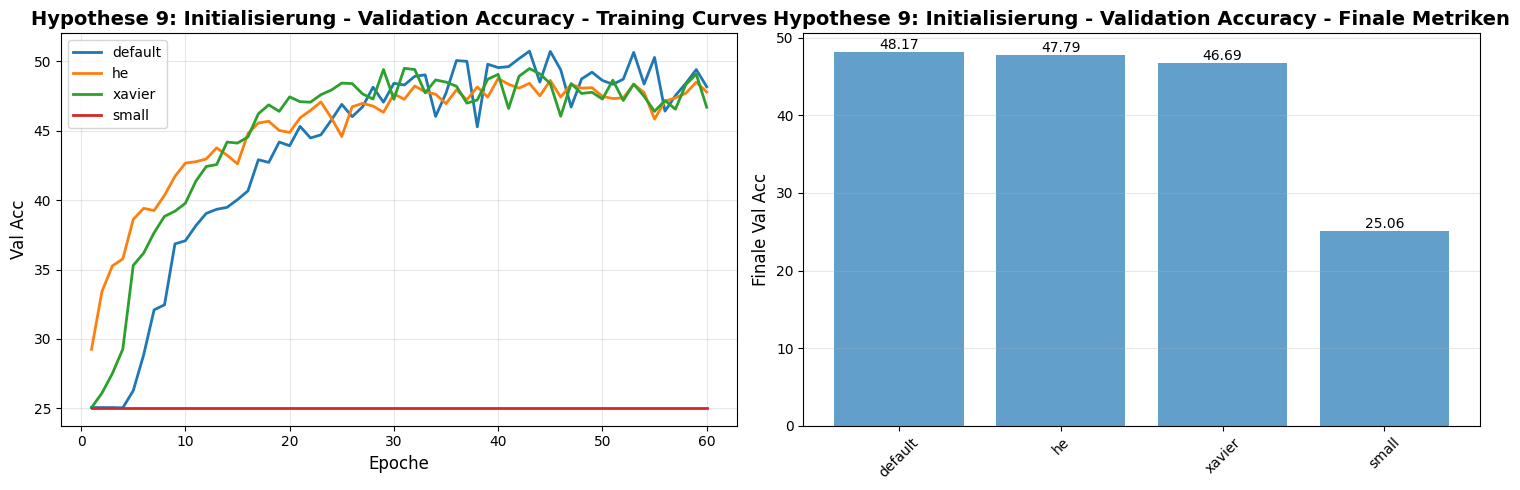

Ergebnisse gespeichert: results/category5_all_results.json


In [37]:
# Analyse
print("="*80)
print("ANALYSE HYPOTHESE 9: INITIALISIERUNG")
print("="*80)
summary_data = []
for name, result in hypothesis_9_results.items():
    summary_data.append({
        'Initialisierung': name.title(),
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_9_results, metric='val_acc',
                         title='Hypothese 9: Initialisierung - Validation Accuracy')
plt.savefig('plots/experiments/hyp9_init_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_model_complexity_analysis(hypothesis_9_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp9_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_9_results,
                                title='Hypothese 9: Initialisierung - Trainingskurven')
plt.savefig('plots/experiments/hyp9_init_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

all_results = {
    'hypothesis_9': hypothesis_9_results,
    'summary': {
        'best': max(hypothesis_9_results.keys(), 
                   key=lambda k: hypothesis_9_results[k]['best_val_acc'])
    }
}
save_experiment_results(all_results, 'results/category5_all_results.json')

## Hyperparameter-Experimente: Kategorie 6 - Optimizer

**Hypothese 10:** Verschiedene Optimizer (SGD Baseline, Adam, SGD mit Momentum)

In [38]:
# Hypothese 10: Optimizer
hypothesis_10_file = 'results/hypothesis_10_optimizer.json'
hypothesis_10_results = {}

# Baseline (SGD ohne Momentum)
baseline_results_hyp10 = copy.deepcopy(baseline_results)
baseline_results_hyp10['experiment_name'] = 'hyp10_baseline_sgd'
hypothesis_10_results['sgd'] = baseline_results_hyp10

# Adam mit verschiedenen LR
adam_configs = [
    ('adam_0.001', 0.001),
    ('adam_0.0001', 0.0001),
    ('adam_0.01', 0.01)
]

for name, lr in adam_configs:
    print("\n" + "-"*60)
    print(f"Experiment 10.{adam_configs.index((name, lr))+2}: {name}")
    print(f"Optimizer: Adam, LR: {lr}")
    print("-"*60)
    
    result = run_hyperparameter_experiment(
        experiment_name=f'hyp10_{name}',
        model_class=FlexibleCNN,
        model_kwargs={
            'img_size': img_size,
            'num_classes': num_classes,
            'num_conv_layers': 3,
            'filters_per_layer': [16, 32, 64],
            'kernel_size': 3,
            'fc_units': 64,
            'pooling_type': 'max',
            'dropout_rate': 0.0,
            'use_batchnorm': False
        },
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=60,
        learning_rate=lr,
        batch_size=32,
    
        use_wandb=True,
        optimizer_type='adam'
    )
    
    hypothesis_10_results[name] = result
    save_hypothesis_results(hypothesis_10_results, hypothesis_10_file)

# SGD mit Momentum
print("\n" + "-"*60)
print("Experiment 10.4: SGD mit Momentum 0.9")
print("-"*60)

result_sgd_mom = run_hyperparameter_experiment(
    experiment_name='hyp10_sgd_momentum',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [16, 32, 64],
        'kernel_size': 3,
        'fc_units': 64,
        'pooling_type': 'max',
        'dropout_rate': 0.0,
        'use_batchnorm': False
    },
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=60,
    learning_rate=0.01,
    batch_size=32,

    use_wandb=True,
    optimizer_type='sgd',
    optimizer_momentum=0.9
)

hypothesis_10_results['sgd_momentum'] = result_sgd_mom
save_hypothesis_results(hypothesis_10_results, hypothesis_10_file)



------------------------------------------------------------
Experiment 10.2: adam_0.001
Optimizer: Adam, LR: 0.001
------------------------------------------------------------

EXPERIMENT: hyp10_adam_0.001
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.001, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.001, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.6995 | Val Loss: 1.5664 | Train Acc: 31.55% | Val Acc: 38.75%
Epoch   5/60 | Train Loss: 1.2006 | Val Loss: 1.2789 | Train Acc: 54.75% | Val Acc: 50.99%
Epoch  10/60 | Train Loss: 0.9117 | Val Loss: 1.3063 | Train Acc: 66.46% | Val Acc: 53.01%
Epoch  15/60 | Train Loss: 0.6762 | Val Loss: 1.5215 | Train Acc: 74.89% | Val Acc: 51.83%
Epoch  20/60 | Train Loss: 0.4955 | Val Loss: 1.8917 | Train Acc: 81.79% | Val Acc: 51.13%
Epoch  25/60 | Train Loss: 0.3439 | Val Loss: 2.5454 | Train Acc: 87.60% | Val Acc: 49.43%
Epoch  30/60 | Train Loss: 0.2520 | Val Loss: 3.0744 | Train Acc: 90.71% | Val Acc: 49.63%
Epoch  35/60 | Train Loss: 0.1976 | Val Loss: 3.6770 | Train Acc: 92.88% | Val Acc: 49.23%
Epoch  40/60 | Train Loss: 0.1537 | Val Loss: 4.3918 | Train Acc: 94.57% | Val Acc: 50.17%
Epoch  45/60 | Train Loss: 0.1309 | Val Loss: 4.7220 | Train Acc: 95.45


ERGEBNISSE: hyp10_adam_0.001
Beste Validation Accuracy: 53.99% (Epoche 9)
Finale Validation Accuracy: 49.95%
Finale Validation F1-Score: 0.4959
Overfitting-Gap (Acc): 46.89%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_10_optimizer.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_10_optimizer.json

------------------------------------------------------------
Experiment 10.3: adam_0.0001
Optimizer: Adam, LR: 0.0001
------------------------------------------------------------

EXPERIMENT: hyp10_adam_0.0001
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.0001, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.0001, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.7847 | Val Loss: 1.7421 | Train Acc: 26.12% | Val Acc: 28.96%
Epoch   5/60 | Train Loss: 1.5550 | Val Loss: 1.5333 | Train Acc: 40.34% | Val Acc: 41.34%
Epoch  10/60 | Train Loss: 1.4278 | Val Loss: 1.4362 | Train Acc: 45.40% | Val Acc: 44.55%
Epoch  15/60 | Train Loss: 1.3442 | Val Loss: 1.3843 | Train Acc: 48.87% | Val Acc: 46.19%
Epoch  20/60 | Train Loss: 1.2751 | Val Loss: 1.3513 | Train Acc: 51.52% | Val Acc: 47.86%
Epoch  25/60 | Train Loss: 1.2128 | Val Loss: 1.3182 | Train Acc: 54.16% | Val Acc: 49.41%
Epoch  30/60 | Train Loss: 1.1553 | Val Loss: 1.2979 | Train Acc: 56.73% | Val Acc: 50.05%
Epoch  35/60 | Train Loss: 1.1013 | Val Loss: 1.2999 | Train Acc: 58.88% | Val Acc: 50.54%
Epoch  40/60 | Train Loss: 1.0492 | Val Loss: 1.2908 | Train Acc: 61.25% | Val Acc: 51.62%
Epoch  45/60 | Train Loss: 1.0020 | Val Loss: 1.3129 | Train Acc: 63.1


ERGEBNISSE: hyp10_adam_0.0001
Beste Validation Accuracy: 52.28% (Epoche 43)
Finale Validation Accuracy: 52.00%
Finale Validation F1-Score: 0.4993
Overfitting-Gap (Acc): 16.78%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_10_optimizer.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_10_optimizer.json

------------------------------------------------------------
Experiment 10.4: adam_0.01
Optimizer: Adam, LR: 0.01
------------------------------------------------------------

EXPERIMENT: hyp10_adam_0.01
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.7993 | Val Loss: 1.7671 | Train Acc: 25.26% | Val Acc: 25.71%
Epoch   5/60 | Train Loss: 1.8120 | Val Loss: 1.8051 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  10/60 | Train Loss: 1.8118 | Val Loss: 1.8054 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  15/60 | Train Loss: 1.8118 | Val Loss: 1.8061 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  20/60 | Train Loss: 1.8121 | Val Loss: 1.8060 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  25/60 | Train Loss: 1.8119 | Val Loss: 1.8059 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  30/60 | Train Loss: 1.8119 | Val Loss: 1.8060 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  35/60 | Train Loss: 1.8118 | Val Loss: 1.8052 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  40/60 | Train Loss: 1.8119 | Val Loss: 1.8059 | Train Acc: 25.15% | Val Acc: 25.06%
Epoch  45/60 | Train Loss: 1.8120 | Val Loss: 1.8050 | Train Acc: 25.15%


ERGEBNISSE: hyp10_adam_0.01
Beste Validation Accuracy: 25.71% (Epoche 1)
Finale Validation Accuracy: 25.06%
Finale Validation F1-Score: 0.1004
Overfitting-Gap (Acc): 0.09%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_10_optimizer.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_10_optimizer.json

------------------------------------------------------------
Experiment 10.4: SGD mit Momentum 0.9
------------------------------------------------------------

EXPERIMENT: hyp10_sgd_momentum
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [16, 32, 64], 'kernel_size': 3, 'fc_units': 64, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': False}
Device: cuda
Epochen: 60, LR: 0.01, Batch: 32
Modell-Parameter: 171,271 total, 171,271 trainable


Training startet: 60 Epochen, LR=0.01, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.7926 | Val Loss: 1.7256 | Train Acc: 25.88% | Val Acc: 28.44%
Epoch   5/60 | Train Loss: 1.3268 | Val Loss: 1.3719 | Train Acc: 49.11% | Val Acc: 47.20%
Epoch  10/60 | Train Loss: 0.9533 | Val Loss: 1.3064 | Train Acc: 64.23% | Val Acc: 52.75%
Epoch  15/60 | Train Loss: 0.5988 | Val Loss: 1.7870 | Train Acc: 78.05% | Val Acc: 50.05%
Epoch  20/60 | Train Loss: 0.3852 | Val Loss: 2.2621 | Train Acc: 86.25% | Val Acc: 50.31%
Epoch  25/60 | Train Loss: 0.2773 | Val Loss: 3.0164 | Train Acc: 90.41% | Val Acc: 49.25%
Epoch  30/60 | Train Loss: 0.2552 | Val Loss: 3.3233 | Train Acc: 91.58% | Val Acc: 48.75%
Epoch  35/60 | Train Loss: 0.2334 | Val Loss: 4.0229 | Train Acc: 92.62% | Val Acc: 48.42%
Epoch  40/60 | Train Loss: 0.2312 | Val Loss: 4.0445 | Train Acc: 92.82% | Val Acc: 49.43%
Epoch  45/60 | Train Loss: 0.2434 | Val Loss: 4.3878 | Train Acc: 92.71%


ERGEBNISSE: hyp10_sgd_momentum
Beste Validation Accuracy: 52.75% (Epoche 10)
Finale Validation Accuracy: 47.47%
Finale Validation F1-Score: 0.4745
Overfitting-Gap (Acc): 42.88%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/hypothesis_10_optimizer.json
✓ Hypothesen-Ergebnisse gespeichert: results/hypothesis_10_optimizer.json


ANALYSE HYPOTHESE 10: OPTIMIZER
   Optimizer Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
         Sgd             50.73              48.17               43.02
  Adam 0.001             53.99              49.95               46.89
 Adam 0.0001             52.28              52.00               16.78
   Adam 0.01             25.71              25.06                0.09
Sgd Momentum             52.75              47.47               42.88


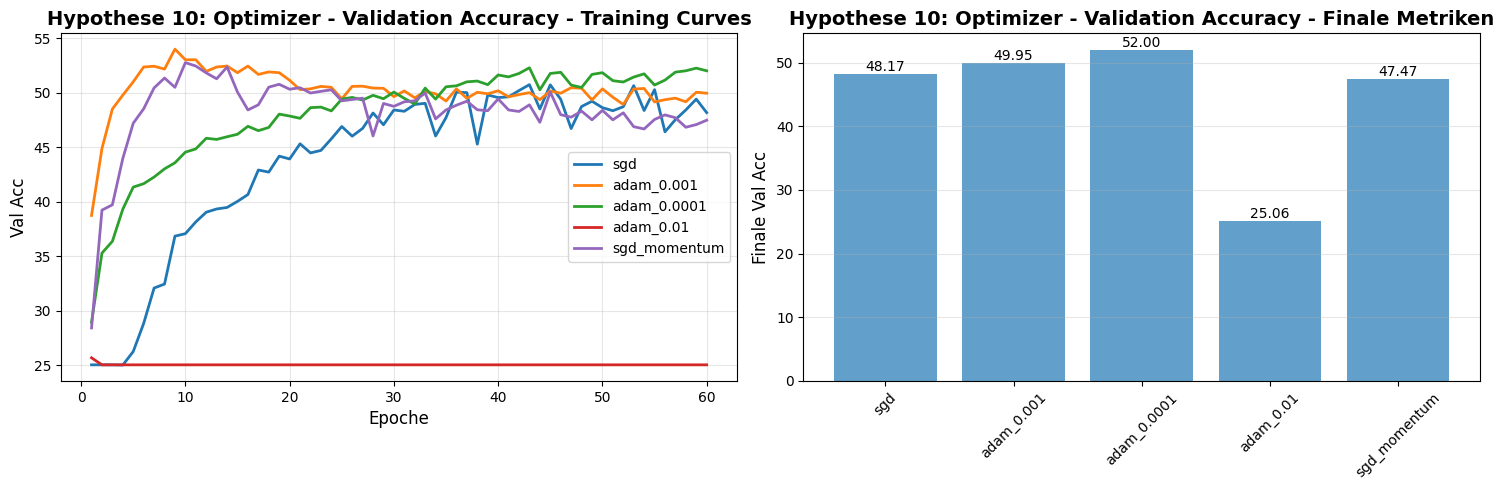

Ergebnisse gespeichert: results/category6_all_results.json


In [39]:
# Analyse
print("="*80)
print("ANALYSE HYPOTHESE 10: OPTIMIZER")
print("="*80)
summary_data = []
for name, result in hypothesis_10_results.items():
    summary_data.append({
        'Optimizer': name.replace('_', ' ').title(),
        'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
        'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
        'Overfitting-Gap (%)': f"{result.get('overfitting_gap_acc', 0):.2f}"
    })
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

plot_experiment_comparison(hypothesis_10_results, metric='val_acc',
                         title='Hypothese 10: Optimizer - Validation Accuracy')
plt.savefig('plots/experiments/hyp10_optimizer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plot_model_complexity_analysis(hypothesis_10_results, complexity_metric='num_params')
plt.savefig('plots/experiments/hyp10_complexity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

plot_training_curves_comparison(hypothesis_10_results,
                                title='Hypothese 10: Optimizer - Trainingskurven')
plt.savefig('plots/experiments/hyp10_optimizer_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

all_results = {
    'hypothesis_10': hypothesis_10_results,
    'summary': {
        'best': max(hypothesis_10_results.keys(), 
                   key=lambda k: hypothesis_10_results[k]['best_val_acc'])
    }
}
save_experiment_results(all_results, 'results/category6_all_results.json')

## Bestes Model

Hier wird das **finale Modell** (Kombination der besten OFAT-Ergebnisse) trainiert.

**Finale Modell-Konfiguration:**

| Komponente | Baseline | Finales Modell | Quelle |
|---|---|---|---|
| **Architektur** |
| Conv-Layer | 3 | 3 | H1: 4 Layer nur +0.12% |
| Filter | [16, 32, 64] | **[32, 64, 128]** | H2: Wide-Konfiguration +1.74% |
| FC Units | 64 | **32** | H3: Beste Effizienz −0.38% |
| **Conv-Settings** |
| Kernel Size | 3×3 | **3×3** | H4: Klar optimal |
| Pooling | MaxPool | **MaxPool** | H5: Essentiell |
| **Regularisierung** |
| Augmentation | Keine | **Translation (±10%)** | H7: +3.28% |
| BatchNorm | Nein | **Ja** | H8: +3.64% |
| Dropout | 0.0 | **0.0** | H6: Konflikt mit BatchNorm |
| **Training** |
| Optimizer | SGD | **Adam** | H10: +3.26%, Epoche 9 |
| Learning Rate | 0.01 | **0.001** | H10: Adam-optimal |
| Init | Default | **Default** | H9: Optimal |
| Early Stopping | Nein | **Ja (Val Acc)** | Verhindert Degradation |


In [5]:
# Finales Bestes Modell: Kombination aller optimalen Hyperparameter
final_model_file = 'results/final_best_model.json'
final_model_results = {}

# Baseline zum Vergleich
baseline_comparison = copy.deepcopy(baseline_results)
baseline_comparison['experiment_name'] = 'baseline_comparison'
final_model_results['baseline'] = baseline_comparison

print("\n" + "="*80)
print("FINALES BESTES MODELL")
print("Kombination aller optimalen Hyperparameter aus OFAT-Experimenten")
print("="*80)

# Finales optimiertes Modell
print("\n" + "-"*60)
print("Experiment: Finales Bestes Modell")
print("Konfiguration:")
print("  - Conv-Filter: [32, 64, 128] (H2: Wide)")
print("  - FC Units: 32 (H3: Effizient)")
print("  - Kernel: 3×3 (H4: Optimal)")
print("  - Pooling: MaxPool (H5: Essentiell)")
print("  - Augmentation: Translation ±10% (H7: +3.28%)")
print("  - BatchNorm: Ja (H8: +3.64%)")
print("  - Optimizer: Adam LR=0.001 (H10: +3.26%)")
print("  - Init: PyTorch Default (H9: Optimal)")
print("-"*60)

final_train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

final_eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Gleicher Split wie Baseline (Indices aus random_split)
train_indices = train_dataset.indices
val_indices = val_dataset.indices

final_full_train_aug = datasets.ImageFolder(root=train_dir, transform=final_train_transform)
final_full_train_eval = datasets.ImageFolder(root=train_dir, transform=final_eval_transform)

final_train_dataset = torch.utils.data.Subset(final_full_train_aug, train_indices)
final_val_dataset = torch.utils.data.Subset(final_full_train_eval, val_indices)

final_test_dataset = datasets.ImageFolder(root=test_dir, transform=final_eval_transform)

final_train_loader = DataLoader(
    final_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory,
)

final_val_loader = DataLoader(
    final_val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory,
)

final_test_loader = DataLoader(
    final_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory,
)

result_final = run_hyperparameter_experiment(
    experiment_name='final_best_model',
    model_class=FlexibleCNN,
    model_kwargs={
        'img_size': img_size,
        'num_classes': num_classes,
        'num_conv_layers': 3,
        'filters_per_layer': [32, 64, 128],
        'kernel_size': 3,
        'fc_units': 32,
        'pooling_type': 'max',
        'dropout_rate': 0.0,
        'use_batchnorm': True,
    },
    train_loader=final_train_loader,
    val_loader=final_val_loader,
    test_loader=final_test_loader,
    num_epochs=60,
    learning_rate=0.001,
    batch_size=32,
    use_wandb=True,
    optimizer_type='adam',
    save_model=True,
    save_dir='models',
)

final_model_results['final_best'] = result_final
save_hypothesis_results(final_model_results, final_model_file)



FINALES BESTES MODELL
Kombination aller optimalen Hyperparameter aus OFAT-Experimenten

------------------------------------------------------------
Experiment: Finales Bestes Modell
Konfiguration:
  - Conv-Filter: [32, 64, 128] (H2: Wide)
  - FC Units: 32 (H3: Effizient)
  - Kernel: 3×3 (H4: Optimal)
  - Pooling: MaxPool (H5: Essentiell)
  - Augmentation: Translation ±10% (H7: +3.28%)
  - BatchNorm: Ja (H8: +3.64%)
  - Optimizer: Adam LR=0.001 (H10: +3.26%)
  - Init: PyTorch Default (H9: Optimal)
------------------------------------------------------------

EXPERIMENT: final_best_model
Modell-Parameter: {'img_size': 48, 'num_classes': 7, 'num_conv_layers': 3, 'filters_per_layer': [32, 64, 128], 'kernel_size': 3, 'fc_units': 32, 'pooling_type': 'max', 'dropout_rate': 0.0, 'use_batchnorm': True}
Device: cuda
Epochen: 60, LR: 0.001, Batch: 32
Modell-Parameter: 240,839 total, 240,839 trainable


Training startet: 60 Epochen, LR=0.001, Batch=32
------------------------------------------------------------
Epoch   1/60 | Train Loss: 1.6892 | Val Loss: 1.5223 | Train Acc: 31.24% | Val Acc: 39.29%
Epoch   5/60 | Train Loss: 1.4180 | Val Loss: 1.3836 | Train Acc: 43.12% | Val Acc: 44.93%
Epoch  10/60 | Train Loss: 1.3100 | Val Loss: 1.3199 | Train Acc: 47.39% | Val Acc: 46.99%
Epoch  15/60 | Train Loss: 1.2395 | Val Loss: 1.2737 | Train Acc: 50.42% | Val Acc: 49.44%
Epoch  20/60 | Train Loss: 1.1951 | Val Loss: 1.3523 | Train Acc: 52.06% | Val Acc: 46.69%
Epoch  25/60 | Train Loss: 1.1430 | Val Loss: 1.2964 | Train Acc: 54.61% | Val Acc: 50.94%
Epoch  30/60 | Train Loss: 1.1052 | Val Loss: 1.2946 | Train Acc: 56.42% | Val Acc: 49.34%
Epoch  35/60 | Train Loss: 1.0758 | Val Loss: 1.2851 | Train Acc: 56.96% | Val Acc: 50.78%
Epoch  40/60 | Train Loss: 1.0401 | Val Loss: 1.3057 | Train Acc: 58.93% | Val Acc: 52.58%
Epoch  45/60 | Train Loss: 1.0172 | Val Loss: 1.3243 | Train Acc: 59.89

c:\Users\Michelle\Desktop\Uni\Code\Deep_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Michelle\Desktop\Uni\Code\Deep_Learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Modell gespeichert: models\final_best_model.pth

ERGEBNISSE: final_best_model
Beste Validation Accuracy: 52.82% (Epoche 53)
Finale Validation Accuracy: 51.92%
Finale Validation F1-Score: 0.4980
Overfitting-Gap (Acc): 11.04%
Test Accuracy: 0.52%

✓ Speicher nach Experiment freigegeben
Ergebnisse gespeichert: results/final_best_model.json
✓ Hypothesen-Ergebnisse gespeichert: results/final_best_model.json


ANALYSE: BASELINE VS BESTES MODELL

Zusammenfassung:
    Modell Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
  Baseline   171,271             50.73              48.17               43.02
Final Best   240,839             52.82              51.92               11.04


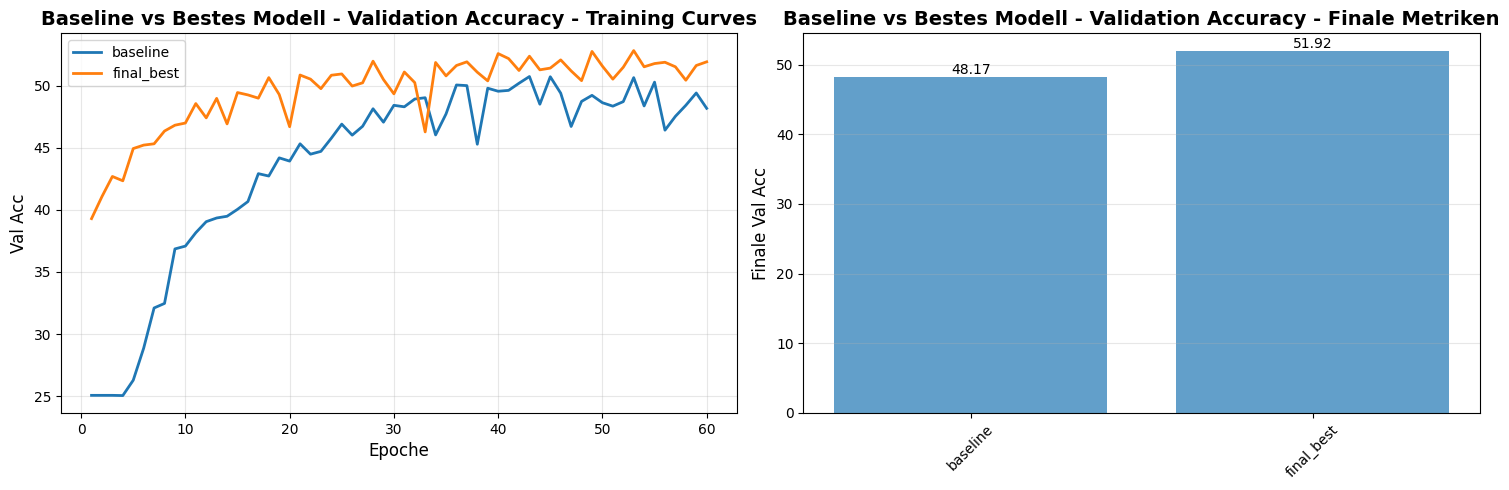

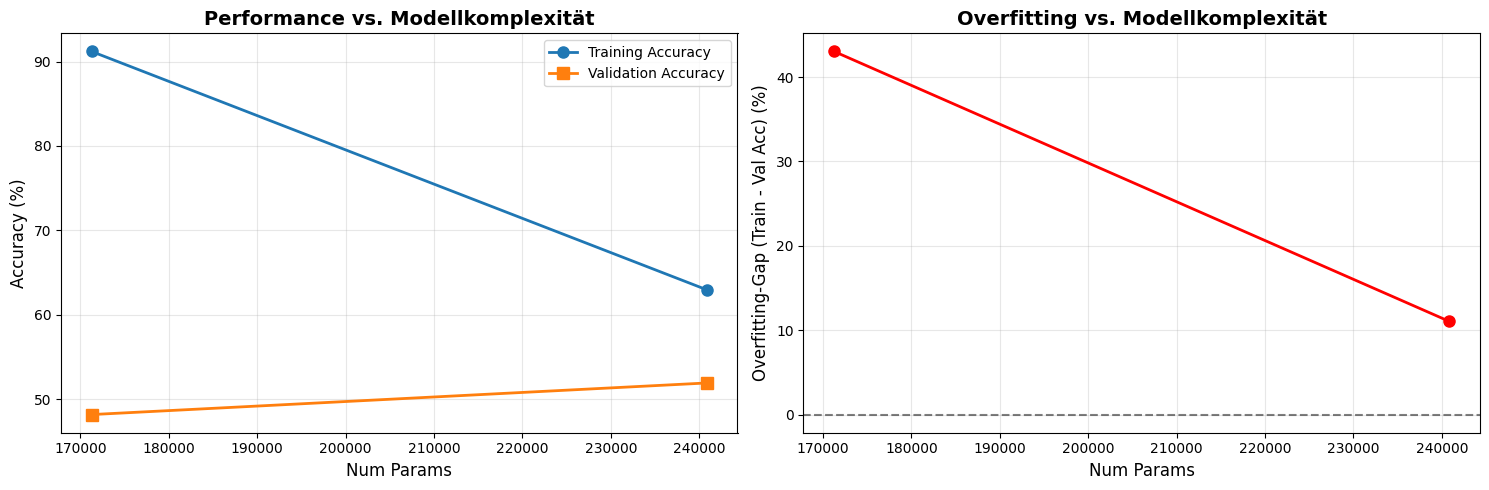

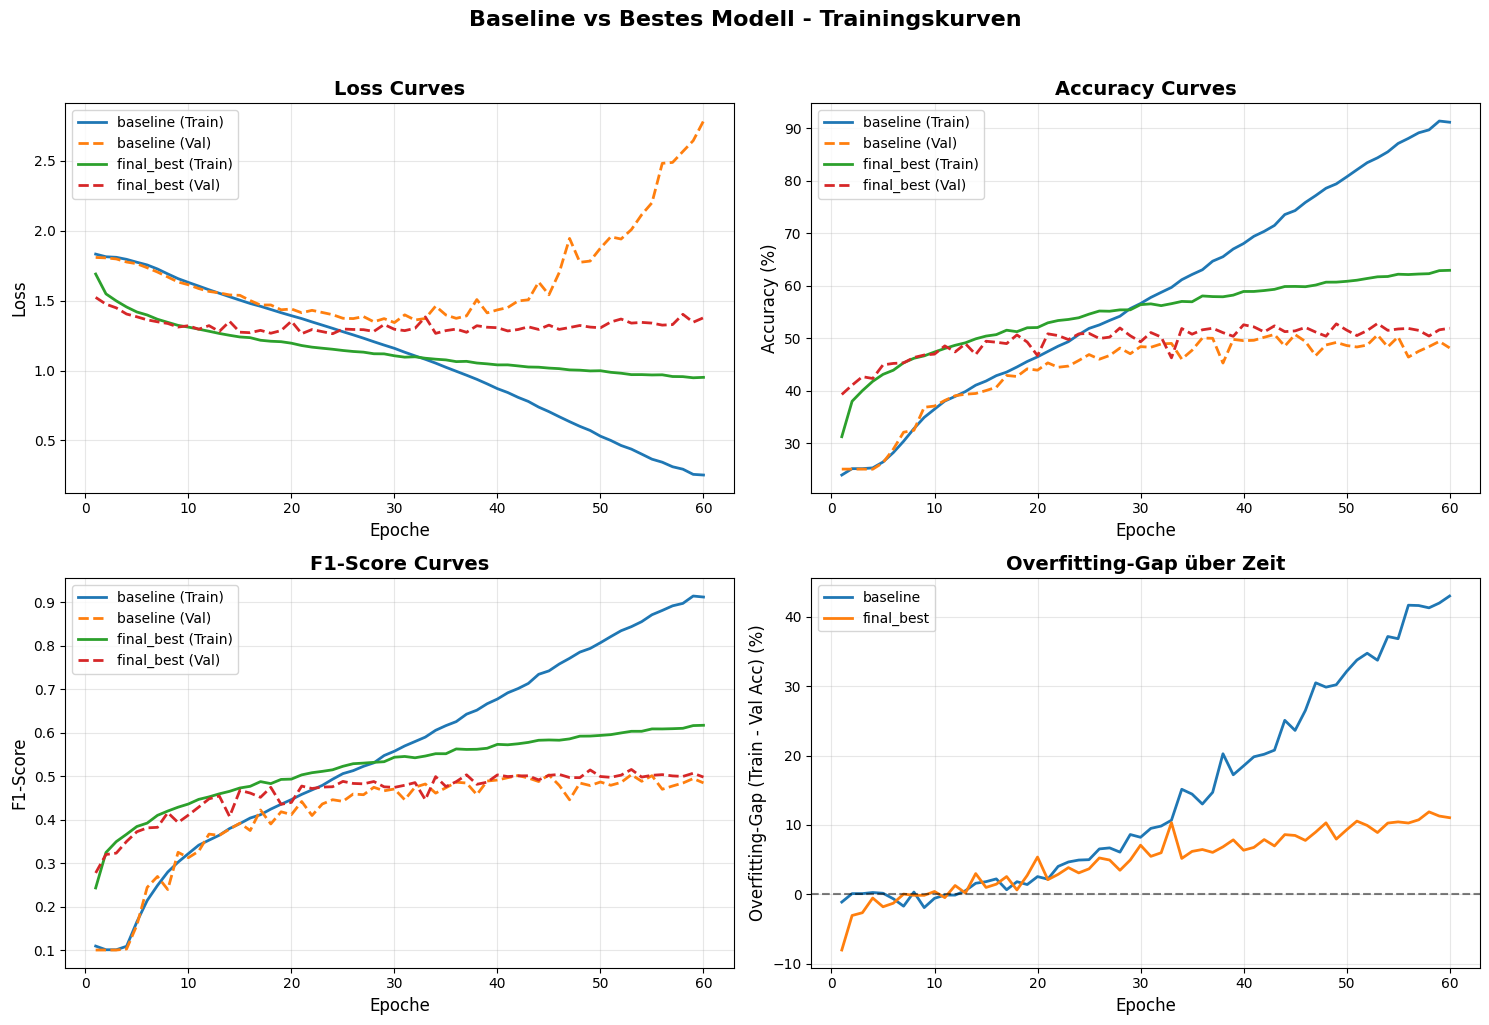

In [7]:
# Analyse & Plots: Baseline vs Bestes Modell (wie Hypothesen)
best_model_file = "results/final_best_model.json"
best_model_results = load_hypothesis_results(best_model_file) or {}

print("=" * 80)
print("ANALYSE: BASELINE VS BESTES MODELL")
print("=" * 80)

summary_data = []
for name, result in best_model_results.items():
    summary_data.append(
        {
            "Modell": name.replace("_", " ").title(),
            "Parameter": f"{result.get('num_params', 0):,}",
            "Beste Val Acc (%)": f"{result.get('best_val_acc', 0):.2f}",
            "Finale Val Acc (%)": f"{result.get('final_val_acc', 0):.2f}",
            "Overfitting-Gap (%)": f"{result.get('overfitting_gap_acc', 0):.2f}",
        }
    )

df_summary = pd.DataFrame(summary_data)
print("\nZusammenfassung:")
print(df_summary.to_string(index=False))

os.makedirs("plots/experiments", exist_ok=True)

plot_experiment_comparison(
    best_model_results,
    metric="val_acc",
    title="Baseline vs Bestes Modell - Validation Accuracy",
)
plt.savefig("plots/experiments/baseline_vs_best_val_acc.png", dpi=300, bbox_inches="tight")
plt.show()

plot_model_complexity_analysis(best_model_results, complexity_metric="num_params")
plt.savefig("plots/experiments/baseline_vs_best_complexity_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

plot_training_curves_comparison(
    best_model_results,
    title="Baseline vs Bestes Modell - Trainingskurven",
)
plt.savefig("plots/experiments/baseline_vs_best_training_curves.png", dpi=300, bbox_inches="tight")
plt.show()
